# TESS Atlas fit for TOI 263

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 263.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-263.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-263.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-263.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 263

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 263 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

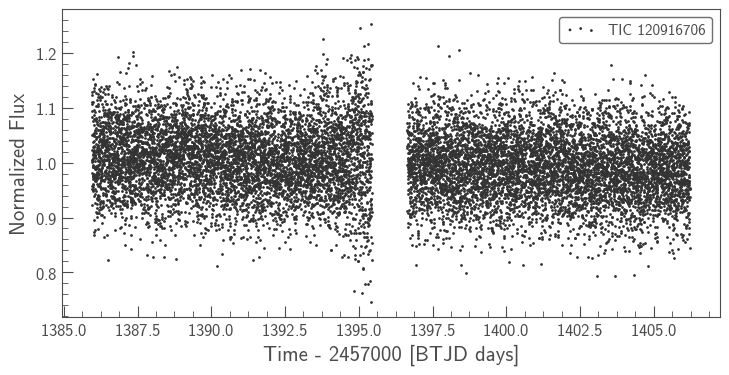

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -75426.06183708103 -> -75420.4034516392


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -74230.9109171057 -> -74203.67870171242


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -74203.67870171242 -> -74111.94179959413


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -74111.94179959413 -> -74111.86396841492


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -74111.86396841492 -> -74111.82757339881


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -74111.82757339881 -> -74111.73916671518


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -74111.73916671518 -> -73975.62362069818


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -73975.62362069818 -> -73975.62362069818


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -73975.62362069818 -> -73975.62362069818


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -73975.62362069818 -> -73975.62362069818


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -73975.62362069818 -> -73975.62362069818


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -73975.62362069818 -> -73975.62362069818


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -73975.62362069818 -> -73975.62362069818


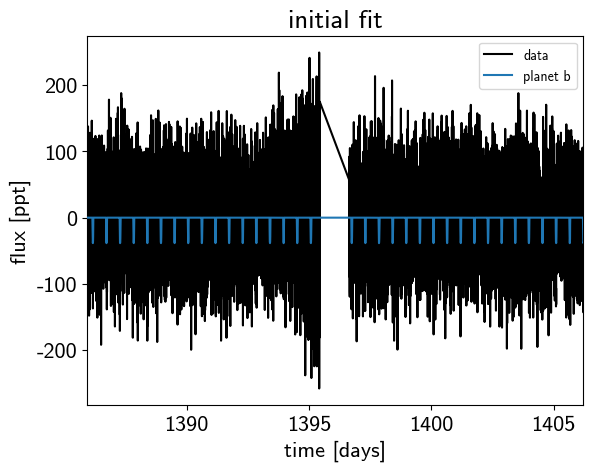

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:06, 14.07draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:09, 10.03draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:16,  5.70draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:20,  4.59draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:20,  4.53draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:24,  3.68draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:20,  4.33draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:27,  3.24draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:26,  3.29draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:24,  3.43draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:21,  3.85draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:23,  3.43draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:23,  3.45draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:21,  3.67draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:24,  3.19draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:24,  3.17draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:22,  3.27draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:21,  3.38draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:18,  3.90draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:20,  3.53draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:07<00:20,  3.46draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:18,  3.70draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:08<00:21,  3.12draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:09<00:20,  3.18draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:09<00:19,  3.30draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:15,  3.98draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:10<00:17,  3.44draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:16,  3.65draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:10<00:16,  3.68draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:17,  3.33draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:11<00:15,  3.84draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:11<00:18,  3.08draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:12<00:17,  3.23draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:12<00:13,  3.90draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:12<00:15,  3.45draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:13<00:17,  3.00draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:13<00:15,  3.17draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:13<00:14,  3.43draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:14<00:13,  3.50draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:14<00:16,  2.87draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:15<00:14,  3.11draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:15<00:14,  3.10draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:15<00:12,  3.43draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:16<00:15,  2.75draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:16<00:13,  2.97draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:17<00:13,  2.82draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:17<00:11,  3.31draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:18<00:13,  2.66draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:18<00:11,  3.07draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:18<00:11,  3.05draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:19<00:13,  2.58draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:19<00:11,  2.82draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:20<00:12,  2.58draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:20<00:10,  2.76draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:20<00:08,  3.19draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:21<00:08,  3.11draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:21<00:08,  3.07draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:21<00:07,  3.51draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:22<00:08,  2.78draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:22<00:07,  2.98draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:23<00:06,  3.10draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:23<00:05,  3.48draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:24<00:05,  3.11draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:24<00:05,  3.36draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:24<00:04,  3.37draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:24<00:04,  3.25draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:25<00:03,  3.64draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:25<00:04,  3.06draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:26<00:05,  2.05draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:27<00:07,  1.57draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:28<00:05,  1.69draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:29<00:05,  1.56draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:29<00:04,  1.55draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:30<00:03,  1.52draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:31<00:03,  1.47draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:31<00:02,  1.45draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:32<00:02,  1.44draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:33<00:01,  1.42draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:34<00:00,  1.41draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:37<00:00,  1.40s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:06, 14.10draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:12,  7.44draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:17,  5.17draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:27,  3.37draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:27,  3.30draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:26,  3.33draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:25,  3.41draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:25,  3.35draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:21,  3.90draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:24,  3.35draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:30,  2.66draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:26,  2.94draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:28,  2.78draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:21,  3.52draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:24,  3.12draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:21,  3.48draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:25,  2.94draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:19,  3.66draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:08<00:26,  2.69draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:08<00:24,  2.86draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:09<00:22,  3.06draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:09<00:20,  3.23draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:09<00:20,  3.16draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:10<00:21,  3.01draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:10<00:19,  3.20draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:10<00:22,  2.82draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:11<00:19,  3.23draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:11<00:23,  2.64draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:12<00:20,  2.88draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:12<00:17,  3.25draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:12<00:17,  3.25draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:13<00:18,  3.01draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:13<00:15,  3.46draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:13<00:19,  2.84draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:14<00:17,  2.89draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:14<00:15,  3.30draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:15<00:14,  3.40draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:15<00:16,  2.99draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:15<00:14,  3.14draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:16<00:16,  2.86draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:16<00:16,  2.80draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:17<00:15,  2.77draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:17<00:16,  2.62draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:17<00:14,  2.82draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:18<00:15,  2.60draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:18<00:13,  2.92draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:18<00:11,  3.38draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:19<00:12,  3.02draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:19<00:11,  3.25draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:19<00:12,  2.82draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:20<00:10,  3.30draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:20<00:12,  2.74draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:21<00:10,  2.82draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:21<00:09,  2.98draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:22<00:07,  3.51draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:22<00:08,  3.05draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:22<00:07,  3.34draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:23<00:08,  2.98draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:23<00:06,  3.51draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:23<00:06,  3.48draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:24<00:06,  3.48draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:24<00:05,  3.52draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:24<00:04,  4.00draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:25<00:04,  3.41draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:25<00:04,  3.61draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:25<00:04,  3.35draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:26<00:04,  3.27draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:26<00:04,  3.16draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:26<00:03,  3.02draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:27<00:03,  3.22draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:27<00:02,  3.87draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:27<00:02,  3.63draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:28<00:03,  2.46draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:29<00:03,  2.07draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:29<00:03,  1.83draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:30<00:02,  1.92draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:30<00:01,  2.38draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:31<00:01,  2.01draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:31<00:01,  1.84draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:32<00:00,  1.75draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:35<00:00,  1.20s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<00:42,  4.82draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:00<00:39,  5.12draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<00:41,  4.88draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:00<00:41,  4.78draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<00:41,  4.85draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<00:52,  3.78draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<00:46,  4.28draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:01<00:56,  3.48draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:02<00:56,  3.47draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:02<00:53,  3.62draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:02<00:43,  4.45draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:03<00:52,  3.62draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:03<00:42,  4.44draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:03<00:55,  3.43draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:03<00:44,  4.21draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:04<00:59,  3.16draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:04<00:55,  3.31draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:04<00:45,  4.02draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:05<00:54,  3.34draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:05<00:52,  3.45draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:05<00:52,  3.48draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:06<00:52,  3.43draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:07<00:46,  3.75draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:07<00:43,  3.99draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:08<00:38,  4.42draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:08<00:45,  3.76draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:08<00:39,  4.27draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:09<00:48,  3.44draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:09<00:43,  3.81draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:09<00:38,  4.31draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:09<00:31,  5.23draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:10<00:41,  3.86draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:10<00:43,  3.69draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:10<00:36,  4.35draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:11<00:44,  3.51draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:11<00:47,  3.31draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:11<00:42,  3.68draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:12<00:47,  3.29draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:12<00:39,  3.89draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:12<00:40,  3.81draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:13<00:34,  4.35draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:13<00:39,  3.77draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:13<00:31,  4.77draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:13<00:41,  3.55draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:14<00:36,  3.99draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:14<00:41,  3.51draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:14<00:37,  3.84draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:15<00:41,  3.46draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:15<00:31,  4.54draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:15<00:28,  4.93draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:15<00:24,  5.69draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:16<00:26,  5.20draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:16<00:29,  4.52draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:16<00:25,  5.25draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:16<00:30,  4.31draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:16<00:27,  4.73draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:17<00:25,  5.18draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:17<00:30,  4.33draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:17<00:30,  4.25draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:17<00:29,  4.28draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:18<00:25,  5.04draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:18<00:32,  3.87draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:18<00:28,  4.37draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:18<00:34,  3.61draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:19<00:29,  4.19draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:19<00:33,  3.62draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:20<00:34,  3.48draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:20<00:30,  3.95draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:20<00:24,  4.72draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:20<00:24,  4.69draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:21<00:34,  3.34draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:21<00:32,  3.49draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:21<00:30,  3.71draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:22<00:30,  3.69draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:22<00:34,  3.18draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:22<00:28,  3.88draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:23<00:27,  3.89draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:23<00:32,  3.34draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:23<00:25,  4.13draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:24<00:33,  3.13draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:24<00:31,  3.31draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:25<00:28,  3.49draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:25<00:25,  3.99draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:25<00:21,  4.57draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:25<00:20,  4.76draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:25<00:18,  5.15draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:26<00:18,  5.24draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:26<00:23,  4.02draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:26<00:23,  4.00draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:27<00:30,  3.06draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:27<00:23,  3.91draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:28<00:31,  2.83draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:28<00:24,  3.56draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:28<00:32,  2.69draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:29<00:30,  2.77draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:29<00:22,  3.64draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:30<00:28,  2.85draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:30<00:24,  3.37draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:30<00:28,  2.82draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:30<00:24,  3.19draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:31<00:24,  3.13draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:31<00:25,  3.05draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:31<00:22,  3.37draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:32<00:26,  2.78draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:32<00:25,  2.90draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:33<00:22,  3.16draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:33<00:19,  3.49draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:34<00:17,  3.99draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:34<00:15,  4.39draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:34<00:15,  4.19draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:34<00:15,  4.15draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:35<00:15,  4.06draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:35<00:15,  4.00draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:35<00:13,  4.44draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:36<00:12,  4.58draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:36<00:12,  4.35draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:37<00:13,  4.00draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:37<00:10,  4.84draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:37<00:13,  3.82draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:37<00:11,  4.46draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:38<00:13,  3.60draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:38<00:11,  4.20draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:38<00:13,  3.60draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:39<00:11,  4.21draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:39<00:12,  3.66draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:39<00:11,  4.00draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:39<00:11,  3.82draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:40<00:10,  4.01draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:40<00:11,  3.62draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:40<00:10,  4.02draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:40<00:10,  3.71draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:41<00:09,  3.96draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:41<00:10,  3.66draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:41<00:09,  4.01draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:42<00:10,  3.58draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:42<00:09,  3.84draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:42<00:08,  3.97draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:42<00:08,  3.69draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:42<00:07,  4.08draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:43<00:08,  3.68draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:43<00:08,  3.61draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:43<00:07,  3.68draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:44<00:07,  3.52draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:44<00:07,  3.77draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:44<00:08,  3.20draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:44<00:06,  3.63draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:45<00:07,  3.10draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:45<00:06,  3.45draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:46<00:07,  2.82draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:46<00:06,  2.95draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:47<00:05,  3.16draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:47<00:04,  3.28draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:47<00:03,  4.07draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:48<00:04,  3.02draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:49<00:03,  3.03draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:49<00:03,  3.10draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:50<00:02,  3.16draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:50<00:01,  3.55draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:50<00:01,  3.65draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:51<00:01,  3.58draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:51<00:00,  3.31draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:51<00:00,  3.72draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:52<00:00,  2.07draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:54<00:00,  1.33draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:08, 47.39draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:19, 20.08draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:00<00:20, 19.55draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:00<00:27, 14.48draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:00<00:36, 10.83draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:01<00:48,  7.99draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:01<01:17,  5.00draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:01<01:04,  5.97draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:02<01:05,  5.87draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:02<00:56,  6.77draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:02<00:43,  8.71draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:02<00:35, 10.76draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:02<00:29, 12.77draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:02<00:26, 13.94draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:03<00:46,  7.97draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:03<01:07,  5.44draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:04<01:24,  4.35draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:05<01:30,  4.03draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:05<01:27,  4.16draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:05<01:42,  3.54draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:06<01:35,  3.77draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:06<01:21,  4.43draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:06<01:25,  4.20draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:06<01:34,  3.76draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:07<01:32,  3.82draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:07<01:24,  4.21draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:08<01:23,  4.21draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:08<01:19,  4.43draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:09<02:09,  2.70draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:09<01:40,  3.45draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:09<01:40,  3.44draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:09<01:30,  3.81draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:10<01:22,  4.16draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:10<01:29,  3.83draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:10<01:33,  3.66draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:10<01:16,  4.45draws/s]

Sampling 2 chains:  16%|█▌        | 64/404 [00:11<01:43,  3.29draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:11<01:39,  3.39draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:12<01:32,  3.63draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:12<01:33,  3.58draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:12<01:22,  4.07draws/s]

Sampling 2 chains:  18%|█▊        | 71/404 [00:13<01:34,  3.51draws/s]

Sampling 2 chains:  18%|█▊        | 73/404 [00:13<01:20,  4.11draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:13<01:15,  4.40draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:13<00:58,  5.62draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:13<00:47,  6.82draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:14<00:37,  8.62draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:14<00:29, 10.71draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:14<00:24, 12.71draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:14<00:22, 14.24draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:14<00:24, 12.69draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:14<00:22, 13.67draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:15<00:46,  6.64draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:16<01:00,  5.01draws/s]

Sampling 2 chains:  25%|██▌       | 101/404 [00:16<01:07,  4.52draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:16<01:12,  4.14draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:17<01:34,  3.18draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:17<01:36,  3.10draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:18<01:32,  3.21draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:18<01:30,  3.27draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:19<01:35,  3.08draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:19<01:23,  3.51draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:19<01:13,  3.96draws/s]

Sampling 2 chains:  28%|██▊       | 113/404 [00:19<01:02,  4.66draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:20<01:01,  4.73draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:20<01:07,  4.30draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:20<01:04,  4.43draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:21<01:10,  4.04draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:21<01:10,  4.03draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:21<01:34,  3.02draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:22<01:33,  3.00draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:22<01:17,  3.65draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:22<01:09,  4.00draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:23<01:09,  4.04draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:23<01:01,  4.51draws/s]

Sampling 2 chains:  31%|███▏      | 127/404 [00:23<01:26,  3.21draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:24<01:23,  3.30draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:24<01:28,  3.10draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:24<01:45,  2.59draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:25<01:38,  2.76draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:25<01:21,  3.34draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:26<01:50,  2.44draws/s]

Sampling 2 chains:  33%|███▎      | 135/404 [00:26<01:25,  3.15draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:27<01:51,  2.40draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:27<01:44,  2.56draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:27<01:24,  3.14draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:28<01:38,  2.69draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:28<01:45,  2.50draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:29<01:27,  3.00draws/s]

Sampling 2 chains:  35%|███▌      | 143/404 [00:29<01:56,  2.24draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:29<01:37,  2.67draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:30<01:37,  2.66draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:30<01:23,  3.11draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:30<01:19,  3.22draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:31<01:14,  3.41draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:31<01:07,  3.78draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:31<01:01,  4.11draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:32<01:04,  3.93draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:32<00:56,  4.43draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:32<00:47,  5.22draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:32<00:49,  4.97draws/s]

Sampling 2 chains:  39%|███▉      | 158/404 [00:32<00:42,  5.76draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:33<00:35,  6.78draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:33<00:39,  6.11draws/s]

Sampling 2 chains:  40%|████      | 163/404 [00:33<00:44,  5.46draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:33<00:56,  4.24draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:34<00:53,  4.48draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:34<01:04,  3.69draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:34<00:57,  4.13draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [00:34<00:52,  4.49draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:35<00:45,  5.12draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:35<00:44,  5.29draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:35<00:51,  4.53draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:35<00:43,  5.29draws/s]

Sampling 2 chains:  43%|████▎     | 175/404 [00:36<00:46,  4.89draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:36<00:39,  5.80draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:36<00:34,  6.60draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:36<00:30,  7.29draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:36<00:29,  7.47draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:37<00:25,  8.51draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:37<00:26,  8.36draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:37<00:27,  7.81draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:37<00:25,  8.62draws/s]

Sampling 2 chains:  47%|████▋     | 189/404 [00:37<00:41,  5.14draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:38<00:43,  4.89draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:38<00:36,  5.77draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:38<00:35,  5.93draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:38<00:37,  5.57draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:38<00:33,  6.22draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:39<00:33,  6.17draws/s]

Sampling 2 chains:  49%|████▉     | 197/404 [00:39<00:52,  3.92draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:40<01:11,  2.90draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:40<00:55,  3.68draws/s]

Sampling 2 chains:  50%|████▉     | 201/404 [00:40<00:56,  3.61draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:40<00:49,  4.06draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:41<00:59,  3.34draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:41<00:49,  4.03draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [00:41<01:00,  3.27draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:42<01:01,  3.23draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:42<00:56,  3.46draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:42<01:10,  2.76draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:43<00:52,  3.69draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:43<00:56,  3.42draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:43<01:00,  3.18draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:44<00:56,  3.37draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:44<01:14,  2.52draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:45<01:08,  2.72draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:45<00:58,  3.20draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:46<01:10,  2.61draws/s]

Sampling 2 chains:  54%|█████▍    | 220/404 [00:46<01:00,  3.05draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:46<01:04,  2.83draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:47<01:08,  2.64draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:47<00:57,  3.16draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:47<01:08,  2.64draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:48<01:03,  2.81draws/s]

Sampling 2 chains:  56%|█████▋    | 228/404 [00:48<01:00,  2.93draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:49<00:57,  3.06draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:49<00:46,  3.74draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:49<00:56,  3.03draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:50<00:52,  3.26draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:50<00:59,  2.86draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:51<00:57,  2.92draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:51<01:00,  2.77draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:51<00:54,  3.04draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:52<01:07,  2.45draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:52<00:53,  3.10draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:52<01:04,  2.53draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:53<00:55,  2.95draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:53<00:44,  3.61draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:53<00:58,  2.74draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:54<00:54,  2.92draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:54<00:45,  3.50draws/s]

Sampling 2 chains:  61%|██████    | 247/404 [00:55<00:53,  2.96draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [00:55<00:46,  3.32draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:55<00:51,  3.01draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:56<00:55,  2.77draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:56<00:47,  3.19draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:56<00:58,  2.58draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:57<00:56,  2.68draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:58<00:51,  2.88draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:58<00:43,  3.36draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:58<00:48,  2.98draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [00:59<00:45,  3.17draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:59<00:46,  3.13draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:59<00:47,  3.01draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [01:00<00:47,  3.02draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [01:00<00:45,  3.11draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [01:00<00:41,  3.39draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [01:00<00:34,  4.01draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [01:01<00:38,  3.60draws/s]

Sampling 2 chains:  66%|██████▌   | 267/404 [01:01<00:37,  3.62draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [01:01<00:31,  4.25draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [01:01<00:30,  4.38draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [01:02<00:27,  4.76draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [01:02<00:24,  5.30draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [01:02<00:27,  4.67draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [01:02<00:25,  5.03draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [01:03<00:37,  3.37draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [01:03<00:33,  3.71draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [01:03<00:30,  4.04draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [01:04<00:27,  4.43draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [01:04<00:26,  4.56draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [01:04<00:22,  5.44draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [01:04<00:29,  4.09draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [01:05<00:29,  3.98draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [01:05<00:27,  4.28draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [01:05<00:30,  3.83draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [01:06<00:31,  3.56draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [01:06<00:26,  4.20draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [01:06<00:21,  5.12draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [01:07<00:25,  4.21draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [01:07<00:25,  4.20draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [01:07<00:23,  4.47draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [01:08<00:30,  3.52draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [01:08<00:28,  3.64draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [01:08<00:35,  2.95draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [01:09<00:31,  3.28draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [01:09<00:25,  3.93draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [01:09<00:38,  2.64draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [01:10<00:37,  2.69draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [01:10<00:38,  2.55draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [01:11<00:38,  2.53draws/s]

Sampling 2 chains:  76%|███████▌  | 308/404 [01:11<00:31,  3.07draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [01:12<00:32,  2.92draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [01:12<00:27,  3.46draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [01:12<00:27,  3.33draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [01:12<00:26,  3.41draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [01:13<00:27,  3.36draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [01:13<00:24,  3.64draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [01:13<00:21,  4.08draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [01:14<00:19,  4.47draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [01:14<00:19,  4.26draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [01:14<00:19,  4.24draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [01:14<00:16,  5.07draws/s]

Sampling 2 chains:  80%|███████▉  | 323/404 [01:15<00:16,  4.82draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [01:15<00:20,  3.89draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [01:16<00:20,  3.84draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [01:16<00:15,  4.79draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [01:16<00:15,  4.86draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [01:16<00:17,  4.16draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [01:17<00:15,  4.77draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [01:17<00:14,  5.01draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [01:17<00:12,  5.80draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [01:17<00:09,  6.91draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [01:17<00:08,  7.77draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [01:17<00:07,  8.50draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [01:17<00:06,  9.85draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [01:18<00:04, 12.26draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [01:18<00:03, 14.43draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [01:18<00:03, 15.98draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [01:18<00:02, 17.01draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [01:18<00:02, 16.03draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [01:18<00:03, 12.62draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [01:19<00:03, 11.48draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [01:19<00:03, 11.90draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [01:19<00:03, 12.19draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [01:20<00:05,  6.53draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [01:21<00:10,  3.40draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [01:21<00:12,  2.65draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [01:22<00:14,  2.30draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [01:22<00:12,  2.56draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [01:23<00:12,  2.47draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [01:23<00:15,  2.00draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [01:24<00:16,  1.78draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [01:24<00:13,  2.06draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [01:25<00:12,  2.22draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [01:25<00:11,  2.28draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [01:26<00:10,  2.32draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [01:26<00:10,  2.35draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [01:26<00:08,  2.77draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [01:26<00:06,  3.18draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [01:27<00:06,  3.19draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [01:27<00:05,  3.40draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [01:27<00:06,  3.09draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [01:28<00:04,  3.73draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [01:28<00:03,  4.28draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [01:28<00:03,  4.44draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [01:28<00:02,  5.15draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [01:28<00:02,  5.13draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [01:28<00:02,  5.68draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [01:29<00:02,  5.39draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [01:29<00:01,  6.24draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [01:29<00:01,  7.01draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [01:29<00:01,  6.20draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [01:30<00:01,  4.23draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [01:30<00:01,  3.46draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [01:30<00:01,  2.93draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [01:31<00:01,  3.20draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [01:31<00:01,  2.98draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [01:31<00:00,  3.23draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [01:34<00:00,  1.01draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [01:34<00:00,  1.29draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:38, 21.06draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:32, 24.22draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<00:31, 25.52draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:00<00:45, 17.22draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:00<01:02, 12.56draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:01<01:10, 11.19draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:01<01:05, 11.93draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:01<01:00, 12.87draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:01<01:03, 12.20draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:01<00:58, 13.39draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:02<01:11, 10.87draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:02<01:36,  7.99draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:03<02:38,  4.86draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:03<02:36,  4.92draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:03<03:25,  3.74draws/s]

Sampling 2 chains:   4%|▍         | 36/804 [00:03<02:54,  4.40draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:04<03:00,  4.25draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:04<02:53,  4.42draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:04<03:13,  3.95draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:04<02:40,  4.75draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:05<02:38,  4.80draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:05<02:15,  5.61draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:05<01:47,  7.06draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:05<01:24,  8.91draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:05<01:08, 10.93draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:05<00:59, 12.59draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:05<01:00, 12.31draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:06<01:33,  7.96draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:06<01:53,  6.55draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:06<01:38,  7.52draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:07<02:15,  5.46draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:07<02:07,  5.78draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:08<02:03,  6.00draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:08<01:51,  6.59draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:08<01:50,  6.67draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:08<01:38,  7.43draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:08<01:54,  6.41draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:08<02:15,  5.42draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:09<01:58,  6.19draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:09<02:14,  5.43draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:09<02:02,  5.97draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:09<01:41,  7.13draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:09<01:24,  8.63draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:09<01:14,  9.68draws/s]

Sampling 2 chains:  10%|█         | 83/804 [00:10<01:14,  9.74draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:10<02:15,  5.29draws/s]

Sampling 2 chains:  11%|█         | 86/804 [00:11<03:55,  3.06draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:11<03:24,  3.50draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:12<03:51,  3.09draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:12<03:28,  3.42draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:12<03:08,  3.78draws/s]

Sampling 2 chains:  11%|█▏        | 92/804 [00:13<03:41,  3.22draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:13<03:05,  3.84draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:13<02:21,  5.01draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:13<01:54,  6.15draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:13<01:35,  7.42draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:13<01:23,  8.39draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:14<01:11,  9.74draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:14<01:09, 10.03draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:14<01:13,  9.43draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:14<01:15,  9.16draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:14<01:09,  9.99draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:15<00:59, 11.50draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:15<00:48, 14.11draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:15<00:48, 13.99draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:15<00:48, 13.89draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:15<01:06, 10.12draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:16<01:45,  6.39draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:17<02:12,  5.10draws/s]

Sampling 2 chains:  16%|█▋        | 132/804 [00:17<02:48,  3.98draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:17<02:41,  4.16draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:18<03:37,  3.08draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:18<03:43,  2.99draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:19<03:36,  3.08draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:20<03:31,  3.15draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:20<03:13,  3.43draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:20<03:47,  2.91draws/s]

Sampling 2 chains:  18%|█▊        | 143/804 [00:21<03:40,  3.00draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:21<03:37,  3.04draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:22<04:37,  2.38draws/s]

Sampling 2 chains:  18%|█▊        | 147/804 [00:22<04:10,  2.62draws/s]

Sampling 2 chains:  18%|█▊        | 148/804 [00:22<04:05,  2.68draws/s]

Sampling 2 chains:  19%|█▊        | 149/804 [00:23<03:46,  2.90draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:23<04:27,  2.44draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:24<03:41,  2.95draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:24<04:50,  2.24draws/s]

Sampling 2 chains:  19%|█▉        | 153/804 [00:24<03:54,  2.77draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:25<04:04,  2.65draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:25<04:19,  2.50draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:25<03:43,  2.90draws/s]

Sampling 2 chains:  20%|█▉        | 157/804 [00:26<04:17,  2.52draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:26<03:55,  2.75draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:27<03:54,  2.75draws/s]

Sampling 2 chains:  20%|█▉        | 160/804 [00:27<03:59,  2.69draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:27<03:36,  2.96draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:28<04:21,  2.45draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:29<04:13,  2.53draws/s]

Sampling 2 chains:  21%|██        | 166/804 [00:29<03:40,  2.89draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:29<02:55,  3.63draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:30<03:51,  2.75draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:30<03:21,  3.15draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:30<02:56,  3.59draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:30<02:18,  4.57draws/s]

Sampling 2 chains:  22%|██▏       | 174/804 [00:31<02:11,  4.80draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:31<01:54,  5.50draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [00:31<02:29,  4.21draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:32<02:17,  4.55draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:32<02:40,  3.88draws/s]

Sampling 2 chains:  23%|██▎       | 181/804 [00:32<02:26,  4.27draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:32<02:33,  4.06draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:33<02:38,  3.91draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:33<02:46,  3.71draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:34<02:42,  3.80draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:34<03:21,  3.06draws/s]

Sampling 2 chains:  23%|██▎       | 188/804 [00:34<02:43,  3.76draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:34<02:23,  4.29draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:35<03:33,  2.87draws/s]

Sampling 2 chains:  24%|██▍       | 192/804 [00:36<03:30,  2.91draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:36<03:11,  3.20draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:36<03:32,  2.86draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:37<03:34,  2.83draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [00:37<03:26,  2.95draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:37<03:25,  2.95draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:38<03:41,  2.73draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:38<03:02,  3.31draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:39<03:57,  2.55draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:39<04:02,  2.48draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:40<03:47,  2.63draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:40<03:13,  3.09draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:41<04:17,  2.33draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [00:41<03:26,  2.88draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:42<04:23,  2.26draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:42<03:32,  2.81draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [00:42<03:54,  2.53draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:43<03:38,  2.71draws/s]

Sampling 2 chains:  26%|██▋       | 212/804 [00:43<03:22,  2.92draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:43<03:52,  2.55draws/s]

Sampling 2 chains:  27%|██▋       | 215/804 [00:44<03:18,  2.97draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [00:44<02:54,  3.38draws/s]

Sampling 2 chains:  27%|██▋       | 218/804 [00:44<02:20,  4.17draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:44<02:16,  4.28draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:45<02:04,  4.67draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:45<01:36,  6.02draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:45<01:25,  6.79draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:45<01:30,  6.41draws/s]

Sampling 2 chains:  28%|██▊       | 225/804 [00:45<01:36,  6.01draws/s]

Sampling 2 chains:  28%|██▊       | 226/804 [00:46<02:35,  3.71draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:46<02:28,  3.88draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:46<03:08,  3.06draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:47<03:15,  2.94draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [00:47<03:59,  2.40draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [00:48<03:26,  2.77draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [00:48<04:34,  2.08draws/s]

Sampling 2 chains:  29%|██▉       | 234/804 [00:49<04:06,  2.32draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:49<03:28,  2.73draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:50<03:32,  2.67draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [00:50<02:54,  3.24draws/s]

Sampling 2 chains:  30%|██▉       | 238/804 [00:50<02:48,  3.37draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [00:50<03:01,  3.11draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [00:51<02:29,  3.78draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:51<02:29,  3.77draws/s]

Sampling 2 chains:  30%|███       | 242/804 [00:51<02:26,  3.85draws/s]

Sampling 2 chains:  30%|███       | 244/804 [00:51<02:04,  4.48draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:52<02:10,  4.28draws/s]

Sampling 2 chains:  31%|███       | 247/804 [00:52<01:42,  5.46draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:52<01:32,  5.98draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:52<01:16,  7.27draws/s]

Sampling 2 chains:  31%|███▏      | 252/804 [00:52<01:04,  8.61draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:52<00:58,  9.34draws/s]

Sampling 2 chains:  32%|███▏      | 256/804 [00:53<00:55,  9.87draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:53<00:52, 10.47draws/s]

Sampling 2 chains:  32%|███▏      | 261/804 [00:53<00:46, 11.73draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:53<00:43, 12.37draws/s]

Sampling 2 chains:  33%|███▎      | 267/804 [00:53<00:36, 14.72draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [00:53<00:33, 15.96draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:53<00:32, 16.58draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:54<00:30, 17.20draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:54<00:35, 15.00draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:54<00:48, 10.84draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [00:54<00:57,  9.12draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:55<01:20,  6.45draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:55<01:36,  5.40draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [00:55<01:41,  5.09draws/s]

Sampling 2 chains:  36%|███▌      | 286/804 [00:56<02:36,  3.31draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:56<02:28,  3.48draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [00:57<02:33,  3.36draws/s]

Sampling 2 chains:  36%|███▌      | 289/804 [00:57<03:08,  2.72draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:57<02:41,  3.17draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:58<02:56,  2.90draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:58<02:40,  3.17draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:59<02:26,  3.48draws/s]

Sampling 2 chains:  37%|███▋      | 297/804 [00:59<02:02,  4.15draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [00:59<01:54,  4.43draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:59<01:39,  5.08draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:59<01:27,  5.73draws/s]

Sampling 2 chains:  37%|███▋      | 301/804 [00:59<01:20,  6.21draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [01:00<01:15,  6.61draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [01:00<01:31,  5.47draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [01:00<01:43,  4.81draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [01:00<01:33,  5.33draws/s]

Sampling 2 chains:  38%|███▊      | 308/804 [01:01<01:59,  4.16draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [01:01<01:54,  4.30draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [01:01<01:42,  4.79draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [01:02<02:03,  3.97draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [01:02<02:07,  3.86draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [01:02<02:31,  3.24draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [01:03<02:12,  3.69draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [01:03<02:51,  2.85draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [01:04<02:43,  2.97draws/s]

Sampling 2 chains:  40%|███▉      | 319/804 [01:04<02:12,  3.67draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [01:04<02:35,  3.12draws/s]

Sampling 2 chains:  40%|███▉      | 321/804 [01:05<02:30,  3.21draws/s]

Sampling 2 chains:  40%|████      | 322/804 [01:05<02:38,  3.05draws/s]

Sampling 2 chains:  40%|████      | 323/804 [01:06<03:00,  2.66draws/s]

Sampling 2 chains:  40%|████      | 324/804 [01:06<02:45,  2.91draws/s]

Sampling 2 chains:  40%|████      | 325/804 [01:06<02:13,  3.59draws/s]

Sampling 2 chains:  41%|████      | 326/804 [01:06<02:28,  3.22draws/s]

Sampling 2 chains:  41%|████      | 327/804 [01:06<02:12,  3.61draws/s]

Sampling 2 chains:  41%|████      | 328/804 [01:07<01:54,  4.17draws/s]

Sampling 2 chains:  41%|████      | 329/804 [01:07<02:10,  3.65draws/s]

Sampling 2 chains:  41%|████      | 330/804 [01:07<02:13,  3.56draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [01:08<01:51,  4.24draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [01:08<01:42,  4.59draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [01:08<01:25,  5.50draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [01:08<01:11,  6.53draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [01:08<00:58,  7.95draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [01:08<00:51,  8.97draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [01:09<00:50,  9.06draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [01:09<00:43, 10.49draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [01:09<00:33, 13.45draws/s]

Sampling 2 chains:  44%|████▍     | 354/804 [01:09<00:32, 13.71draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [01:09<00:38, 11.61draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [01:10<00:42, 10.43draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [01:10<00:47,  9.34draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [01:10<01:00,  7.34draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [01:11<01:18,  5.64draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [01:11<01:41,  4.32draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [01:11<01:30,  4.83draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [01:11<01:40,  4.33draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [01:12<01:28,  4.92draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [01:12<01:40,  4.31draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [01:12<01:25,  5.05draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [01:12<01:20,  5.34draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [01:13<01:18,  5.49draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [01:13<01:22,  5.17draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [01:13<01:27,  4.88draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [01:14<01:35,  4.47draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [01:14<01:53,  3.74draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [01:14<01:38,  4.30draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [01:15<02:13,  3.16draws/s]

Sampling 2 chains:  48%|████▊     | 383/804 [01:15<02:05,  3.34draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [01:15<01:41,  4.15draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [01:16<02:02,  3.43draws/s]

Sampling 2 chains:  48%|████▊     | 386/804 [01:16<01:47,  3.88draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [01:16<01:53,  3.66draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [01:16<01:35,  4.34draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [01:17<01:17,  5.34draws/s]

Sampling 2 chains:  49%|████▉     | 392/804 [01:17<01:08,  6.06draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [01:17<01:10,  5.85draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [01:17<01:01,  6.62draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [01:17<00:53,  7.65draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [01:17<00:50,  8.04draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [01:18<00:46,  8.76draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [01:18<00:38, 10.39draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [01:18<00:33, 11.89draws/s]

Sampling 2 chains:  50%|█████     | 406/804 [01:18<00:29, 13.51draws/s]

Sampling 2 chains:  51%|█████     | 409/804 [01:18<00:25, 15.23draws/s]

Sampling 2 chains:  51%|█████     | 412/804 [01:18<00:24, 16.28draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [01:18<00:22, 17.59draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [01:18<00:19, 19.89draws/s]

Sampling 2 chains:  52%|█████▏    | 421/804 [01:19<00:18, 20.72draws/s]

Sampling 2 chains:  53%|█████▎    | 424/804 [01:19<00:32, 11.83draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [01:19<00:38,  9.91draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [01:19<00:34, 10.92draws/s]

Sampling 2 chains:  53%|█████▎    | 430/804 [01:20<00:34, 10.71draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [01:20<00:38,  9.54draws/s]

Sampling 2 chains:  54%|█████▍    | 434/804 [01:20<00:41,  8.94draws/s]

Sampling 2 chains:  54%|█████▍    | 436/804 [01:20<00:39,  9.28draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [01:20<00:34, 10.53draws/s]

Sampling 2 chains:  55%|█████▍    | 440/804 [01:21<00:31, 11.65draws/s]

Sampling 2 chains:  55%|█████▌    | 443/804 [01:21<00:26, 13.40draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [01:21<00:25, 14.31draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [01:21<00:23, 15.25draws/s]

Sampling 2 chains:  56%|█████▌    | 449/804 [01:21<00:21, 16.18draws/s]

Sampling 2 chains:  56%|█████▌    | 452/804 [01:21<00:19, 18.08draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [01:21<00:17, 19.71draws/s]

Sampling 2 chains:  57%|█████▋    | 458/804 [01:21<00:17, 19.26draws/s]

Sampling 2 chains:  57%|█████▋    | 461/804 [01:22<00:18, 18.26draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [01:22<00:17, 19.12draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [01:22<00:16, 20.29draws/s]

Sampling 2 chains:  58%|█████▊    | 470/804 [01:22<00:18, 18.32draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [01:22<00:19, 16.92draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [01:22<00:23, 13.87draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [01:23<00:39,  8.21draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [01:24<00:53,  6.04draws/s]

Sampling 2 chains:  60%|█████▉    | 479/804 [01:24<01:28,  3.66draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [01:25<01:52,  2.88draws/s]

Sampling 2 chains:  60%|█████▉    | 481/804 [01:25<01:48,  2.98draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [01:25<01:37,  3.30draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [01:26<01:26,  3.69draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [01:26<01:20,  3.95draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [01:26<01:23,  3.80draws/s]

Sampling 2 chains:  61%|██████    | 488/804 [01:27<01:32,  3.41draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [01:27<01:38,  3.20draws/s]

Sampling 2 chains:  61%|██████    | 490/804 [01:27<01:41,  3.08draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [01:27<01:22,  3.80draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [01:28<01:18,  3.97draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [01:28<01:20,  3.85draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [01:28<01:34,  3.27draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [01:29<01:39,  3.12draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [01:29<01:38,  3.14draws/s]

Sampling 2 chains:  62%|██████▏   | 497/804 [01:29<01:39,  3.08draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [01:30<01:43,  2.95draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [01:30<01:45,  2.88draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [01:30<01:27,  3.48draws/s]

Sampling 2 chains:  62%|██████▏   | 501/804 [01:30<01:22,  3.69draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [01:31<01:30,  3.34draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [01:31<01:34,  3.19draws/s]

Sampling 2 chains:  63%|██████▎   | 504/804 [01:32<01:40,  2.98draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [01:32<02:11,  2.27draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [01:33<02:21,  2.10draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [01:33<02:26,  2.03draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [01:34<02:10,  2.27draws/s]

Sampling 2 chains:  63%|██████▎   | 509/804 [01:34<02:15,  2.18draws/s]

Sampling 2 chains:  63%|██████▎   | 510/804 [01:35<02:05,  2.35draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [01:35<02:00,  2.42draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [01:35<01:40,  2.92draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [01:35<01:45,  2.76draws/s]

Sampling 2 chains:  64%|██████▍   | 514/804 [01:36<01:33,  3.09draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [01:36<01:15,  3.81draws/s]

Sampling 2 chains:  64%|██████▍   | 516/804 [01:36<01:36,  2.99draws/s]

Sampling 2 chains:  64%|██████▍   | 517/804 [01:37<01:51,  2.58draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [01:37<01:53,  2.53draws/s]

Sampling 2 chains:  65%|██████▍   | 519/804 [01:38<01:44,  2.73draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [01:38<01:28,  3.20draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [01:38<01:16,  3.68draws/s]

Sampling 2 chains:  65%|██████▍   | 522/804 [01:38<01:08,  4.10draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [01:38<01:17,  3.61draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [01:39<01:13,  3.82draws/s]

Sampling 2 chains:  65%|██████▌   | 525/804 [01:39<01:05,  4.27draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [01:39<00:59,  4.69draws/s]

Sampling 2 chains:  66%|██████▌   | 527/804 [01:40<01:42,  2.70draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [01:40<01:33,  2.95draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [01:40<01:14,  3.69draws/s]

Sampling 2 chains:  66%|██████▌   | 530/804 [01:41<01:23,  3.30draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [01:41<01:59,  2.29draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [01:42<02:00,  2.26draws/s]

Sampling 2 chains:  66%|██████▋   | 533/804 [01:42<01:51,  2.43draws/s]

Sampling 2 chains:  66%|██████▋   | 534/804 [01:42<01:39,  2.73draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [01:43<01:26,  3.11draws/s]

Sampling 2 chains:  67%|██████▋   | 537/804 [01:43<01:28,  3.02draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [01:43<01:20,  3.31draws/s]

Sampling 2 chains:  67%|██████▋   | 539/804 [01:44<01:23,  3.16draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [01:44<01:17,  3.41draws/s]

Sampling 2 chains:  67%|██████▋   | 541/804 [01:44<01:07,  3.87draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [01:44<01:06,  3.93draws/s]

Sampling 2 chains:  68%|██████▊   | 543/804 [01:45<00:59,  4.36draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [01:45<00:50,  5.20draws/s]

Sampling 2 chains:  68%|██████▊   | 545/804 [01:45<00:52,  4.95draws/s]

Sampling 2 chains:  68%|██████▊   | 546/804 [01:45<01:02,  4.12draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [01:45<00:54,  4.69draws/s]

Sampling 2 chains:  68%|██████▊   | 548/804 [01:46<01:04,  3.95draws/s]

Sampling 2 chains:  68%|██████▊   | 549/804 [01:46<00:59,  4.29draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [01:46<00:56,  4.46draws/s]

Sampling 2 chains:  69%|██████▊   | 551/804 [01:46<00:52,  4.84draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [01:46<00:48,  5.15draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [01:47<00:45,  5.51draws/s]

Sampling 2 chains:  69%|██████▉   | 554/804 [01:47<00:44,  5.64draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [01:47<00:42,  5.80draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [01:47<00:42,  5.87draws/s]

Sampling 2 chains:  69%|██████▉   | 558/804 [01:47<00:35,  6.93draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [01:47<00:28,  8.53draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [01:47<00:25,  9.33draws/s]

Sampling 2 chains:  70%|███████   | 564/804 [01:48<00:24,  9.75draws/s]

Sampling 2 chains:  70%|███████   | 566/804 [01:48<00:27,  8.72draws/s]

Sampling 2 chains:  71%|███████   | 569/804 [01:48<00:23, 10.15draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [01:48<00:22, 10.41draws/s]

Sampling 2 chains:  71%|███████▏  | 573/804 [01:48<00:19, 12.15draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [01:49<00:19, 11.50draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [01:49<00:23,  9.50draws/s]

Sampling 2 chains:  72%|███████▏  | 579/804 [01:49<00:28,  7.90draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [01:49<00:32,  6.96draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [01:50<00:36,  6.16draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [01:50<00:33,  6.68draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [01:50<00:32,  6.70draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [01:50<00:38,  5.67draws/s]

Sampling 2 chains:  73%|███████▎  | 586/804 [01:51<00:43,  4.96draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [01:51<00:39,  5.52draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [01:51<00:36,  5.95draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [01:51<00:42,  5.08draws/s]

Sampling 2 chains:  73%|███████▎  | 590/804 [01:51<00:38,  5.61draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [01:51<00:34,  6.11draws/s]

Sampling 2 chains:  74%|███████▎  | 592/804 [01:51<00:32,  6.48draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [01:52<00:31,  6.71draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [01:52<00:30,  6.96draws/s]

Sampling 2 chains:  74%|███████▍  | 596/804 [01:52<00:25,  8.25draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [01:52<00:25,  7.98draws/s]

Sampling 2 chains:  75%|███████▍  | 599/804 [01:52<00:22,  9.29draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [01:52<00:19, 10.48draws/s]

Sampling 2 chains:  75%|███████▌  | 604/804 [01:52<00:16, 12.02draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [01:53<00:18, 10.69draws/s]

Sampling 2 chains:  76%|███████▌  | 608/804 [01:53<00:18, 10.51draws/s]

Sampling 2 chains:  76%|███████▌  | 610/804 [01:53<00:17, 10.87draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [01:53<00:17, 11.03draws/s]

Sampling 2 chains:  76%|███████▋  | 614/804 [01:53<00:17, 11.11draws/s]

Sampling 2 chains:  77%|███████▋  | 616/804 [01:55<00:50,  3.75draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [01:58<03:13,  1.03s/draws]

Sampling 2 chains:  77%|███████▋  | 618/804 [02:00<04:43,  1.52s/draws]

Sampling 2 chains:  77%|███████▋  | 619/804 [02:03<05:44,  1.86s/draws]

Sampling 2 chains:  77%|███████▋  | 620/804 [02:06<06:28,  2.11s/draws]

Sampling 2 chains:  77%|███████▋  | 621/804 [02:08<06:38,  2.18s/draws]

Sampling 2 chains:  77%|███████▋  | 622/804 [02:10<06:49,  2.25s/draws]

Sampling 2 chains:  77%|███████▋  | 623/804 [02:13<06:48,  2.26s/draws]

Sampling 2 chains:  78%|███████▊  | 624/804 [02:15<06:43,  2.24s/draws]

Sampling 2 chains:  78%|███████▊  | 625/804 [02:17<06:40,  2.24s/draws]

Sampling 2 chains:  78%|███████▊  | 626/804 [02:19<06:34,  2.22s/draws]

Sampling 2 chains:  78%|███████▊  | 627/804 [02:22<06:35,  2.23s/draws]

Sampling 2 chains:  78%|███████▊  | 628/804 [02:24<06:39,  2.27s/draws]

Sampling 2 chains:  78%|███████▊  | 629/804 [02:26<06:29,  2.23s/draws]

Sampling 2 chains:  78%|███████▊  | 630/804 [02:28<06:22,  2.20s/draws]

Sampling 2 chains:  78%|███████▊  | 631/804 [02:30<06:17,  2.18s/draws]

Sampling 2 chains:  79%|███████▊  | 632/804 [02:33<06:23,  2.23s/draws]

Sampling 2 chains:  79%|███████▊  | 633/804 [02:35<06:28,  2.27s/draws]

Sampling 2 chains:  79%|███████▉  | 634/804 [02:37<06:28,  2.29s/draws]

Sampling 2 chains:  79%|███████▉  | 635/804 [02:40<06:41,  2.37s/draws]

Sampling 2 chains:  79%|███████▉  | 636/804 [02:43<07:01,  2.51s/draws]

Sampling 2 chains:  79%|███████▉  | 637/804 [02:46<07:30,  2.70s/draws]

Sampling 2 chains:  79%|███████▉  | 638/804 [02:48<07:13,  2.61s/draws]

Sampling 2 chains:  79%|███████▉  | 639/804 [02:51<07:09,  2.61s/draws]

Sampling 2 chains:  80%|███████▉  | 640/804 [02:53<06:53,  2.52s/draws]

Sampling 2 chains:  80%|███████▉  | 641/804 [02:56<06:55,  2.55s/draws]

Sampling 2 chains:  80%|███████▉  | 642/804 [02:58<06:45,  2.50s/draws]

Sampling 2 chains:  80%|███████▉  | 643/804 [03:00<06:31,  2.43s/draws]

Sampling 2 chains:  80%|████████  | 644/804 [03:03<06:27,  2.42s/draws]

Sampling 2 chains:  80%|████████  | 645/804 [03:05<06:19,  2.39s/draws]

Sampling 2 chains:  80%|████████  | 646/804 [03:07<06:05,  2.31s/draws]

Sampling 2 chains:  80%|████████  | 647/804 [03:10<05:59,  2.29s/draws]

Sampling 2 chains:  81%|████████  | 648/804 [03:12<05:53,  2.27s/draws]

Sampling 2 chains:  81%|████████  | 649/804 [03:14<05:46,  2.23s/draws]

Sampling 2 chains:  81%|████████  | 650/804 [03:16<05:39,  2.20s/draws]

Sampling 2 chains:  81%|████████  | 651/804 [03:18<05:42,  2.24s/draws]

Sampling 2 chains:  81%|████████  | 652/804 [03:21<06:00,  2.37s/draws]

Sampling 2 chains:  81%|████████  | 653/804 [03:23<05:52,  2.34s/draws]

Sampling 2 chains:  81%|████████▏ | 654/804 [03:24<04:54,  1.97s/draws]

Sampling 2 chains:  81%|████████▏ | 655/804 [03:26<04:14,  1.71s/draws]

Sampling 2 chains:  82%|████████▏ | 656/804 [03:27<03:53,  1.58s/draws]

Sampling 2 chains:  82%|████████▏ | 657/804 [03:28<03:46,  1.54s/draws]

Sampling 2 chains:  82%|████████▏ | 658/804 [03:29<03:24,  1.40s/draws]

Sampling 2 chains:  82%|████████▏ | 659/804 [03:30<02:39,  1.10s/draws]

Sampling 2 chains:  82%|████████▏ | 660/804 [03:31<02:37,  1.09s/draws]

Sampling 2 chains:  82%|████████▏ | 661/804 [03:32<02:28,  1.04s/draws]

Sampling 2 chains:  82%|████████▏ | 662/804 [03:33<02:32,  1.07s/draws]

Sampling 2 chains:  82%|████████▏ | 663/804 [03:34<02:32,  1.08s/draws]

Sampling 2 chains:  83%|████████▎ | 664/804 [03:35<02:35,  1.11s/draws]

Sampling 2 chains:  83%|████████▎ | 665/804 [03:36<02:31,  1.09s/draws]

Sampling 2 chains:  83%|████████▎ | 666/804 [03:37<02:30,  1.09s/draws]

Sampling 2 chains:  83%|████████▎ | 667/804 [03:38<02:06,  1.08draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [03:39<02:11,  1.03draws/s]

Sampling 2 chains:  83%|████████▎ | 669/804 [03:40<02:14,  1.01draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [03:41<02:19,  1.04s/draws]

Sampling 2 chains:  83%|████████▎ | 671/804 [03:42<01:58,  1.12draws/s]

Sampling 2 chains:  84%|████████▎ | 672/804 [03:42<01:45,  1.25draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [03:43<01:33,  1.40draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [03:43<01:25,  1.52draws/s]

Sampling 2 chains:  84%|████████▍ | 675/804 [03:44<01:10,  1.84draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [03:44<00:59,  2.15draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [03:44<00:53,  2.39draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [03:44<00:51,  2.43draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [03:45<00:56,  2.21draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [03:46<00:58,  2.11draws/s]

Sampling 2 chains:  85%|████████▍ | 681/804 [03:46<00:50,  2.43draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [03:46<00:45,  2.69draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [03:46<00:36,  3.28draws/s]

Sampling 2 chains:  85%|████████▌ | 684/804 [03:47<00:35,  3.37draws/s]

Sampling 2 chains:  85%|████████▌ | 685/804 [03:47<00:34,  3.46draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [03:47<00:34,  3.38draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [03:47<00:34,  3.37draws/s]

Sampling 2 chains:  86%|████████▌ | 688/804 [03:48<00:29,  3.92draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [03:48<00:31,  3.63draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [03:48<00:28,  4.04draws/s]

Sampling 2 chains:  86%|████████▌ | 691/804 [03:49<00:33,  3.37draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [03:49<00:34,  3.27draws/s]

Sampling 2 chains:  86%|████████▋ | 694/804 [03:49<00:29,  3.78draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [03:49<00:27,  3.90draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [03:50<00:32,  3.25draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [03:52<01:12,  1.45draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [03:53<01:37,  1.08draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [03:55<01:46,  1.02s/draws]

Sampling 2 chains:  87%|████████▋ | 701/804 [03:56<01:52,  1.09s/draws]

Sampling 2 chains:  87%|████████▋ | 702/804 [03:56<01:34,  1.08draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [03:57<01:24,  1.20draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [03:58<01:16,  1.30draws/s]

Sampling 2 chains:  88%|████████▊ | 705/804 [03:58<01:10,  1.40draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [03:58<00:56,  1.72draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [03:59<00:54,  1.79draws/s]

Sampling 2 chains:  88%|████████▊ | 708/804 [03:59<00:46,  2.05draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [04:00<00:40,  2.33draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [04:00<00:35,  2.61draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [04:00<00:28,  3.24draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [04:00<00:23,  3.85draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [04:00<00:20,  4.47draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [04:00<00:16,  5.27draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [04:01<00:15,  5.61draws/s]

Sampling 2 chains:  89%|████████▉ | 717/804 [04:01<00:14,  6.05draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [04:01<00:13,  6.20draws/s]

Sampling 2 chains:  89%|████████▉ | 719/804 [04:01<00:13,  6.22draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [04:01<00:11,  7.29draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [04:01<00:11,  7.17draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [04:02<00:11,  7.23draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [04:02<00:10,  7.78draws/s]

Sampling 2 chains:  90%|█████████ | 726/804 [04:02<00:10,  7.76draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [04:02<00:09,  8.37draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [04:02<00:07,  9.69draws/s]

Sampling 2 chains:  91%|█████████ | 732/804 [04:02<00:07,  9.30draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [04:03<00:08,  8.65draws/s]

Sampling 2 chains:  91%|█████████▏| 735/804 [04:03<00:08,  8.22draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [04:03<00:07,  8.68draws/s]

Sampling 2 chains:  92%|█████████▏| 739/804 [04:03<00:06, 10.08draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [04:03<00:06,  9.62draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [04:04<00:06,  9.04draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [04:04<00:14,  4.12draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [04:04<00:12,  4.75draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [04:05<00:13,  4.31draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [04:05<00:11,  5.05draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [04:05<00:14,  3.96draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [04:06<00:19,  2.84draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [04:06<00:22,  2.41draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [04:07<00:24,  2.20draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [04:07<00:19,  2.71draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [04:08<00:21,  2.36draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [04:08<00:18,  2.65draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [04:08<00:21,  2.23draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [04:09<00:19,  2.41draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [04:09<00:18,  2.52draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [04:10<00:21,  2.16draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [04:10<00:22,  2.01draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [04:11<00:22,  1.99draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [04:11<00:22,  1.90draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [04:12<00:22,  1.84draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [04:13<00:23,  1.76draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [04:13<00:19,  2.08draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [04:14<00:22,  1.77draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [04:14<00:23,  1.60draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [04:15<00:18,  2.05draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [04:15<00:15,  2.31draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [04:15<00:13,  2.57draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [04:15<00:12,  2.83draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [04:16<00:09,  3.44draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [04:16<00:07,  4.07draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [04:16<00:08,  3.87draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [04:16<00:07,  3.75draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [04:17<00:07,  3.69draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [04:17<00:06,  4.25draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [04:17<00:05,  4.88draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [04:17<00:04,  5.46draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [04:17<00:04,  5.84draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [04:17<00:03,  6.22draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [04:18<00:03,  6.88draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [04:18<00:02,  8.00draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [04:18<00:02,  7.76draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [04:18<00:02,  7.55draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [04:18<00:02,  7.89draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [04:18<00:01,  8.06draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [04:19<00:01,  9.18draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [04:19<00:00, 10.28draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [04:19<00:00, 12.02draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [04:19<00:00, 12.84draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [04:19<00:00, 13.54draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [04:19<00:00, 15.36draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [04:19<00:00,  3.09draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/4404 [00:00<02:42, 27.16draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<02:28, 29.53draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<02:37, 27.86draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:00<02:32, 28.72draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:00<02:33, 28.55draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:00<02:36, 28.00draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:00<02:39, 27.44draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:00<02:27, 29.76draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:01<02:37, 27.69draws/s]

Sampling 2 chains:   1%|          | 34/4404 [00:01<03:01, 24.06draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:01<03:02, 23.97draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:01<02:51, 25.43draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:01<04:15, 17.08draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:01<04:23, 16.51draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:02<04:42, 15.44draws/s]

Sampling 2 chains:   1%|          | 51/4404 [00:02<04:02, 17.95draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:02<03:42, 19.58draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:02<03:08, 23.03draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:02<02:50, 25.45draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:02<02:41, 26.78draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:02<02:35, 27.94draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:02<02:30, 28.84draws/s]

Sampling 2 chains:   2%|▏         | 80/4404 [00:03<02:26, 29.53draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:03<02:58, 24.19draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:03<04:24, 16.33draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:03<04:37, 15.53draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:04<04:40, 15.35draws/s]

Sampling 2 chains:   2%|▏         | 95/4404 [00:04<04:07, 17.43draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:04<03:55, 18.25draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:04<03:38, 19.67draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:04<03:18, 21.65draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:04<03:04, 23.29draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:04<02:54, 24.53draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:04<03:14, 22.07draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:05<03:18, 21.63draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:05<03:12, 22.27draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:05<03:56, 18.06draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:05<03:18, 21.49draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:05<03:02, 23.47draws/s]

Sampling 2 chains:   3%|▎         | 135/4404 [00:05<03:28, 20.45draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:06<03:17, 21.56draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:06<03:11, 22.21draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:06<03:18, 21.47draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:06<03:02, 23.36draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:06<03:07, 22.68draws/s]

Sampling 2 chains:   3%|▎         | 153/4404 [00:06<03:12, 22.10draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:06<03:07, 22.68draws/s]

Sampling 2 chains:   4%|▎         | 159/4404 [00:07<04:22, 16.18draws/s]

Sampling 2 chains:   4%|▎         | 161/4404 [00:07<04:39, 15.19draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:07<04:21, 16.22draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:07<04:52, 14.47draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:07<05:04, 13.89draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:08<06:11, 11.39draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:08<05:34, 12.65draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:08<07:56,  8.87draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:08<07:36,  9.25draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:09<07:22,  9.54draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:09<06:40, 10.54draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:09<05:37, 12.51draws/s]

Sampling 2 chains:   4%|▍         | 186/4404 [00:09<05:57, 11.79draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:09<07:56,  8.85draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:10<07:45,  9.06draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:10<09:11,  7.64draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:10<08:02,  8.72draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:10<08:32,  8.20draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:10<07:12,  9.73draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:11<06:17, 11.14draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:11<04:59, 14.03draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:11<04:23, 15.90draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:11<04:19, 16.18draws/s]

Sampling 2 chains:   5%|▍         | 213/4404 [00:11<04:20, 16.09draws/s]

Sampling 2 chains:   5%|▍         | 215/4404 [00:11<04:33, 15.29draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:12<06:13, 11.20draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:12<05:56, 11.75draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:12<05:16, 13.21draws/s]

Sampling 2 chains:   5%|▌         | 224/4404 [00:12<05:43, 12.16draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:12<05:10, 13.45draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:12<05:11, 13.42draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:13<04:39, 14.91draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:13<04:08, 16.80draws/s]

Sampling 2 chains:   5%|▌         | 236/4404 [00:13<04:25, 15.70draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:13<04:37, 15.02draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [00:13<04:46, 14.53draws/s]

Sampling 2 chains:   5%|▌         | 242/4404 [00:13<04:53, 14.18draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:13<04:25, 15.68draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [00:13<03:55, 17.64draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:14<04:59, 13.88draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [00:14<11:38,  5.95draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [00:15<10:03,  6.88draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:15<13:48,  5.01draws/s]

Sampling 2 chains:   6%|▌         | 257/4404 [00:16<21:14,  3.25draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:16<20:23,  3.39draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:17<17:07,  4.03draws/s]

Sampling 2 chains:   6%|▌         | 261/4404 [00:17<21:25,  3.22draws/s]

Sampling 2 chains:   6%|▌         | 263/4404 [00:18<21:31,  3.21draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:18<17:49,  3.87draws/s]

Sampling 2 chains:   6%|▌         | 265/4404 [00:18<23:16,  2.96draws/s]

Sampling 2 chains:   6%|▌         | 267/4404 [00:19<21:35,  3.19draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:19<18:26,  3.74draws/s]

Sampling 2 chains:   6%|▌         | 269/4404 [00:19<22:21,  3.08draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:20<20:05,  3.43draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:20<21:31,  3.20draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [00:20<23:12,  2.97draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:21<20:48,  3.31draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:21<25:33,  2.69draws/s]

Sampling 2 chains:   6%|▋         | 276/4404 [00:22<24:19,  2.83draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:22<20:30,  3.35draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:22<24:33,  2.80draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:23<24:22,  2.82draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:23<19:59,  3.44draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:24<23:39,  2.90draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [00:24<20:03,  3.42draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:24<23:57,  2.87draws/s]

Sampling 2 chains:   6%|▋         | 285/4404 [00:25<19:04,  3.60draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:25<22:39,  3.03draws/s]

Sampling 2 chains:   7%|▋         | 287/4404 [00:25<20:52,  3.29draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:25<16:32,  4.15draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:26<18:45,  3.65draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [00:26<18:46,  3.65draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:26<19:44,  3.47draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:27<21:37,  3.17draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [00:27<18:50,  3.64draws/s]

Sampling 2 chains:   7%|▋         | 295/4404 [00:27<23:01,  2.97draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [00:28<19:10,  3.57draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:28<22:45,  3.01draws/s]

Sampling 2 chains:   7%|▋         | 298/4404 [00:28<18:06,  3.78draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:28<15:09,  4.51draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:29<17:03,  4.01draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [00:29<16:37,  4.11draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:29<20:55,  3.27draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:30<21:41,  3.15draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:30<20:17,  3.37draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:31<23:05,  2.96draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:31<27:41,  2.47draws/s]

Sampling 2 chains:   7%|▋         | 310/4404 [00:32<25:09,  2.71draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [00:32<24:04,  2.83draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:33<27:49,  2.45draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [00:33<22:23,  3.05draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:34<30:02,  2.27draws/s]

Sampling 2 chains:   7%|▋         | 316/4404 [00:34<26:29,  2.57draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:34<25:13,  2.70draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:35<21:19,  3.19draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:35<24:00,  2.84draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:36<22:25,  3.04draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:36<18:17,  3.72draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [00:36<18:06,  3.76draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:36<17:55,  3.79draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:37<18:19,  3.71draws/s]

Sampling 2 chains:   7%|▋         | 328/4404 [00:37<15:26,  4.40draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:37<15:06,  4.50draws/s]

Sampling 2 chains:   7%|▋         | 330/4404 [00:38<17:43,  3.83draws/s]

Sampling 2 chains:   8%|▊         | 332/4404 [00:38<14:36,  4.65draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:38<15:44,  4.31draws/s]

Sampling 2 chains:   8%|▊         | 334/4404 [00:38<13:20,  5.08draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:38<12:57,  5.24draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:39<15:49,  4.28draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [00:39<13:12,  5.13draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:39<13:31,  5.01draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [00:39<12:22,  5.48draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:40<10:18,  6.57draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [00:40<11:00,  6.14draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:40<12:42,  5.33draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [00:41<12:33,  5.39draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:41<13:27,  5.02draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:41<12:37,  5.35draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [00:41<14:15,  4.74draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [00:42<11:16,  5.98draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:42<10:53,  6.20draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:42<09:53,  6.83draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [00:42<09:38,  7.00draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:42<09:31,  7.08draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:42<08:37,  7.82draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:43<11:54,  5.66draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:43<10:42,  6.29draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:43<10:12,  6.59draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [00:43<10:30,  6.41draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:43<10:55,  6.16draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [00:43<09:09,  7.34draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:44<09:40,  6.95draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [00:44<09:55,  6.77draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:44<09:54,  6.79draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:44<09:11,  7.30draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:44<09:24,  7.14draws/s]

Sampling 2 chains:   9%|▊         | 378/4404 [00:45<07:53,  8.51draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:45<07:28,  8.96draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [00:45<06:41, 10.01draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:45<05:54, 11.34draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [00:45<04:54, 13.64draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:45<04:31, 14.80draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:46<06:49,  9.80draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:46<06:43,  9.95draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:46<06:20, 10.55draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [00:46<06:10, 10.81draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:46<05:49, 11.46draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [00:47<04:55, 13.55draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [00:47<04:19, 15.43draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:47<03:35, 18.52draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:47<04:23, 15.17draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [00:47<05:41, 11.68draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:48<06:36, 10.05draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:48<06:06, 10.87draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:48<07:19,  9.05draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:48<06:30, 10.21draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [00:48<05:38, 11.75draws/s]

Sampling 2 chains:  10%|▉         | 428/4404 [00:49<05:08, 12.89draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:49<05:07, 12.92draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:49<04:21, 15.20draws/s]

Sampling 2 chains:  10%|▉         | 438/4404 [00:49<03:34, 18.47draws/s]

Sampling 2 chains:  10%|█         | 441/4404 [00:49<03:28, 19.05draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:49<03:23, 19.48draws/s]

Sampling 2 chains:  10%|█         | 447/4404 [00:50<04:59, 13.19draws/s]

Sampling 2 chains:  10%|█         | 449/4404 [00:50<06:17, 10.48draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:50<06:15, 10.54draws/s]

Sampling 2 chains:  10%|█         | 453/4404 [00:50<06:48,  9.68draws/s]

Sampling 2 chains:  10%|█         | 455/4404 [00:51<07:44,  8.50draws/s]

Sampling 2 chains:  10%|█         | 458/4404 [00:51<06:21, 10.35draws/s]

Sampling 2 chains:  10%|█         | 460/4404 [00:51<07:23,  8.90draws/s]

Sampling 2 chains:  10%|█         | 462/4404 [00:51<07:07,  9.23draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [00:51<05:58, 10.98draws/s]

Sampling 2 chains:  11%|█         | 466/4404 [00:52<05:44, 11.42draws/s]

Sampling 2 chains:  11%|█         | 468/4404 [00:52<05:39, 11.61draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:52<05:13, 12.55draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [00:52<05:06, 12.82draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [00:52<04:55, 13.29draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:52<06:37,  9.88draws/s]

Sampling 2 chains:  11%|█         | 479/4404 [00:53<05:55, 11.03draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:53<05:53, 11.11draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [00:53<08:51,  7.37draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:53<08:10,  8.00draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [00:54<12:47,  5.10draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:54<12:47,  5.10draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:54<11:46,  5.54draws/s]

Sampling 2 chains:  11%|█         | 489/4404 [00:54<13:29,  4.84draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:55<11:26,  5.70draws/s]

Sampling 2 chains:  11%|█         | 492/4404 [00:55<10:54,  5.97draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:55<12:08,  5.37draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [00:55<10:00,  6.51draws/s]

Sampling 2 chains:  11%|█▏        | 496/4404 [00:55<09:56,  6.55draws/s]

Sampling 2 chains:  11%|█▏        | 497/4404 [00:56<12:17,  5.30draws/s]

Sampling 2 chains:  11%|█▏        | 499/4404 [00:56<10:01,  6.50draws/s]

Sampling 2 chains:  11%|█▏        | 500/4404 [00:56<12:16,  5.30draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:56<11:28,  5.67draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [00:56<10:50,  6.00draws/s]

Sampling 2 chains:  11%|█▏        | 505/4404 [00:57<08:40,  7.48draws/s]

Sampling 2 chains:  12%|█▏        | 507/4404 [00:57<08:58,  7.24draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:57<07:51,  8.27draws/s]

Sampling 2 chains:  12%|█▏        | 511/4404 [00:57<07:17,  8.90draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:57<06:46,  9.58draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:58<10:24,  6.23draws/s]

Sampling 2 chains:  12%|█▏        | 516/4404 [00:58<16:27,  3.94draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:59<14:09,  4.57draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [00:59<18:46,  3.45draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:59<15:34,  4.16draws/s]

Sampling 2 chains:  12%|█▏        | 520/4404 [00:59<14:53,  4.35draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [01:00<19:07,  3.38draws/s]

Sampling 2 chains:  12%|█▏        | 522/4404 [01:00<15:48,  4.09draws/s]

Sampling 2 chains:  12%|█▏        | 523/4404 [01:00<16:41,  3.88draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [01:00<15:18,  4.22draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [01:01<12:51,  5.02draws/s]

Sampling 2 chains:  12%|█▏        | 526/4404 [01:01<14:53,  4.34draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [01:01<14:52,  4.34draws/s]

Sampling 2 chains:  12%|█▏        | 528/4404 [01:01<17:05,  3.78draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [01:02<17:31,  3.69draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [01:02<15:19,  4.21draws/s]

Sampling 2 chains:  12%|█▏        | 532/4404 [01:02<16:21,  3.95draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [01:03<14:57,  4.31draws/s]

Sampling 2 chains:  12%|█▏        | 535/4404 [01:03<14:52,  4.33draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [01:03<12:23,  5.20draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [01:03<14:00,  4.60draws/s]

Sampling 2 chains:  12%|█▏        | 538/4404 [01:03<13:16,  4.85draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [01:04<11:25,  5.64draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [01:04<10:49,  5.95draws/s]

Sampling 2 chains:  12%|█▏        | 541/4404 [01:04<10:09,  6.33draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [01:04<11:25,  5.63draws/s]

Sampling 2 chains:  12%|█▏        | 544/4404 [01:04<11:22,  5.66draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [01:05<14:22,  4.47draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [01:05<11:12,  5.73draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [01:05<10:29,  6.12draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [01:05<12:41,  5.06draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [01:05<12:36,  5.09draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [01:06<11:19,  5.67draws/s]

Sampling 2 chains:  13%|█▎        | 553/4404 [01:06<13:51,  4.63draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [01:06<12:59,  4.94draws/s]

Sampling 2 chains:  13%|█▎        | 556/4404 [01:07<13:08,  4.88draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [01:07<11:35,  5.53draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [01:07<14:29,  4.42draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [01:07<12:42,  5.04draws/s]

Sampling 2 chains:  13%|█▎        | 561/4404 [01:07<11:30,  5.57draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [01:08<10:45,  5.95draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [01:08<08:49,  7.25draws/s]

Sampling 2 chains:  13%|█▎        | 566/4404 [01:08<08:06,  7.88draws/s]

Sampling 2 chains:  13%|█▎        | 567/4404 [01:08<08:07,  7.87draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [01:08<07:50,  8.15draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [01:08<07:03,  9.06draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [01:09<06:55,  9.23draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [01:09<06:25,  9.92draws/s]

Sampling 2 chains:  13%|█▎        | 576/4404 [01:09<06:23,  9.98draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [01:09<07:16,  8.77draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [01:09<06:31,  9.77draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [01:10<07:14,  8.80draws/s]

Sampling 2 chains:  13%|█▎        | 584/4404 [01:10<07:39,  8.32draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [01:10<07:40,  8.29draws/s]

Sampling 2 chains:  13%|█▎        | 588/4404 [01:11<12:26,  5.11draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [01:11<14:56,  4.25draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [01:11<16:37,  3.82draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [01:11<14:18,  4.44draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [01:12<13:08,  4.83draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [01:12<15:00,  4.23draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [01:12<13:21,  4.75draws/s]

Sampling 2 chains:  14%|█▎        | 596/4404 [01:12<14:29,  4.38draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [01:13<12:47,  4.96draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [01:13<14:24,  4.40draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [01:13<11:04,  5.72draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [01:14<15:54,  3.98draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [01:14<14:51,  4.26draws/s]

Sampling 2 chains:  14%|█▎        | 605/4404 [01:14<19:22,  3.27draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [01:15<17:11,  3.68draws/s]

Sampling 2 chains:  14%|█▍        | 608/4404 [01:15<17:22,  3.64draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [01:15<14:31,  4.35draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [01:15<15:33,  4.07draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [01:16<13:43,  4.61draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [01:16<19:04,  3.31draws/s]

Sampling 2 chains:  14%|█▍        | 613/4404 [01:16<16:27,  3.84draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [01:16<13:41,  4.62draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [01:17<15:33,  4.06draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [01:17<16:15,  3.88draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [01:17<12:44,  4.95draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [01:17<15:16,  4.13draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [01:18<16:29,  3.83draws/s]

Sampling 2 chains:  14%|█▍        | 622/4404 [01:18<15:55,  3.96draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [01:18<13:50,  4.55draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [01:19<13:53,  4.53draws/s]

Sampling 2 chains:  14%|█▍        | 625/4404 [01:19<17:48,  3.54draws/s]

Sampling 2 chains:  14%|█▍        | 627/4404 [01:19<15:07,  4.16draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [01:19<14:14,  4.42draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [01:20<11:40,  5.38draws/s]

Sampling 2 chains:  14%|█▍        | 631/4404 [01:20<14:44,  4.27draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [01:20<13:26,  4.68draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [01:21<13:19,  4.71draws/s]

Sampling 2 chains:  14%|█▍        | 635/4404 [01:21<12:02,  5.22draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [01:21<13:55,  4.51draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [01:21<13:19,  4.71draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [01:21<13:59,  4.49draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [01:22<12:30,  5.02draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [01:22<18:36,  3.37draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [01:23<18:27,  3.40draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [01:23<16:50,  3.72draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [01:23<20:15,  3.09draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [01:24<27:06,  2.31draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [01:24<25:34,  2.45draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [01:25<22:00,  2.84draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [01:25<28:24,  2.20draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [01:26<30:14,  2.07draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [01:27<32:45,  1.91draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [01:27<34:10,  1.83draws/s]

Sampling 2 chains:  15%|█▍        | 653/4404 [01:27<26:08,  2.39draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [01:28<26:09,  2.39draws/s]

Sampling 2 chains:  15%|█▍        | 655/4404 [01:28<28:28,  2.19draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [01:29<29:51,  2.09draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [01:29<30:51,  2.02draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [01:30<28:57,  2.16draws/s]

Sampling 2 chains:  15%|█▍        | 659/4404 [01:30<22:44,  2.75draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [01:31<44:22,  1.41draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [01:32<41:22,  1.51draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [01:34<1:02:39,  1.00s/draws]

Sampling 2 chains:  15%|█▌        | 663/4404 [01:34<57:57,  1.08draws/s]  

Sampling 2 chains:  15%|█▌        | 664/4404 [01:36<1:14:57,  1.20s/draws]

Sampling 2 chains:  15%|█▌        | 665/4404 [01:37<1:03:46,  1.02s/draws]

Sampling 2 chains:  15%|█▌        | 666/4404 [01:39<1:20:47,  1.30s/draws]

Sampling 2 chains:  15%|█▌        | 667/4404 [01:39<1:01:51,  1.01draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [01:41<1:21:37,  1.31s/draws]

Sampling 2 chains:  15%|█▌        | 669/4404 [01:41<1:00:52,  1.02draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [01:43<1:19:29,  1.28s/draws]

Sampling 2 chains:  15%|█▌        | 671/4404 [01:44<1:01:05,  1.02draws/s]

Sampling 2 chains:  15%|█▌        | 672/4404 [01:46<1:18:09,  1.26s/draws]

Sampling 2 chains:  15%|█▌        | 673/4404 [01:46<58:25,  1.06draws/s]  

Sampling 2 chains:  15%|█▌        | 674/4404 [01:48<1:22:00,  1.32s/draws]

Sampling 2 chains:  15%|█▌        | 675/4404 [01:48<1:04:36,  1.04s/draws]

Sampling 2 chains:  15%|█▌        | 676/4404 [01:51<1:26:38,  1.39s/draws]

Sampling 2 chains:  15%|█▌        | 677/4404 [01:51<1:04:30,  1.04s/draws]

Sampling 2 chains:  15%|█▌        | 678/4404 [01:53<1:29:18,  1.44s/draws]

Sampling 2 chains:  15%|█▌        | 680/4404 [01:56<1:24:50,  1.37s/draws]

Sampling 2 chains:  15%|█▌        | 682/4404 [01:58<1:20:35,  1.30s/draws]

Sampling 2 chains:  16%|█▌        | 683/4404 [01:58<1:00:01,  1.03draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [02:00<1:24:42,  1.37s/draws]

Sampling 2 chains:  16%|█▌        | 685/4404 [02:00<1:01:16,  1.01draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [02:03<1:26:58,  1.40s/draws]

Sampling 2 chains:  16%|█▌        | 688/4404 [02:05<1:21:32,  1.32s/draws]

Sampling 2 chains:  16%|█▌        | 689/4404 [02:05<1:00:31,  1.02draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [02:07<1:19:03,  1.28s/draws]

Sampling 2 chains:  16%|█▌        | 691/4404 [02:07<57:22,  1.08draws/s]  

Sampling 2 chains:  16%|█▌        | 692/4404 [02:10<1:21:36,  1.32s/draws]

Sampling 2 chains:  16%|█▌        | 693/4404 [02:10<1:02:53,  1.02s/draws]

Sampling 2 chains:  16%|█▌        | 694/4404 [02:12<1:18:47,  1.27s/draws]

Sampling 2 chains:  16%|█▌        | 695/4404 [02:12<1:02:25,  1.01s/draws]

Sampling 2 chains:  16%|█▌        | 696/4404 [02:14<1:18:33,  1.27s/draws]

Sampling 2 chains:  16%|█▌        | 697/4404 [02:15<1:13:24,  1.19s/draws]

Sampling 2 chains:  16%|█▌        | 698/4404 [02:16<1:17:08,  1.25s/draws]

Sampling 2 chains:  16%|█▌        | 699/4404 [02:17<1:10:59,  1.15s/draws]

Sampling 2 chains:  16%|█▌        | 700/4404 [02:19<1:16:39,  1.24s/draws]

Sampling 2 chains:  16%|█▌        | 701/4404 [02:20<1:11:04,  1.15s/draws]

Sampling 2 chains:  16%|█▌        | 702/4404 [02:21<1:10:52,  1.15s/draws]

Sampling 2 chains:  16%|█▌        | 703/4404 [02:22<1:08:22,  1.11s/draws]

Sampling 2 chains:  16%|█▌        | 704/4404 [02:23<1:07:56,  1.10s/draws]

Sampling 2 chains:  16%|█▌        | 705/4404 [02:24<1:05:59,  1.07s/draws]

Sampling 2 chains:  16%|█▌        | 706/4404 [02:25<1:08:21,  1.11s/draws]

Sampling 2 chains:  16%|█▌        | 707/4404 [02:26<1:03:03,  1.02s/draws]

Sampling 2 chains:  16%|█▌        | 708/4404 [02:27<1:11:32,  1.16s/draws]

Sampling 2 chains:  16%|█▌        | 709/4404 [02:28<59:33,  1.03draws/s]  

Sampling 2 chains:  16%|█▌        | 710/4404 [02:29<1:09:46,  1.13s/draws]

Sampling 2 chains:  16%|█▌        | 711/4404 [02:30<57:48,  1.06draws/s]  

Sampling 2 chains:  16%|█▌        | 712/4404 [02:32<1:11:09,  1.16s/draws]

Sampling 2 chains:  16%|█▌        | 713/4404 [02:32<59:33,  1.03draws/s]  

Sampling 2 chains:  16%|█▌        | 714/4404 [02:34<1:10:45,  1.15s/draws]

Sampling 2 chains:  16%|█▌        | 715/4404 [02:35<1:05:08,  1.06s/draws]

Sampling 2 chains:  16%|█▋        | 716/4404 [02:36<1:17:30,  1.26s/draws]

Sampling 2 chains:  16%|█▋        | 717/4404 [02:37<59:48,  1.03draws/s]  

Sampling 2 chains:  16%|█▋        | 718/4404 [02:39<1:16:55,  1.25s/draws]

Sampling 2 chains:  16%|█▋        | 719/4404 [02:39<1:04:59,  1.06s/draws]

Sampling 2 chains:  16%|█▋        | 720/4404 [02:41<1:11:38,  1.17s/draws]

Sampling 2 chains:  16%|█▋        | 721/4404 [02:41<1:02:40,  1.02s/draws]

Sampling 2 chains:  16%|█▋        | 722/4404 [02:43<1:10:36,  1.15s/draws]

Sampling 2 chains:  16%|█▋        | 723/4404 [02:43<59:06,  1.04draws/s]  

Sampling 2 chains:  16%|█▋        | 724/4404 [02:45<1:09:59,  1.14s/draws]

Sampling 2 chains:  16%|█▋        | 725/4404 [02:45<56:50,  1.08draws/s]  

Sampling 2 chains:  16%|█▋        | 726/4404 [02:47<1:12:10,  1.18s/draws]

Sampling 2 chains:  17%|█▋        | 727/4404 [02:47<55:56,  1.10draws/s]  

Sampling 2 chains:  17%|█▋        | 728/4404 [02:49<1:11:17,  1.16s/draws]

Sampling 2 chains:  17%|█▋        | 729/4404 [02:49<56:16,  1.09draws/s]  

Sampling 2 chains:  17%|█▋        | 730/4404 [02:51<1:15:13,  1.23s/draws]

Sampling 2 chains:  17%|█▋        | 731/4404 [02:51<55:02,  1.11draws/s]  

Sampling 2 chains:  17%|█▋        | 732/4404 [02:53<1:16:33,  1.25s/draws]

Sampling 2 chains:  17%|█▋        | 733/4404 [02:54<58:22,  1.05draws/s]  

Sampling 2 chains:  17%|█▋        | 734/4404 [02:56<1:14:23,  1.22s/draws]

Sampling 2 chains:  17%|█▋        | 735/4404 [02:56<1:05:43,  1.07s/draws]

Sampling 2 chains:  17%|█▋        | 736/4404 [02:58<1:12:30,  1.19s/draws]

Sampling 2 chains:  17%|█▋        | 737/4404 [02:59<1:04:37,  1.06s/draws]

Sampling 2 chains:  17%|█▋        | 738/4404 [03:00<1:20:00,  1.31s/draws]

Sampling 2 chains:  17%|█▋        | 739/4404 [03:01<1:03:24,  1.04s/draws]

Sampling 2 chains:  17%|█▋        | 740/4404 [03:02<1:14:35,  1.22s/draws]

Sampling 2 chains:  17%|█▋        | 741/4404 [03:03<1:04:30,  1.06s/draws]

Sampling 2 chains:  17%|█▋        | 742/4404 [03:05<1:21:20,  1.33s/draws]

Sampling 2 chains:  17%|█▋        | 743/4404 [03:05<58:52,  1.04draws/s]  

Sampling 2 chains:  17%|█▋        | 744/4404 [03:07<1:21:46,  1.34s/draws]

Sampling 2 chains:  17%|█▋        | 745/4404 [03:08<1:01:51,  1.01s/draws]

Sampling 2 chains:  17%|█▋        | 746/4404 [03:10<1:22:11,  1.35s/draws]

Sampling 2 chains:  17%|█▋        | 747/4404 [03:10<59:30,  1.02draws/s]  

Sampling 2 chains:  17%|█▋        | 748/4404 [03:12<1:19:47,  1.31s/draws]

Sampling 2 chains:  17%|█▋        | 749/4404 [03:12<1:00:01,  1.01draws/s]

Sampling 2 chains:  17%|█▋        | 750/4404 [03:14<1:18:43,  1.29s/draws]

Sampling 2 chains:  17%|█▋        | 751/4404 [03:15<1:03:18,  1.04s/draws]

Sampling 2 chains:  17%|█▋        | 752/4404 [03:17<1:19:21,  1.30s/draws]

Sampling 2 chains:  17%|█▋        | 753/4404 [03:17<59:02,  1.03draws/s]  

Sampling 2 chains:  17%|█▋        | 754/4404 [03:19<1:16:56,  1.26s/draws]

Sampling 2 chains:  17%|█▋        | 755/4404 [03:19<56:17,  1.08draws/s]  

Sampling 2 chains:  17%|█▋        | 756/4404 [03:21<1:21:30,  1.34s/draws]

Sampling 2 chains:  17%|█▋        | 758/4404 [03:23<1:16:35,  1.26s/draws]

Sampling 2 chains:  17%|█▋        | 759/4404 [03:24<56:13,  1.08draws/s]  

Sampling 2 chains:  17%|█▋        | 760/4404 [03:26<1:24:14,  1.39s/draws]

Sampling 2 chains:  17%|█▋        | 762/4404 [03:28<1:18:48,  1.30s/draws]

Sampling 2 chains:  17%|█▋        | 763/4404 [03:28<57:21,  1.06draws/s]  

Sampling 2 chains:  17%|█▋        | 764/4404 [03:30<1:19:09,  1.30s/draws]

Sampling 2 chains:  17%|█▋        | 765/4404 [03:31<57:39,  1.05draws/s]  

Sampling 2 chains:  17%|█▋        | 766/4404 [03:33<1:19:10,  1.31s/draws]

Sampling 2 chains:  17%|█▋        | 767/4404 [03:33<58:14,  1.04draws/s]  

Sampling 2 chains:  17%|█▋        | 768/4404 [03:35<1:19:05,  1.31s/draws]

Sampling 2 chains:  17%|█▋        | 769/4404 [03:35<58:39,  1.03draws/s]  

Sampling 2 chains:  17%|█▋        | 770/4404 [03:37<1:16:04,  1.26s/draws]

Sampling 2 chains:  18%|█▊        | 771/4404 [03:37<58:57,  1.03draws/s]  

Sampling 2 chains:  18%|█▊        | 772/4404 [03:39<1:17:22,  1.28s/draws]

Sampling 2 chains:  18%|█▊        | 773/4404 [03:40<57:03,  1.06draws/s]  

Sampling 2 chains:  18%|█▊        | 774/4404 [03:41<1:13:26,  1.21s/draws]

Sampling 2 chains:  18%|█▊        | 775/4404 [03:42<55:22,  1.09draws/s]  

Sampling 2 chains:  18%|█▊        | 776/4404 [03:43<1:11:11,  1.18s/draws]

Sampling 2 chains:  18%|█▊        | 777/4404 [03:44<53:33,  1.13draws/s]  

Sampling 2 chains:  18%|█▊        | 778/4404 [03:45<1:12:04,  1.19s/draws]

Sampling 2 chains:  18%|█▊        | 779/4404 [03:46<1:00:25,  1.00s/draws]

Sampling 2 chains:  18%|█▊        | 780/4404 [03:48<1:21:31,  1.35s/draws]

Sampling 2 chains:  18%|█▊        | 781/4404 [03:49<1:04:03,  1.06s/draws]

Sampling 2 chains:  18%|█▊        | 782/4404 [03:51<1:23:14,  1.38s/draws]

Sampling 2 chains:  18%|█▊        | 783/4404 [03:51<1:01:54,  1.03s/draws]

Sampling 2 chains:  18%|█▊        | 784/4404 [03:53<1:16:27,  1.27s/draws]

Sampling 2 chains:  18%|█▊        | 785/4404 [03:53<1:01:36,  1.02s/draws]

Sampling 2 chains:  18%|█▊        | 786/4404 [03:55<1:13:11,  1.21s/draws]

Sampling 2 chains:  18%|█▊        | 787/4404 [03:56<1:05:10,  1.08s/draws]

Sampling 2 chains:  18%|█▊        | 788/4404 [03:57<1:12:17,  1.20s/draws]

Sampling 2 chains:  18%|█▊        | 789/4404 [03:58<1:03:47,  1.06s/draws]

Sampling 2 chains:  18%|█▊        | 790/4404 [03:59<1:09:18,  1.15s/draws]

Sampling 2 chains:  18%|█▊        | 791/4404 [04:00<1:03:34,  1.06s/draws]

Sampling 2 chains:  18%|█▊        | 792/4404 [04:01<1:07:34,  1.12s/draws]

Sampling 2 chains:  18%|█▊        | 793/4404 [04:02<1:01:41,  1.02s/draws]

Sampling 2 chains:  18%|█▊        | 794/4404 [04:03<1:05:52,  1.09s/draws]

Sampling 2 chains:  18%|█▊        | 795/4404 [04:04<1:02:38,  1.04s/draws]

Sampling 2 chains:  18%|█▊        | 796/4404 [04:05<1:04:35,  1.07s/draws]

Sampling 2 chains:  18%|█▊        | 797/4404 [04:07<1:05:08,  1.08s/draws]

Sampling 2 chains:  18%|█▊        | 798/4404 [04:08<1:03:32,  1.06s/draws]

Sampling 2 chains:  18%|█▊        | 799/4404 [04:09<1:10:53,  1.18s/draws]

Sampling 2 chains:  18%|█▊        | 800/4404 [04:10<1:10:10,  1.17s/draws]

Sampling 2 chains:  18%|█▊        | 801/4404 [04:11<1:09:31,  1.16s/draws]

Sampling 2 chains:  18%|█▊        | 802/4404 [04:13<1:20:27,  1.34s/draws]

Sampling 2 chains:  18%|█▊        | 803/4404 [04:14<1:06:59,  1.12s/draws]

Sampling 2 chains:  18%|█▊        | 804/4404 [04:15<1:17:55,  1.30s/draws]

Sampling 2 chains:  18%|█▊        | 805/4404 [04:16<1:12:33,  1.21s/draws]

Sampling 2 chains:  18%|█▊        | 806/4404 [04:18<1:11:46,  1.20s/draws]

Sampling 2 chains:  18%|█▊        | 807/4404 [04:19<1:08:23,  1.14s/draws]

Sampling 2 chains:  18%|█▊        | 808/4404 [04:20<1:08:03,  1.14s/draws]

Sampling 2 chains:  18%|█▊        | 809/4404 [04:21<1:10:50,  1.18s/draws]

Sampling 2 chains:  18%|█▊        | 810/4404 [04:22<1:02:55,  1.05s/draws]

Sampling 2 chains:  18%|█▊        | 811/4404 [04:23<1:09:00,  1.15s/draws]

Sampling 2 chains:  18%|█▊        | 812/4404 [04:24<1:00:11,  1.01s/draws]

Sampling 2 chains:  18%|█▊        | 813/4404 [04:25<1:09:49,  1.17s/draws]

Sampling 2 chains:  18%|█▊        | 814/4404 [04:26<1:07:47,  1.13s/draws]

Sampling 2 chains:  19%|█▊        | 815/4404 [04:28<1:11:40,  1.20s/draws]

Sampling 2 chains:  19%|█▊        | 816/4404 [04:29<1:07:18,  1.13s/draws]

Sampling 2 chains:  19%|█▊        | 817/4404 [04:30<1:11:29,  1.20s/draws]

Sampling 2 chains:  19%|█▊        | 818/4404 [04:31<1:11:54,  1.20s/draws]

Sampling 2 chains:  19%|█▊        | 819/4404 [04:32<1:08:58,  1.15s/draws]

Sampling 2 chains:  19%|█▊        | 820/4404 [04:33<1:09:17,  1.16s/draws]

Sampling 2 chains:  19%|█▊        | 821/4404 [04:35<1:10:16,  1.18s/draws]

Sampling 2 chains:  19%|█▊        | 822/4404 [04:35<1:02:35,  1.05s/draws]

Sampling 2 chains:  19%|█▊        | 823/4404 [04:37<1:10:58,  1.19s/draws]

Sampling 2 chains:  19%|█▊        | 824/4404 [04:38<1:11:54,  1.21s/draws]

Sampling 2 chains:  19%|█▊        | 825/4404 [04:39<1:11:44,  1.20s/draws]

Sampling 2 chains:  19%|█▉        | 826/4404 [04:40<1:09:06,  1.16s/draws]

Sampling 2 chains:  19%|█▉        | 827/4404 [04:42<1:08:29,  1.15s/draws]

Sampling 2 chains:  19%|█▉        | 828/4404 [04:43<1:11:46,  1.20s/draws]

Sampling 2 chains:  19%|█▉        | 829/4404 [04:44<1:09:49,  1.17s/draws]

Sampling 2 chains:  19%|█▉        | 830/4404 [04:45<1:11:59,  1.21s/draws]

Sampling 2 chains:  19%|█▉        | 831/4404 [04:46<1:09:40,  1.17s/draws]

Sampling 2 chains:  19%|█▉        | 832/4404 [04:48<1:14:59,  1.26s/draws]

Sampling 2 chains:  19%|█▉        | 833/4404 [04:49<1:14:18,  1.25s/draws]

Sampling 2 chains:  19%|█▉        | 834/4404 [04:51<1:23:29,  1.40s/draws]

Sampling 2 chains:  19%|█▉        | 835/4404 [04:51<1:09:38,  1.17s/draws]

Sampling 2 chains:  19%|█▉        | 836/4404 [04:54<1:29:01,  1.50s/draws]

Sampling 2 chains:  19%|█▉        | 837/4404 [04:54<1:04:41,  1.09s/draws]

Sampling 2 chains:  19%|█▉        | 838/4404 [04:56<1:21:16,  1.37s/draws]

Sampling 2 chains:  19%|█▉        | 840/4404 [04:58<1:17:39,  1.31s/draws]

Sampling 2 chains:  19%|█▉        | 842/4404 [05:00<1:13:30,  1.24s/draws]

Sampling 2 chains:  19%|█▉        | 844/4404 [05:03<1:12:11,  1.22s/draws]

Sampling 2 chains:  19%|█▉        | 845/4404 [05:03<52:47,  1.12draws/s]  

Sampling 2 chains:  19%|█▉        | 846/4404 [05:05<1:17:14,  1.30s/draws]

Sampling 2 chains:  19%|█▉        | 847/4404 [05:05<56:56,  1.04draws/s]  

Sampling 2 chains:  19%|█▉        | 848/4404 [05:08<1:21:10,  1.37s/draws]

Sampling 2 chains:  19%|█▉        | 850/4404 [05:10<1:17:26,  1.31s/draws]

Sampling 2 chains:  19%|█▉        | 851/4404 [05:11<1:09:09,  1.17s/draws]

Sampling 2 chains:  19%|█▉        | 852/4404 [05:12<1:14:11,  1.25s/draws]

Sampling 2 chains:  19%|█▉        | 853/4404 [05:14<1:23:54,  1.42s/draws]

Sampling 2 chains:  19%|█▉        | 854/4404 [05:14<1:05:27,  1.11s/draws]

Sampling 2 chains:  19%|█▉        | 855/4404 [05:16<1:22:37,  1.40s/draws]

Sampling 2 chains:  19%|█▉        | 856/4404 [05:17<1:02:07,  1.05s/draws]

Sampling 2 chains:  19%|█▉        | 857/4404 [05:19<1:17:33,  1.31s/draws]

Sampling 2 chains:  19%|█▉        | 858/4404 [05:19<1:05:12,  1.10s/draws]

Sampling 2 chains:  20%|█▉        | 859/4404 [05:21<1:12:22,  1.22s/draws]

Sampling 2 chains:  20%|█▉        | 860/4404 [05:22<1:09:07,  1.17s/draws]

Sampling 2 chains:  20%|█▉        | 861/4404 [05:23<1:08:25,  1.16s/draws]

Sampling 2 chains:  20%|█▉        | 862/4404 [05:25<1:18:31,  1.33s/draws]

Sampling 2 chains:  20%|█▉        | 863/4404 [05:25<1:08:13,  1.16s/draws]

Sampling 2 chains:  20%|█▉        | 864/4404 [05:27<1:21:49,  1.39s/draws]

Sampling 2 chains:  20%|█▉        | 865/4404 [05:28<1:06:19,  1.12s/draws]

Sampling 2 chains:  20%|█▉        | 866/4404 [05:30<1:24:20,  1.43s/draws]

Sampling 2 chains:  20%|█▉        | 867/4404 [05:30<1:02:20,  1.06s/draws]

Sampling 2 chains:  20%|█▉        | 868/4404 [05:33<1:25:13,  1.45s/draws]

Sampling 2 chains:  20%|█▉        | 869/4404 [05:33<1:04:52,  1.10s/draws]

Sampling 2 chains:  20%|█▉        | 870/4404 [05:35<1:24:51,  1.44s/draws]

Sampling 2 chains:  20%|█▉        | 871/4404 [05:35<1:05:26,  1.11s/draws]

Sampling 2 chains:  20%|█▉        | 872/4404 [05:37<1:21:07,  1.38s/draws]

Sampling 2 chains:  20%|█▉        | 873/4404 [05:38<1:08:22,  1.16s/draws]

Sampling 2 chains:  20%|█▉        | 874/4404 [05:40<1:13:51,  1.26s/draws]

Sampling 2 chains:  20%|█▉        | 875/4404 [05:40<1:02:00,  1.05s/draws]

Sampling 2 chains:  20%|█▉        | 876/4404 [05:42<1:09:41,  1.19s/draws]

Sampling 2 chains:  20%|█▉        | 877/4404 [05:42<1:00:03,  1.02s/draws]

Sampling 2 chains:  20%|█▉        | 878/4404 [05:44<1:08:17,  1.16s/draws]

Sampling 2 chains:  20%|█▉        | 879/4404 [05:44<56:24,  1.04draws/s]  

Sampling 2 chains:  20%|█▉        | 880/4404 [05:46<1:08:00,  1.16s/draws]

Sampling 2 chains:  20%|██        | 881/4404 [05:46<55:44,  1.05draws/s]  

Sampling 2 chains:  20%|██        | 882/4404 [05:48<1:07:50,  1.16s/draws]

Sampling 2 chains:  20%|██        | 883/4404 [05:48<55:20,  1.06draws/s]  

Sampling 2 chains:  20%|██        | 884/4404 [05:50<1:10:26,  1.20s/draws]

Sampling 2 chains:  20%|██        | 885/4404 [05:51<56:34,  1.04draws/s]  

Sampling 2 chains:  20%|██        | 886/4404 [05:52<1:10:03,  1.19s/draws]

Sampling 2 chains:  20%|██        | 887/4404 [05:53<1:01:25,  1.05s/draws]

Sampling 2 chains:  20%|██        | 888/4404 [05:55<1:12:34,  1.24s/draws]

Sampling 2 chains:  20%|██        | 889/4404 [05:55<59:13,  1.01s/draws]  

Sampling 2 chains:  20%|██        | 890/4404 [05:57<1:09:01,  1.18s/draws]

Sampling 2 chains:  20%|██        | 891/4404 [05:57<56:41,  1.03draws/s]  

Sampling 2 chains:  20%|██        | 892/4404 [05:59<1:13:30,  1.26s/draws]

Sampling 2 chains:  20%|██        | 893/4404 [06:00<1:01:07,  1.04s/draws]

Sampling 2 chains:  20%|██        | 894/4404 [06:02<1:18:42,  1.35s/draws]

Sampling 2 chains:  20%|██        | 895/4404 [06:02<58:50,  1.01s/draws]  

Sampling 2 chains:  20%|██        | 896/4404 [06:04<1:12:55,  1.25s/draws]

Sampling 2 chains:  20%|██        | 897/4404 [06:04<56:53,  1.03draws/s]  

Sampling 2 chains:  20%|██        | 898/4404 [06:06<1:10:05,  1.20s/draws]

Sampling 2 chains:  20%|██        | 899/4404 [06:06<55:14,  1.06draws/s]  

Sampling 2 chains:  20%|██        | 900/4404 [06:08<1:09:11,  1.18s/draws]

Sampling 2 chains:  20%|██        | 901/4404 [06:08<53:39,  1.09draws/s]  

Sampling 2 chains:  20%|██        | 902/4404 [06:10<1:07:52,  1.16s/draws]

Sampling 2 chains:  21%|██        | 903/4404 [06:10<53:47,  1.08draws/s]  

Sampling 2 chains:  21%|██        | 904/4404 [06:12<1:07:52,  1.16s/draws]

Sampling 2 chains:  21%|██        | 905/4404 [06:13<58:54,  1.01s/draws]  

Sampling 2 chains:  21%|██        | 906/4404 [06:14<1:06:49,  1.15s/draws]

Sampling 2 chains:  21%|██        | 907/4404 [06:15<57:27,  1.01draws/s]  

Sampling 2 chains:  21%|██        | 908/4404 [06:16<1:06:14,  1.14s/draws]

Sampling 2 chains:  21%|██        | 909/4404 [06:17<57:31,  1.01draws/s]  

Sampling 2 chains:  21%|██        | 910/4404 [06:18<1:07:44,  1.16s/draws]

Sampling 2 chains:  21%|██        | 911/4404 [06:19<58:18,  1.00s/draws]  

Sampling 2 chains:  21%|██        | 912/4404 [06:21<1:05:52,  1.13s/draws]

Sampling 2 chains:  21%|██        | 913/4404 [06:21<57:01,  1.02draws/s]  

Sampling 2 chains:  21%|██        | 914/4404 [06:23<1:05:30,  1.13s/draws]

Sampling 2 chains:  21%|██        | 915/4404 [06:23<55:07,  1.05draws/s]  

Sampling 2 chains:  21%|██        | 916/4404 [06:25<1:09:01,  1.19s/draws]

Sampling 2 chains:  21%|██        | 917/4404 [06:25<52:40,  1.10draws/s]  

Sampling 2 chains:  21%|██        | 918/4404 [06:27<1:10:03,  1.21s/draws]

Sampling 2 chains:  21%|██        | 919/4404 [06:27<50:57,  1.14draws/s]  

Sampling 2 chains:  21%|██        | 920/4404 [06:29<1:09:24,  1.20s/draws]

Sampling 2 chains:  21%|██        | 922/4404 [06:31<1:07:25,  1.16s/draws]

Sampling 2 chains:  21%|██        | 923/4404 [06:31<49:16,  1.18draws/s]  

Sampling 2 chains:  21%|██        | 924/4404 [06:34<1:12:53,  1.26s/draws]

Sampling 2 chains:  21%|██        | 925/4404 [06:34<1:01:52,  1.07s/draws]

Sampling 2 chains:  21%|██        | 926/4404 [06:36<1:06:25,  1.15s/draws]

Sampling 2 chains:  21%|██        | 927/4404 [06:36<1:00:00,  1.04s/draws]

Sampling 2 chains:  21%|██        | 928/4404 [06:38<1:03:58,  1.10s/draws]

Sampling 2 chains:  21%|██        | 929/4404 [06:38<58:28,  1.01s/draws]  

Sampling 2 chains:  21%|██        | 930/4404 [06:40<1:02:46,  1.08s/draws]

Sampling 2 chains:  21%|██        | 931/4404 [06:41<1:05:02,  1.12s/draws]

Sampling 2 chains:  21%|██        | 932/4404 [06:42<1:05:28,  1.13s/draws]

Sampling 2 chains:  21%|██        | 933/4404 [06:43<1:07:15,  1.16s/draws]

Sampling 2 chains:  21%|██        | 934/4404 [06:45<1:19:44,  1.38s/draws]

Sampling 2 chains:  21%|██        | 935/4404 [06:46<1:02:42,  1.08s/draws]

Sampling 2 chains:  21%|██▏       | 936/4404 [06:48<1:29:47,  1.55s/draws]

Sampling 2 chains:  21%|██▏       | 938/4404 [06:51<1:25:12,  1.48s/draws]

Sampling 2 chains:  21%|██▏       | 939/4404 [06:51<1:02:21,  1.08s/draws]

Sampling 2 chains:  21%|██▏       | 940/4404 [06:53<1:19:15,  1.37s/draws]

Sampling 2 chains:  21%|██▏       | 941/4404 [06:53<1:02:53,  1.09s/draws]

Sampling 2 chains:  21%|██▏       | 942/4404 [06:55<1:14:57,  1.30s/draws]

Sampling 2 chains:  21%|██▏       | 943/4404 [06:56<58:32,  1.01s/draws]  

Sampling 2 chains:  21%|██▏       | 944/4404 [06:58<1:15:24,  1.31s/draws]

Sampling 2 chains:  21%|██▏       | 946/4404 [07:00<1:12:19,  1.25s/draws]

Sampling 2 chains:  22%|██▏       | 948/4404 [07:02<1:10:16,  1.22s/draws]

Sampling 2 chains:  22%|██▏       | 950/4404 [07:04<1:08:37,  1.19s/draws]

Sampling 2 chains:  22%|██▏       | 951/4404 [07:05<53:28,  1.08draws/s]  

Sampling 2 chains:  22%|██▏       | 952/4404 [07:07<1:14:15,  1.29s/draws]

Sampling 2 chains:  22%|██▏       | 953/4404 [07:07<55:04,  1.04draws/s]  

Sampling 2 chains:  22%|██▏       | 954/4404 [07:09<1:13:40,  1.28s/draws]

Sampling 2 chains:  22%|██▏       | 955/4404 [07:09<55:22,  1.04draws/s]  

Sampling 2 chains:  22%|██▏       | 956/4404 [07:11<1:15:27,  1.31s/draws]

Sampling 2 chains:  22%|██▏       | 957/4404 [07:11<54:34,  1.05draws/s]  

Sampling 2 chains:  22%|██▏       | 958/4404 [07:14<1:14:41,  1.30s/draws]

Sampling 2 chains:  22%|██▏       | 959/4404 [07:14<54:17,  1.06draws/s]  

Sampling 2 chains:  22%|██▏       | 960/4404 [07:16<1:18:46,  1.37s/draws]

Sampling 2 chains:  22%|██▏       | 961/4404 [07:16<1:01:15,  1.07s/draws]

Sampling 2 chains:  22%|██▏       | 962/4404 [07:19<1:19:05,  1.38s/draws]

Sampling 2 chains:  22%|██▏       | 963/4404 [07:20<1:17:17,  1.35s/draws]

Sampling 2 chains:  22%|██▏       | 964/4404 [07:21<1:15:21,  1.31s/draws]

Sampling 2 chains:  22%|██▏       | 965/4404 [07:22<1:16:52,  1.34s/draws]

Sampling 2 chains:  22%|██▏       | 966/4404 [07:23<1:09:31,  1.21s/draws]

Sampling 2 chains:  22%|██▏       | 967/4404 [07:25<1:24:37,  1.48s/draws]

Sampling 2 chains:  22%|██▏       | 968/4404 [07:26<1:03:15,  1.10s/draws]

Sampling 2 chains:  22%|██▏       | 969/4404 [07:28<1:22:23,  1.44s/draws]

Sampling 2 chains:  22%|██▏       | 971/4404 [07:30<1:16:16,  1.33s/draws]

Sampling 2 chains:  22%|██▏       | 972/4404 [07:31<1:09:02,  1.21s/draws]

Sampling 2 chains:  22%|██▏       | 973/4404 [07:32<1:12:22,  1.27s/draws]

Sampling 2 chains:  22%|██▏       | 974/4404 [07:33<1:07:24,  1.18s/draws]

Sampling 2 chains:  22%|██▏       | 975/4404 [07:35<1:08:48,  1.20s/draws]

Sampling 2 chains:  22%|██▏       | 976/4404 [07:36<1:06:46,  1.17s/draws]

Sampling 2 chains:  22%|██▏       | 977/4404 [07:37<1:13:57,  1.29s/draws]

Sampling 2 chains:  22%|██▏       | 978/4404 [07:38<1:02:05,  1.09s/draws]

Sampling 2 chains:  22%|██▏       | 979/4404 [07:40<1:15:02,  1.31s/draws]

Sampling 2 chains:  22%|██▏       | 980/4404 [07:40<1:02:56,  1.10s/draws]

Sampling 2 chains:  22%|██▏       | 981/4404 [07:42<1:20:17,  1.41s/draws]

Sampling 2 chains:  22%|██▏       | 982/4404 [07:43<1:02:56,  1.10s/draws]

Sampling 2 chains:  22%|██▏       | 983/4404 [07:45<1:26:00,  1.51s/draws]

Sampling 2 chains:  22%|██▏       | 985/4404 [07:48<1:20:13,  1.41s/draws]

Sampling 2 chains:  22%|██▏       | 986/4404 [07:48<59:21,  1.04s/draws]  

Sampling 2 chains:  22%|██▏       | 987/4404 [07:50<1:14:08,  1.30s/draws]

Sampling 2 chains:  22%|██▏       | 988/4404 [07:50<55:43,  1.02draws/s]  

Sampling 2 chains:  22%|██▏       | 989/4404 [07:52<1:12:54,  1.28s/draws]

Sampling 2 chains:  22%|██▏       | 990/4404 [07:52<55:48,  1.02draws/s]  

Sampling 2 chains:  23%|██▎       | 991/4404 [07:54<1:11:14,  1.25s/draws]

Sampling 2 chains:  23%|██▎       | 992/4404 [07:55<56:23,  1.01draws/s]  

Sampling 2 chains:  23%|██▎       | 993/4404 [07:56<1:08:26,  1.20s/draws]

Sampling 2 chains:  23%|██▎       | 994/4404 [07:57<57:55,  1.02s/draws]  

Sampling 2 chains:  23%|██▎       | 995/4404 [07:58<1:07:34,  1.19s/draws]

Sampling 2 chains:  23%|██▎       | 996/4404 [07:59<58:22,  1.03s/draws]  

Sampling 2 chains:  23%|██▎       | 997/4404 [08:00<1:04:39,  1.14s/draws]

Sampling 2 chains:  23%|██▎       | 998/4404 [08:01<59:12,  1.04s/draws]  

Sampling 2 chains:  23%|██▎       | 999/4404 [08:03<1:07:17,  1.19s/draws]

Sampling 2 chains:  23%|██▎       | 1000/4404 [08:04<1:00:39,  1.07s/draws]

Sampling 2 chains:  23%|██▎       | 1001/4404 [08:05<1:07:36,  1.19s/draws]

Sampling 2 chains:  23%|██▎       | 1002/4404 [08:06<1:05:39,  1.16s/draws]

Sampling 2 chains:  23%|██▎       | 1003/4404 [08:07<1:02:44,  1.11s/draws]

Sampling 2 chains:  23%|██▎       | 1004/4404 [08:08<1:03:16,  1.12s/draws]

Sampling 2 chains:  23%|██▎       | 1005/4404 [08:09<1:04:48,  1.14s/draws]

Sampling 2 chains:  23%|██▎       | 1006/4404 [08:10<1:02:21,  1.10s/draws]

Sampling 2 chains:  23%|██▎       | 1007/4404 [08:12<1:06:18,  1.17s/draws]

Sampling 2 chains:  23%|██▎       | 1008/4404 [08:13<1:01:28,  1.09s/draws]

Sampling 2 chains:  23%|██▎       | 1009/4404 [08:14<1:04:10,  1.13s/draws]

Sampling 2 chains:  23%|██▎       | 1010/4404 [08:15<1:03:51,  1.13s/draws]

Sampling 2 chains:  23%|██▎       | 1011/4404 [08:16<59:28,  1.05s/draws]  

Sampling 2 chains:  23%|██▎       | 1012/4404 [08:17<1:05:08,  1.15s/draws]

Sampling 2 chains:  23%|██▎       | 1013/4404 [08:18<55:42,  1.01draws/s]  

Sampling 2 chains:  23%|██▎       | 1014/4404 [08:20<1:07:31,  1.20s/draws]

Sampling 2 chains:  23%|██▎       | 1015/4404 [08:20<52:29,  1.08draws/s]  

Sampling 2 chains:  23%|██▎       | 1016/4404 [08:22<1:14:45,  1.32s/draws]

Sampling 2 chains:  23%|██▎       | 1017/4404 [08:22<55:20,  1.02draws/s]  

Sampling 2 chains:  23%|██▎       | 1018/4404 [08:24<1:11:14,  1.26s/draws]

Sampling 2 chains:  23%|██▎       | 1019/4404 [08:25<56:15,  1.00draws/s]  

Sampling 2 chains:  23%|██▎       | 1020/4404 [08:26<1:09:58,  1.24s/draws]

Sampling 2 chains:  23%|██▎       | 1021/4404 [08:27<1:00:02,  1.06s/draws]

Sampling 2 chains:  23%|██▎       | 1022/4404 [08:29<1:06:36,  1.18s/draws]

Sampling 2 chains:  23%|██▎       | 1023/4404 [08:30<1:04:27,  1.14s/draws]

Sampling 2 chains:  23%|██▎       | 1024/4404 [08:31<1:04:13,  1.14s/draws]

Sampling 2 chains:  23%|██▎       | 1025/4404 [08:32<1:03:54,  1.13s/draws]

Sampling 2 chains:  23%|██▎       | 1026/4404 [08:33<1:00:52,  1.08s/draws]

Sampling 2 chains:  23%|██▎       | 1027/4404 [08:34<1:04:31,  1.15s/draws]

Sampling 2 chains:  23%|██▎       | 1028/4404 [08:35<58:16,  1.04s/draws]  

Sampling 2 chains:  23%|██▎       | 1029/4404 [08:36<1:07:48,  1.21s/draws]

Sampling 2 chains:  23%|██▎       | 1030/4404 [08:37<59:25,  1.06s/draws]  

Sampling 2 chains:  23%|██▎       | 1031/4404 [08:39<1:13:42,  1.31s/draws]

Sampling 2 chains:  23%|██▎       | 1032/4404 [08:40<58:42,  1.04s/draws]  

Sampling 2 chains:  23%|██▎       | 1033/4404 [08:42<1:14:51,  1.33s/draws]

Sampling 2 chains:  23%|██▎       | 1034/4404 [08:42<55:29,  1.01draws/s]  

Sampling 2 chains:  24%|██▎       | 1035/4404 [08:44<1:18:40,  1.40s/draws]

Sampling 2 chains:  24%|██▎       | 1036/4404 [08:44<58:05,  1.04s/draws]  

Sampling 2 chains:  24%|██▎       | 1037/4404 [08:46<1:16:24,  1.36s/draws]

Sampling 2 chains:  24%|██▎       | 1038/4404 [08:47<57:44,  1.03s/draws]  

Sampling 2 chains:  24%|██▎       | 1039/4404 [08:49<1:12:35,  1.29s/draws]

Sampling 2 chains:  24%|██▎       | 1040/4404 [08:49<1:04:44,  1.15s/draws]

Sampling 2 chains:  24%|██▎       | 1041/4404 [08:51<1:08:52,  1.23s/draws]

Sampling 2 chains:  24%|██▎       | 1042/4404 [08:52<1:04:56,  1.16s/draws]

Sampling 2 chains:  24%|██▎       | 1043/4404 [08:53<1:06:21,  1.18s/draws]

Sampling 2 chains:  24%|██▎       | 1044/4404 [08:54<1:06:53,  1.19s/draws]

Sampling 2 chains:  24%|██▎       | 1045/4404 [08:56<1:09:49,  1.25s/draws]

Sampling 2 chains:  24%|██▍       | 1046/4404 [08:57<1:11:00,  1.27s/draws]

Sampling 2 chains:  24%|██▍       | 1047/4404 [08:58<1:03:44,  1.14s/draws]

Sampling 2 chains:  24%|██▍       | 1048/4404 [08:59<1:11:15,  1.27s/draws]

Sampling 2 chains:  24%|██▍       | 1049/4404 [09:01<1:09:26,  1.24s/draws]

Sampling 2 chains:  24%|██▍       | 1050/4404 [09:02<1:08:50,  1.23s/draws]

Sampling 2 chains:  24%|██▍       | 1051/4404 [09:03<1:07:00,  1.20s/draws]

Sampling 2 chains:  24%|██▍       | 1052/4404 [09:04<1:06:32,  1.19s/draws]

Sampling 2 chains:  24%|██▍       | 1053/4404 [09:05<1:08:24,  1.22s/draws]

Sampling 2 chains:  24%|██▍       | 1054/4404 [09:06<1:06:01,  1.18s/draws]

Sampling 2 chains:  24%|██▍       | 1055/4404 [09:08<1:04:19,  1.15s/draws]

Sampling 2 chains:  24%|██▍       | 1056/4404 [09:09<1:08:30,  1.23s/draws]

Sampling 2 chains:  24%|██▍       | 1057/4404 [09:10<57:52,  1.04s/draws]  

Sampling 2 chains:  24%|██▍       | 1058/4404 [09:12<1:15:47,  1.36s/draws]

Sampling 2 chains:  24%|██▍       | 1060/4404 [09:14<1:10:18,  1.26s/draws]

Sampling 2 chains:  24%|██▍       | 1061/4404 [09:14<56:43,  1.02s/draws]  

Sampling 2 chains:  24%|██▍       | 1062/4404 [09:16<1:08:01,  1.22s/draws]

Sampling 2 chains:  24%|██▍       | 1063/4404 [09:16<58:40,  1.05s/draws]  

Sampling 2 chains:  24%|██▍       | 1064/4404 [09:18<1:05:05,  1.17s/draws]

Sampling 2 chains:  24%|██▍       | 1065/4404 [09:19<56:01,  1.01s/draws]  

Sampling 2 chains:  24%|██▍       | 1066/4404 [09:20<1:04:47,  1.16s/draws]

Sampling 2 chains:  24%|██▍       | 1067/4404 [09:21<54:49,  1.01draws/s]  

Sampling 2 chains:  24%|██▍       | 1068/4404 [09:22<1:03:30,  1.14s/draws]

Sampling 2 chains:  24%|██▍       | 1069/4404 [09:23<58:42,  1.06s/draws]  

Sampling 2 chains:  24%|██▍       | 1070/4404 [09:24<1:01:01,  1.10s/draws]

Sampling 2 chains:  24%|██▍       | 1071/4404 [09:26<1:08:15,  1.23s/draws]

Sampling 2 chains:  24%|██▍       | 1072/4404 [09:26<55:40,  1.00s/draws]  

Sampling 2 chains:  24%|██▍       | 1073/4404 [09:28<1:06:31,  1.20s/draws]

Sampling 2 chains:  24%|██▍       | 1074/4404 [09:29<1:00:53,  1.10s/draws]

Sampling 2 chains:  24%|██▍       | 1075/4404 [09:30<1:08:12,  1.23s/draws]

Sampling 2 chains:  24%|██▍       | 1076/4404 [09:31<1:03:37,  1.15s/draws]

Sampling 2 chains:  24%|██▍       | 1077/4404 [09:33<1:11:59,  1.30s/draws]

Sampling 2 chains:  24%|██▍       | 1078/4404 [09:33<59:50,  1.08s/draws]  

Sampling 2 chains:  25%|██▍       | 1079/4404 [09:35<1:13:32,  1.33s/draws]

Sampling 2 chains:  25%|██▍       | 1080/4404 [09:36<59:00,  1.07s/draws]  

Sampling 2 chains:  25%|██▍       | 1081/4404 [09:38<1:14:19,  1.34s/draws]

Sampling 2 chains:  25%|██▍       | 1082/4404 [09:38<58:56,  1.06s/draws]  

Sampling 2 chains:  25%|██▍       | 1083/4404 [09:40<1:18:29,  1.42s/draws]

Sampling 2 chains:  25%|██▍       | 1084/4404 [09:41<59:44,  1.08s/draws]  

Sampling 2 chains:  25%|██▍       | 1085/4404 [09:43<1:17:23,  1.40s/draws]

Sampling 2 chains:  25%|██▍       | 1086/4404 [09:43<57:01,  1.03s/draws]  

Sampling 2 chains:  25%|██▍       | 1087/4404 [09:45<1:15:54,  1.37s/draws]

Sampling 2 chains:  25%|██▍       | 1088/4404 [09:45<55:13,  1.00draws/s]  

Sampling 2 chains:  25%|██▍       | 1089/4404 [09:48<1:16:00,  1.38s/draws]

Sampling 2 chains:  25%|██▍       | 1090/4404 [09:48<1:01:11,  1.11s/draws]

Sampling 2 chains:  25%|██▍       | 1091/4404 [09:50<1:11:32,  1.30s/draws]

Sampling 2 chains:  25%|██▍       | 1092/4404 [09:51<1:04:55,  1.18s/draws]

Sampling 2 chains:  25%|██▍       | 1093/4404 [09:52<1:10:28,  1.28s/draws]

Sampling 2 chains:  25%|██▍       | 1094/4404 [09:53<1:02:29,  1.13s/draws]

Sampling 2 chains:  25%|██▍       | 1095/4404 [09:55<1:10:05,  1.27s/draws]

Sampling 2 chains:  25%|██▍       | 1096/4404 [09:55<1:03:13,  1.15s/draws]

Sampling 2 chains:  25%|██▍       | 1097/4404 [09:56<56:57,  1.03s/draws]  

Sampling 2 chains:  25%|██▍       | 1098/4404 [09:58<1:03:14,  1.15s/draws]

Sampling 2 chains:  25%|██▍       | 1099/4404 [09:59<1:02:53,  1.14s/draws]

Sampling 2 chains:  25%|██▍       | 1100/4404 [10:00<1:03:43,  1.16s/draws]

Sampling 2 chains:  25%|██▌       | 1101/4404 [10:01<1:00:56,  1.11s/draws]

Sampling 2 chains:  25%|██▌       | 1102/4404 [10:03<1:08:46,  1.25s/draws]

Sampling 2 chains:  25%|██▌       | 1103/4404 [10:03<59:32,  1.08s/draws]  

Sampling 2 chains:  25%|██▌       | 1104/4404 [10:05<1:07:39,  1.23s/draws]

Sampling 2 chains:  25%|██▌       | 1105/4404 [10:05<57:58,  1.05s/draws]  

Sampling 2 chains:  25%|██▌       | 1106/4404 [10:07<1:06:44,  1.21s/draws]

Sampling 2 chains:  25%|██▌       | 1107/4404 [10:08<56:11,  1.02s/draws]  

Sampling 2 chains:  25%|██▌       | 1108/4404 [10:09<1:05:24,  1.19s/draws]

Sampling 2 chains:  25%|██▌       | 1109/4404 [10:10<53:17,  1.03draws/s]  

Sampling 2 chains:  25%|██▌       | 1110/4404 [10:11<1:07:05,  1.22s/draws]

Sampling 2 chains:  25%|██▌       | 1111/4404 [10:12<51:02,  1.08draws/s]  

Sampling 2 chains:  25%|██▌       | 1112/4404 [10:14<1:05:46,  1.20s/draws]

Sampling 2 chains:  25%|██▌       | 1113/4404 [10:14<49:21,  1.11draws/s]  

Sampling 2 chains:  25%|██▌       | 1114/4404 [10:16<1:09:08,  1.26s/draws]

Sampling 2 chains:  25%|██▌       | 1115/4404 [10:16<52:26,  1.05draws/s]  

Sampling 2 chains:  25%|██▌       | 1116/4404 [10:18<1:06:03,  1.21s/draws]

Sampling 2 chains:  25%|██▌       | 1117/4404 [10:19<1:00:12,  1.10s/draws]

Sampling 2 chains:  25%|██▌       | 1118/4404 [10:20<1:04:23,  1.18s/draws]

Sampling 2 chains:  25%|██▌       | 1119/4404 [10:21<57:05,  1.04s/draws]  

Sampling 2 chains:  25%|██▌       | 1120/4404 [10:22<1:03:06,  1.15s/draws]

Sampling 2 chains:  25%|██▌       | 1121/4404 [10:23<57:00,  1.04s/draws]  

Sampling 2 chains:  25%|██▌       | 1122/4404 [10:25<1:05:21,  1.19s/draws]

Sampling 2 chains:  25%|██▌       | 1123/4404 [10:25<55:50,  1.02s/draws]  

Sampling 2 chains:  26%|██▌       | 1124/4404 [10:27<1:13:14,  1.34s/draws]

Sampling 2 chains:  26%|██▌       | 1125/4404 [10:28<57:04,  1.04s/draws]  

Sampling 2 chains:  26%|██▌       | 1126/4404 [10:30<1:11:00,  1.30s/draws]

Sampling 2 chains:  26%|██▌       | 1127/4404 [10:30<1:02:54,  1.15s/draws]

Sampling 2 chains:  26%|██▌       | 1128/4404 [10:32<1:12:14,  1.32s/draws]

Sampling 2 chains:  26%|██▌       | 1129/4404 [10:33<1:02:18,  1.14s/draws]

Sampling 2 chains:  26%|██▌       | 1130/4404 [10:35<1:14:37,  1.37s/draws]

Sampling 2 chains:  26%|██▌       | 1131/4404 [10:35<1:02:13,  1.14s/draws]

Sampling 2 chains:  26%|██▌       | 1132/4404 [10:37<1:10:47,  1.30s/draws]

Sampling 2 chains:  26%|██▌       | 1133/4404 [10:38<59:11,  1.09s/draws]  

Sampling 2 chains:  26%|██▌       | 1134/4404 [10:39<1:12:15,  1.33s/draws]

Sampling 2 chains:  26%|██▌       | 1135/4404 [10:40<54:39,  1.00s/draws]  

Sampling 2 chains:  26%|██▌       | 1136/4404 [10:42<1:13:18,  1.35s/draws]

Sampling 2 chains:  26%|██▌       | 1137/4404 [10:42<57:25,  1.05s/draws]  

Sampling 2 chains:  26%|██▌       | 1138/4404 [10:44<1:13:29,  1.35s/draws]

Sampling 2 chains:  26%|██▌       | 1139/4404 [10:45<1:05:52,  1.21s/draws]

Sampling 2 chains:  26%|██▌       | 1140/4404 [10:47<1:16:20,  1.40s/draws]

Sampling 2 chains:  26%|██▌       | 1141/4404 [10:48<1:04:40,  1.19s/draws]

Sampling 2 chains:  26%|██▌       | 1142/4404 [10:48<52:36,  1.03draws/s]  

Sampling 2 chains:  26%|██▌       | 1143/4404 [10:49<58:22,  1.07s/draws]

Sampling 2 chains:  26%|██▌       | 1144/4404 [10:51<58:43,  1.08s/draws]

Sampling 2 chains:  26%|██▌       | 1145/4404 [10:52<1:02:26,  1.15s/draws]

Sampling 2 chains:  26%|██▌       | 1146/4404 [10:53<1:00:11,  1.11s/draws]

Sampling 2 chains:  26%|██▌       | 1147/4404 [10:54<1:03:54,  1.18s/draws]

Sampling 2 chains:  26%|██▌       | 1148/4404 [10:55<1:00:08,  1.11s/draws]

Sampling 2 chains:  26%|██▌       | 1149/4404 [10:56<1:02:36,  1.15s/draws]

Sampling 2 chains:  26%|██▌       | 1150/4404 [10:57<59:52,  1.10s/draws]  

Sampling 2 chains:  26%|██▌       | 1151/4404 [10:59<1:02:43,  1.16s/draws]

Sampling 2 chains:  26%|██▌       | 1152/4404 [11:00<1:07:52,  1.25s/draws]

Sampling 2 chains:  26%|██▌       | 1153/4404 [11:01<59:41,  1.10s/draws]  

Sampling 2 chains:  26%|██▌       | 1154/4404 [11:03<1:12:42,  1.34s/draws]

Sampling 2 chains:  26%|██▌       | 1155/4404 [11:03<1:00:46,  1.12s/draws]

Sampling 2 chains:  26%|██▌       | 1156/4404 [11:05<1:11:34,  1.32s/draws]

Sampling 2 chains:  26%|██▋       | 1157/4404 [11:06<57:06,  1.06s/draws]  

Sampling 2 chains:  26%|██▋       | 1158/4404 [11:07<1:03:09,  1.17s/draws]

Sampling 2 chains:  26%|██▋       | 1159/4404 [11:08<53:13,  1.02draws/s]  

Sampling 2 chains:  26%|██▋       | 1160/4404 [11:09<1:07:13,  1.24s/draws]

Sampling 2 chains:  26%|██▋       | 1161/4404 [11:10<55:47,  1.03s/draws]  

Sampling 2 chains:  26%|██▋       | 1162/4404 [11:11<48:47,  1.11draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [11:12<57:51,  1.07s/draws]

Sampling 2 chains:  26%|██▋       | 1164/4404 [11:12<45:11,  1.20draws/s]

Sampling 2 chains:  26%|██▋       | 1165/4404 [11:14<51:45,  1.04draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [11:15<52:16,  1.03draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [11:15<42:24,  1.27draws/s]

Sampling 2 chains:  27%|██▋       | 1168/4404 [11:16<39:35,  1.36draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [11:17<43:20,  1.24draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [11:17<35:49,  1.50draws/s]

Sampling 2 chains:  27%|██▋       | 1171/4404 [11:18<40:04,  1.34draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [11:19<44:56,  1.20draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [11:20<42:15,  1.27draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [11:21<53:47,  1.00draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [11:22<55:25,  1.03s/draws]

Sampling 2 chains:  27%|██▋       | 1176/4404 [11:22<42:52,  1.25draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [11:24<1:03:58,  1.19s/draws]

Sampling 2 chains:  27%|██▋       | 1178/4404 [11:25<49:41,  1.08draws/s]  

Sampling 2 chains:  27%|██▋       | 1179/4404 [11:25<44:52,  1.20draws/s]

Sampling 2 chains:  27%|██▋       | 1180/4404 [11:27<57:46,  1.08s/draws]

Sampling 2 chains:  27%|██▋       | 1181/4404 [11:27<44:12,  1.21draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [11:30<1:12:17,  1.35s/draws]

Sampling 2 chains:  27%|██▋       | 1183/4404 [11:30<56:09,  1.05s/draws]  

Sampling 2 chains:  27%|██▋       | 1184/4404 [11:32<1:07:06,  1.25s/draws]

Sampling 2 chains:  27%|██▋       | 1185/4404 [11:32<54:02,  1.01s/draws]  

Sampling 2 chains:  27%|██▋       | 1186/4404 [11:34<1:04:43,  1.21s/draws]

Sampling 2 chains:  27%|██▋       | 1187/4404 [11:35<53:20,  1.01draws/s]  

Sampling 2 chains:  27%|██▋       | 1188/4404 [11:37<1:11:32,  1.33s/draws]

Sampling 2 chains:  27%|██▋       | 1189/4404 [11:37<54:32,  1.02s/draws]  

Sampling 2 chains:  27%|██▋       | 1190/4404 [11:38<59:23,  1.11s/draws]

Sampling 2 chains:  27%|██▋       | 1191/4404 [11:39<49:28,  1.08draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [11:40<59:58,  1.12s/draws]

Sampling 2 chains:  27%|██▋       | 1193/4404 [11:41<49:49,  1.07draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [11:43<1:03:41,  1.19s/draws]

Sampling 2 chains:  27%|██▋       | 1195/4404 [11:43<50:38,  1.06draws/s]  

Sampling 2 chains:  27%|██▋       | 1196/4404 [11:44<46:53,  1.14draws/s]

Sampling 2 chains:  27%|██▋       | 1197/4404 [11:45<56:03,  1.05s/draws]

Sampling 2 chains:  27%|██▋       | 1198/4404 [11:46<51:35,  1.04draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [11:47<1:00:57,  1.14s/draws]

Sampling 2 chains:  27%|██▋       | 1200/4404 [11:48<56:08,  1.05s/draws]  

Sampling 2 chains:  27%|██▋       | 1201/4404 [11:50<59:27,  1.11s/draws]

Sampling 2 chains:  27%|██▋       | 1202/4404 [11:50<48:08,  1.11draws/s]

Sampling 2 chains:  27%|██▋       | 1203/4404 [11:51<50:10,  1.06draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [11:53<59:06,  1.11s/draws]

Sampling 2 chains:  27%|██▋       | 1205/4404 [11:53<53:46,  1.01s/draws]

Sampling 2 chains:  27%|██▋       | 1206/4404 [11:55<59:27,  1.12s/draws]

Sampling 2 chains:  27%|██▋       | 1207/4404 [11:55<43:51,  1.21draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [11:57<1:01:34,  1.16s/draws]

Sampling 2 chains:  27%|██▋       | 1209/4404 [11:57<52:38,  1.01draws/s]  

Sampling 2 chains:  27%|██▋       | 1210/4404 [11:59<1:05:05,  1.22s/draws]

Sampling 2 chains:  27%|██▋       | 1211/4404 [12:00<52:55,  1.01draws/s]  

Sampling 2 chains:  28%|██▊       | 1212/4404 [12:01<57:19,  1.08s/draws]

Sampling 2 chains:  28%|██▊       | 1213/4404 [12:01<48:55,  1.09draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [12:03<52:56,  1.00draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [12:04<54:25,  1.02s/draws]

Sampling 2 chains:  28%|██▊       | 1216/4404 [12:05<56:40,  1.07s/draws]

Sampling 2 chains:  28%|██▊       | 1217/4404 [12:06<59:24,  1.12s/draws]

Sampling 2 chains:  28%|██▊       | 1218/4404 [12:07<1:02:37,  1.18s/draws]

Sampling 2 chains:  28%|██▊       | 1219/4404 [12:08<58:24,  1.10s/draws]  

Sampling 2 chains:  28%|██▊       | 1220/4404 [12:10<1:01:04,  1.15s/draws]

Sampling 2 chains:  28%|██▊       | 1221/4404 [12:10<57:04,  1.08s/draws]  

Sampling 2 chains:  28%|██▊       | 1222/4404 [12:12<1:00:44,  1.15s/draws]

Sampling 2 chains:  28%|██▊       | 1223/4404 [12:13<56:55,  1.07s/draws]  

Sampling 2 chains:  28%|██▊       | 1224/4404 [12:14<59:46,  1.13s/draws]

Sampling 2 chains:  28%|██▊       | 1225/4404 [12:15<59:16,  1.12s/draws]

Sampling 2 chains:  28%|██▊       | 1226/4404 [12:15<44:57,  1.18draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [12:17<1:04:23,  1.22s/draws]

Sampling 2 chains:  28%|██▊       | 1228/4404 [12:18<54:37,  1.03s/draws]  

Sampling 2 chains:  28%|██▊       | 1229/4404 [12:20<1:05:31,  1.24s/draws]

Sampling 2 chains:  28%|██▊       | 1230/4404 [12:20<59:06,  1.12s/draws]  

Sampling 2 chains:  28%|██▊       | 1231/4404 [12:22<58:50,  1.11s/draws]

Sampling 2 chains:  28%|██▊       | 1232/4404 [12:22<46:12,  1.14draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [12:23<44:39,  1.18draws/s]

Sampling 2 chains:  28%|██▊       | 1234/4404 [12:24<51:29,  1.03draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [12:25<44:51,  1.18draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [12:26<49:26,  1.07draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [12:26<38:00,  1.39draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [12:27<39:43,  1.33draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [12:28<44:22,  1.19draws/s]

Sampling 2 chains:  28%|██▊       | 1241/4404 [12:29<37:22,  1.41draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [12:29<36:16,  1.45draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [12:30<34:43,  1.52draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [12:30<28:27,  1.85draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [12:31<28:51,  1.82draws/s]

Sampling 2 chains:  28%|██▊       | 1247/4404 [12:32<29:05,  1.81draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [12:33<34:48,  1.51draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [12:33<27:08,  1.94draws/s]

Sampling 2 chains:  28%|██▊       | 1250/4404 [12:34<28:00,  1.88draws/s]

Sampling 2 chains:  28%|██▊       | 1251/4404 [12:35<39:55,  1.32draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [12:35<29:39,  1.77draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [12:35<28:29,  1.84draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [12:36<28:19,  1.85draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [12:37<35:56,  1.46draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [12:37<28:18,  1.85draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [12:38<28:14,  1.86draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [12:38<28:46,  1.82draws/s]

Sampling 2 chains:  29%|██▊       | 1259/4404 [12:39<24:59,  2.10draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [12:39<24:07,  2.17draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [12:39<18:42,  2.80draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [12:39<17:16,  3.03draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [12:40<20:52,  2.51draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [12:40<16:35,  3.15draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [12:40<14:00,  3.74draws/s]

Sampling 2 chains:  29%|██▊       | 1266/4404 [12:41<14:33,  3.59draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [12:41<18:33,  2.82draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [12:42<20:05,  2.60draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [12:43<29:43,  1.76draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [12:43<24:53,  2.10draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [12:45<42:54,  1.22draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [12:45<38:09,  1.37draws/s]

Sampling 2 chains:  29%|██▉       | 1274/4404 [12:48<1:04:16,  1.23s/draws]

Sampling 2 chains:  29%|██▉       | 1276/4404 [12:50<1:01:43,  1.18s/draws]

Sampling 2 chains:  29%|██▉       | 1277/4404 [12:50<49:59,  1.04draws/s]  

Sampling 2 chains:  29%|██▉       | 1278/4404 [12:52<1:02:38,  1.20s/draws]

Sampling 2 chains:  29%|██▉       | 1279/4404 [12:53<56:54,  1.09s/draws]  

Sampling 2 chains:  29%|██▉       | 1280/4404 [12:55<1:05:05,  1.25s/draws]

Sampling 2 chains:  29%|██▉       | 1281/4404 [12:55<54:54,  1.06s/draws]  

Sampling 2 chains:  29%|██▉       | 1282/4404 [12:57<1:02:49,  1.21s/draws]

Sampling 2 chains:  29%|██▉       | 1283/4404 [12:58<56:34,  1.09s/draws]  

Sampling 2 chains:  29%|██▉       | 1284/4404 [12:59<1:02:15,  1.20s/draws]

Sampling 2 chains:  29%|██▉       | 1285/4404 [13:00<56:29,  1.09s/draws]  

Sampling 2 chains:  29%|██▉       | 1286/4404 [13:02<1:05:29,  1.26s/draws]

Sampling 2 chains:  29%|██▉       | 1287/4404 [13:02<51:23,  1.01draws/s]  

Sampling 2 chains:  29%|██▉       | 1288/4404 [13:04<1:07:45,  1.30s/draws]

Sampling 2 chains:  29%|██▉       | 1289/4404 [13:04<50:41,  1.02draws/s]  

Sampling 2 chains:  29%|██▉       | 1290/4404 [13:06<1:10:38,  1.36s/draws]

Sampling 2 chains:  29%|██▉       | 1291/4404 [13:07<53:34,  1.03s/draws]  

Sampling 2 chains:  29%|██▉       | 1292/4404 [13:09<1:11:21,  1.38s/draws]

Sampling 2 chains:  29%|██▉       | 1293/4404 [13:10<1:00:28,  1.17s/draws]

Sampling 2 chains:  29%|██▉       | 1294/4404 [13:11<1:06:05,  1.28s/draws]

Sampling 2 chains:  29%|██▉       | 1295/4404 [13:12<57:19,  1.11s/draws]  

Sampling 2 chains:  29%|██▉       | 1296/4404 [13:13<1:02:01,  1.20s/draws]

Sampling 2 chains:  29%|██▉       | 1297/4404 [13:14<55:58,  1.08s/draws]  

Sampling 2 chains:  29%|██▉       | 1298/4404 [13:15<58:21,  1.13s/draws]

Sampling 2 chains:  29%|██▉       | 1299/4404 [13:16<54:18,  1.05s/draws]

Sampling 2 chains:  30%|██▉       | 1300/4404 [13:17<57:08,  1.10s/draws]

Sampling 2 chains:  30%|██▉       | 1301/4404 [13:18<57:32,  1.11s/draws]

Sampling 2 chains:  30%|██▉       | 1302/4404 [13:20<59:00,  1.14s/draws]

Sampling 2 chains:  30%|██▉       | 1303/4404 [13:21<1:09:30,  1.34s/draws]

Sampling 2 chains:  30%|██▉       | 1304/4404 [13:22<53:31,  1.04s/draws]  

Sampling 2 chains:  30%|██▉       | 1305/4404 [13:24<1:09:08,  1.34s/draws]

Sampling 2 chains:  30%|██▉       | 1307/4404 [13:26<1:04:21,  1.25s/draws]

Sampling 2 chains:  30%|██▉       | 1309/4404 [13:28<1:00:57,  1.18s/draws]

Sampling 2 chains:  30%|██▉       | 1310/4404 [13:28<45:42,  1.13draws/s]  

Sampling 2 chains:  30%|██▉       | 1311/4404 [13:30<1:03:54,  1.24s/draws]

Sampling 2 chains:  30%|██▉       | 1312/4404 [13:30<48:22,  1.07draws/s]  

Sampling 2 chains:  30%|██▉       | 1313/4404 [13:32<1:04:42,  1.26s/draws]

Sampling 2 chains:  30%|██▉       | 1314/4404 [13:33<55:40,  1.08s/draws]  

Sampling 2 chains:  30%|██▉       | 1315/4404 [13:35<1:04:25,  1.25s/draws]

Sampling 2 chains:  30%|██▉       | 1316/4404 [13:35<53:07,  1.03s/draws]  

Sampling 2 chains:  30%|██▉       | 1317/4404 [13:36<49:20,  1.04draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [13:37<51:29,  1.00s/draws]

Sampling 2 chains:  30%|██▉       | 1319/4404 [13:39<58:08,  1.13s/draws]

Sampling 2 chains:  30%|██▉       | 1320/4404 [13:40<58:22,  1.14s/draws]

Sampling 2 chains:  30%|██▉       | 1321/4404 [13:41<57:19,  1.12s/draws]

Sampling 2 chains:  30%|███       | 1322/4404 [13:43<1:06:20,  1.29s/draws]

Sampling 2 chains:  30%|███       | 1323/4404 [13:43<54:39,  1.06s/draws]  

Sampling 2 chains:  30%|███       | 1324/4404 [13:45<1:05:29,  1.28s/draws]

Sampling 2 chains:  30%|███       | 1325/4404 [13:45<53:18,  1.04s/draws]  

Sampling 2 chains:  30%|███       | 1326/4404 [13:46<47:35,  1.08draws/s]

Sampling 2 chains:  30%|███       | 1327/4404 [13:47<54:52,  1.07s/draws]

Sampling 2 chains:  30%|███       | 1328/4404 [13:48<50:52,  1.01draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [13:50<57:51,  1.13s/draws]

Sampling 2 chains:  30%|███       | 1330/4404 [13:50<51:33,  1.01s/draws]

Sampling 2 chains:  30%|███       | 1331/4404 [13:52<1:05:58,  1.29s/draws]

Sampling 2 chains:  30%|███       | 1332/4404 [13:53<49:09,  1.04draws/s]  

Sampling 2 chains:  30%|███       | 1333/4404 [13:54<1:00:15,  1.18s/draws]

Sampling 2 chains:  30%|███       | 1334/4404 [13:54<45:35,  1.12draws/s]  

Sampling 2 chains:  30%|███       | 1335/4404 [13:57<1:04:32,  1.26s/draws]

Sampling 2 chains:  30%|███       | 1336/4404 [13:57<47:18,  1.08draws/s]  

Sampling 2 chains:  30%|███       | 1337/4404 [13:59<1:05:39,  1.28s/draws]

Sampling 2 chains:  30%|███       | 1339/4404 [14:01<1:01:36,  1.21s/draws]

Sampling 2 chains:  30%|███       | 1340/4404 [14:01<45:34,  1.12draws/s]  

Sampling 2 chains:  30%|███       | 1341/4404 [14:03<1:01:02,  1.20s/draws]

Sampling 2 chains:  30%|███       | 1342/4404 [14:04<52:37,  1.03s/draws]  

Sampling 2 chains:  30%|███       | 1343/4404 [14:05<58:04,  1.14s/draws]

Sampling 2 chains:  31%|███       | 1344/4404 [14:06<54:46,  1.07s/draws]

Sampling 2 chains:  31%|███       | 1345/4404 [14:07<55:51,  1.10s/draws]

Sampling 2 chains:  31%|███       | 1346/4404 [14:08<54:15,  1.06s/draws]

Sampling 2 chains:  31%|███       | 1347/4404 [14:09<54:18,  1.07s/draws]

Sampling 2 chains:  31%|███       | 1348/4404 [14:10<54:07,  1.06s/draws]

Sampling 2 chains:  31%|███       | 1349/4404 [14:11<54:22,  1.07s/draws]

Sampling 2 chains:  31%|███       | 1350/4404 [14:12<56:46,  1.12s/draws]

Sampling 2 chains:  31%|███       | 1351/4404 [14:13<52:05,  1.02s/draws]

Sampling 2 chains:  31%|███       | 1352/4404 [14:15<57:35,  1.13s/draws]

Sampling 2 chains:  31%|███       | 1353/4404 [14:15<51:28,  1.01s/draws]

Sampling 2 chains:  31%|███       | 1354/4404 [14:17<1:02:06,  1.22s/draws]

Sampling 2 chains:  31%|███       | 1355/4404 [14:18<49:48,  1.02draws/s]  

Sampling 2 chains:  31%|███       | 1356/4404 [14:20<1:06:15,  1.30s/draws]

Sampling 2 chains:  31%|███       | 1357/4404 [14:20<51:45,  1.02s/draws]  

Sampling 2 chains:  31%|███       | 1358/4404 [14:22<1:05:27,  1.29s/draws]

Sampling 2 chains:  31%|███       | 1359/4404 [14:22<49:29,  1.03draws/s]  

Sampling 2 chains:  31%|███       | 1360/4404 [14:24<1:07:49,  1.34s/draws]

Sampling 2 chains:  31%|███       | 1362/4404 [14:26<1:03:30,  1.25s/draws]

Sampling 2 chains:  31%|███       | 1364/4404 [14:29<1:01:01,  1.20s/draws]

Sampling 2 chains:  31%|███       | 1365/4404 [14:29<47:46,  1.06draws/s]  

Sampling 2 chains:  31%|███       | 1366/4404 [14:31<1:00:34,  1.20s/draws]

Sampling 2 chains:  31%|███       | 1367/4404 [14:31<48:09,  1.05draws/s]  

Sampling 2 chains:  31%|███       | 1368/4404 [14:33<58:58,  1.17s/draws]

Sampling 2 chains:  31%|███       | 1369/4404 [14:33<49:41,  1.02draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [14:35<56:13,  1.11s/draws]

Sampling 2 chains:  31%|███       | 1371/4404 [14:36<55:23,  1.10s/draws]

Sampling 2 chains:  31%|███       | 1372/4404 [14:37<53:12,  1.05s/draws]

Sampling 2 chains:  31%|███       | 1373/4404 [14:38<59:04,  1.17s/draws]

Sampling 2 chains:  31%|███       | 1374/4404 [14:40<1:03:03,  1.25s/draws]

Sampling 2 chains:  31%|███       | 1375/4404 [14:40<57:16,  1.13s/draws]  

Sampling 2 chains:  31%|███       | 1376/4404 [14:42<59:50,  1.19s/draws]

Sampling 2 chains:  31%|███▏      | 1377/4404 [14:43<57:16,  1.14s/draws]

Sampling 2 chains:  31%|███▏      | 1378/4404 [14:44<1:02:05,  1.23s/draws]

Sampling 2 chains:  31%|███▏      | 1379/4404 [14:45<59:02,  1.17s/draws]  

Sampling 2 chains:  31%|███▏      | 1380/4404 [14:46<59:37,  1.18s/draws]

Sampling 2 chains:  31%|███▏      | 1381/4404 [14:47<49:27,  1.02draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [14:49<1:03:59,  1.27s/draws]

Sampling 2 chains:  31%|███▏      | 1383/4404 [14:50<54:15,  1.08s/draws]  

Sampling 2 chains:  31%|███▏      | 1384/4404 [14:52<1:08:19,  1.36s/draws]

Sampling 2 chains:  31%|███▏      | 1385/4404 [14:52<55:16,  1.10s/draws]  

Sampling 2 chains:  31%|███▏      | 1386/4404 [14:53<49:37,  1.01draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [14:55<1:04:32,  1.28s/draws]

Sampling 2 chains:  32%|███▏      | 1388/4404 [14:56<59:47,  1.19s/draws]  

Sampling 2 chains:  32%|███▏      | 1389/4404 [14:57<1:02:33,  1.24s/draws]

Sampling 2 chains:  32%|███▏      | 1390/4404 [14:58<1:02:29,  1.24s/draws]

Sampling 2 chains:  32%|███▏      | 1391/4404 [14:59<59:37,  1.19s/draws]  

Sampling 2 chains:  32%|███▏      | 1392/4404 [15:01<1:08:16,  1.36s/draws]

Sampling 2 chains:  32%|███▏      | 1393/4404 [15:02<58:13,  1.16s/draws]  

Sampling 2 chains:  32%|███▏      | 1394/4404 [15:04<1:06:22,  1.32s/draws]

Sampling 2 chains:  32%|███▏      | 1395/4404 [15:04<56:50,  1.13s/draws]  

Sampling 2 chains:  32%|███▏      | 1396/4404 [15:05<45:51,  1.09draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [15:05<40:17,  1.24draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [15:06<46:17,  1.08draws/s]

Sampling 2 chains:  32%|███▏      | 1399/4404 [15:07<34:56,  1.43draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [15:08<43:20,  1.16draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [15:09<44:05,  1.14draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [15:09<35:47,  1.40draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [15:10<40:54,  1.22draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [15:11<37:28,  1.33draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [15:11<35:17,  1.42draws/s]

Sampling 2 chains:  32%|███▏      | 1407/4404 [15:12<29:04,  1.72draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [15:12<28:26,  1.76draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [15:14<38:53,  1.28draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [15:14<33:41,  1.48draws/s]

Sampling 2 chains:  32%|███▏      | 1411/4404 [15:15<33:27,  1.49draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [15:17<52:08,  1.05s/draws]

Sampling 2 chains:  32%|███▏      | 1413/4404 [15:17<38:20,  1.30draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [15:18<45:11,  1.10draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [15:19<38:07,  1.31draws/s]

Sampling 2 chains:  32%|███▏      | 1416/4404 [15:20<41:27,  1.20draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [15:21<49:07,  1.01draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [15:22<47:28,  1.05draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [15:22<37:07,  1.34draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [15:23<34:09,  1.46draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [15:25<53:20,  1.07s/draws]

Sampling 2 chains:  32%|███▏      | 1422/4404 [15:25<42:14,  1.18draws/s]

Sampling 2 chains:  32%|███▏      | 1423/4404 [15:27<1:00:21,  1.21s/draws]

Sampling 2 chains:  32%|███▏      | 1424/4404 [15:27<47:35,  1.04draws/s]  

Sampling 2 chains:  32%|███▏      | 1425/4404 [15:28<48:14,  1.03draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [15:29<45:33,  1.09draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [15:31<57:00,  1.15s/draws]

Sampling 2 chains:  32%|███▏      | 1428/4404 [15:31<48:10,  1.03draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [15:33<1:00:16,  1.22s/draws]

Sampling 2 chains:  32%|███▏      | 1430/4404 [15:34<52:31,  1.06s/draws]  

Sampling 2 chains:  32%|███▏      | 1431/4404 [15:34<43:56,  1.13draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [15:35<47:33,  1.04draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [15:36<41:55,  1.18draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [15:37<42:20,  1.17draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [15:37<35:01,  1.41draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [15:38<39:52,  1.24draws/s]

Sampling 2 chains:  33%|███▎      | 1437/4404 [15:40<47:26,  1.04draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [15:40<46:37,  1.06draws/s]

Sampling 2 chains:  33%|███▎      | 1439/4404 [15:41<36:07,  1.37draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [15:42<43:03,  1.15draws/s]

Sampling 2 chains:  33%|███▎      | 1441/4404 [15:43<45:11,  1.09draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [15:44<52:10,  1.06s/draws]

Sampling 2 chains:  33%|███▎      | 1443/4404 [15:46<55:25,  1.12s/draws]

Sampling 2 chains:  33%|███▎      | 1445/4404 [15:48<56:22,  1.14s/draws]

Sampling 2 chains:  33%|███▎      | 1447/4404 [15:49<47:24,  1.04draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [15:49<37:46,  1.30draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [15:51<46:05,  1.07draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [15:51<42:46,  1.15draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [15:52<39:40,  1.24draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [15:53<34:23,  1.43draws/s]

Sampling 2 chains:  33%|███▎      | 1453/4404 [15:54<43:38,  1.13draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [15:55<43:22,  1.13draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [15:56<46:44,  1.05draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [15:56<41:36,  1.18draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [15:59<59:37,  1.21s/draws]

Sampling 2 chains:  33%|███▎      | 1458/4404 [15:59<45:58,  1.07draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [15:59<36:21,  1.35draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [16:00<32:49,  1.49draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [16:00<26:42,  1.84draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [16:01<30:51,  1.59draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [16:02<36:09,  1.36draws/s]

Sampling 2 chains:  33%|███▎      | 1464/4404 [16:02<26:56,  1.82draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [16:03<34:10,  1.43draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [16:03<31:22,  1.56draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [16:04<31:58,  1.53draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [16:05<31:12,  1.57draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [16:06<42:00,  1.16draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [16:06<34:43,  1.41draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [16:07<31:46,  1.54draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [16:08<38:15,  1.28draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [16:09<39:49,  1.23draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [16:09<30:12,  1.62draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [16:10<37:03,  1.32draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [16:11<42:44,  1.14draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [16:11<32:23,  1.51draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [16:12<38:06,  1.28draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [16:14<43:18,  1.13draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [16:14<36:34,  1.33draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [16:16<44:04,  1.10draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [16:16<34:51,  1.40draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [16:17<36:58,  1.32draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [16:17<34:25,  1.41draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [16:18<38:26,  1.27draws/s]

Sampling 2 chains:  34%|███▍      | 1487/4404 [16:19<30:10,  1.61draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [16:19<31:27,  1.55draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [16:20<31:39,  1.53draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [16:21<30:24,  1.60draws/s]

Sampling 2 chains:  34%|███▍      | 1491/4404 [16:21<28:06,  1.73draws/s]

Sampling 2 chains:  34%|███▍      | 1493/4404 [16:22<26:31,  1.83draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [16:23<26:49,  1.81draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [16:23<29:08,  1.66draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [16:24<28:06,  1.72draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [16:25<38:00,  1.27draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [16:25<29:44,  1.63draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [16:26<32:42,  1.48draws/s]

Sampling 2 chains:  34%|███▍      | 1500/4404 [16:27<31:53,  1.52draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [16:28<35:50,  1.35draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [16:28<26:54,  1.80draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [16:29<34:06,  1.42draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [16:29<30:08,  1.60draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [16:30<36:07,  1.34draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [16:30<27:48,  1.74draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [16:33<51:40,  1.07s/draws]

Sampling 2 chains:  34%|███▍      | 1508/4404 [16:33<41:18,  1.17draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [16:35<55:09,  1.14s/draws]

Sampling 2 chains:  34%|███▍      | 1510/4404 [16:36<50:21,  1.04s/draws]

Sampling 2 chains:  34%|███▍      | 1511/4404 [16:36<38:13,  1.26draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [16:37<40:16,  1.20draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [16:38<42:25,  1.14draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [16:39<43:23,  1.11draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [16:40<46:17,  1.04draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [16:40<34:45,  1.38draws/s]

Sampling 2 chains:  34%|███▍      | 1517/4404 [16:40<29:16,  1.64draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [16:42<50:31,  1.05s/draws]

Sampling 2 chains:  35%|███▍      | 1520/4404 [16:43<42:27,  1.13draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [16:44<33:20,  1.44draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [16:45<37:51,  1.27draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [16:45<32:32,  1.48draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [16:46<31:10,  1.54draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [16:47<35:59,  1.33draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [16:48<40:10,  1.19draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [16:48<29:42,  1.61draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [16:49<35:18,  1.36draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [16:49<33:01,  1.45draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [16:50<31:21,  1.53draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [16:50<25:33,  1.87draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [16:51<30:23,  1.58draws/s]

Sampling 2 chains:  35%|███▍      | 1533/4404 [16:52<39:33,  1.21draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [16:54<35:58,  1.33draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [16:54<34:45,  1.38draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [16:55<31:28,  1.52draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [16:56<28:08,  1.70draws/s]

Sampling 2 chains:  35%|███▍      | 1540/4404 [16:57<37:38,  1.27draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [16:57<30:06,  1.58draws/s]

Sampling 2 chains:  35%|███▌      | 1542/4404 [16:58<33:35,  1.42draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [16:59<39:58,  1.19draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [17:00<35:09,  1.36draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [17:00<32:59,  1.44draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [17:01<31:35,  1.51draws/s]

Sampling 2 chains:  35%|███▌      | 1547/4404 [17:02<37:43,  1.26draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [17:02<27:53,  1.71draws/s]

Sampling 2 chains:  35%|███▌      | 1549/4404 [17:03<37:32,  1.27draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [17:04<34:28,  1.38draws/s]

Sampling 2 chains:  35%|███▌      | 1551/4404 [17:04<30:18,  1.57draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [17:05<33:46,  1.41draws/s]

Sampling 2 chains:  35%|███▌      | 1553/4404 [17:06<31:44,  1.50draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [17:06<30:06,  1.58draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [17:06<23:22,  2.03draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [17:07<20:31,  2.31draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [17:08<31:51,  1.49draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [17:08<29:04,  1.63draws/s]

Sampling 2 chains:  35%|███▌      | 1559/4404 [17:09<25:13,  1.88draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [17:09<20:16,  2.34draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [17:10<23:16,  2.04draws/s]

Sampling 2 chains:  35%|███▌      | 1562/4404 [17:11<32:23,  1.46draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [17:11<29:50,  1.59draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [17:12<29:33,  1.60draws/s]

Sampling 2 chains:  36%|███▌      | 1565/4404 [17:13<36:29,  1.30draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [17:14<42:15,  1.12draws/s]

Sampling 2 chains:  36%|███▌      | 1568/4404 [17:15<33:41,  1.40draws/s]

Sampling 2 chains:  36%|███▌      | 1569/4404 [17:15<31:29,  1.50draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [17:16<30:03,  1.57draws/s]

Sampling 2 chains:  36%|███▌      | 1571/4404 [17:17<31:07,  1.52draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [17:18<30:27,  1.55draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [17:19<37:54,  1.24draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [17:19<31:33,  1.49draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [17:20<33:27,  1.41draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [17:21<39:05,  1.21draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [17:22<35:01,  1.34draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [17:22<28:20,  1.66draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [17:23<27:37,  1.70draws/s]

Sampling 2 chains:  36%|███▌      | 1582/4404 [17:23<27:35,  1.70draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [17:24<24:20,  1.93draws/s]

Sampling 2 chains:  36%|███▌      | 1584/4404 [17:24<19:36,  2.40draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [17:25<21:08,  2.22draws/s]

Sampling 2 chains:  36%|███▌      | 1586/4404 [17:25<18:07,  2.59draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [17:25<20:25,  2.30draws/s]

Sampling 2 chains:  36%|███▌      | 1588/4404 [17:26<22:00,  2.13draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [17:27<24:27,  1.92draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [17:27<19:20,  2.42draws/s]

Sampling 2 chains:  36%|███▌      | 1592/4404 [17:27<17:14,  2.72draws/s]

Sampling 2 chains:  36%|███▌      | 1593/4404 [17:28<19:42,  2.38draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [17:28<23:32,  1.99draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [17:29<21:51,  2.14draws/s]

Sampling 2 chains:  36%|███▌      | 1596/4404 [17:29<20:24,  2.29draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [17:29<18:20,  2.55draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [17:30<16:59,  2.75draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [17:30<16:29,  2.83draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [17:30<15:35,  3.00draws/s]

Sampling 2 chains:  36%|███▋      | 1601/4404 [17:31<17:51,  2.62draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [17:31<17:22,  2.69draws/s]

Sampling 2 chains:  36%|███▋      | 1603/4404 [17:31<16:55,  2.76draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [17:32<13:46,  3.39draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [17:32<13:28,  3.46draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [17:32<12:18,  3.79draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [17:32<12:28,  3.74draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [17:33<12:23,  3.76draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [17:33<12:57,  3.59draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [17:33<13:04,  3.56draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [17:33<11:15,  4.13draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [17:34<12:25,  3.74draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [17:34<12:27,  3.73draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [17:34<10:25,  4.46draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [17:34<11:04,  4.20draws/s]

Sampling 2 chains:  37%|███▋      | 1617/4404 [17:35<09:21,  4.96draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [17:35<08:54,  5.21draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [17:35<12:07,  3.83draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [17:36<12:42,  3.65draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [17:36<14:10,  3.27draws/s]

Sampling 2 chains:  37%|███▋      | 1622/4404 [17:36<15:18,  3.03draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [17:36<13:44,  3.37draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [17:37<16:41,  2.78draws/s]

Sampling 2 chains:  37%|███▋      | 1625/4404 [17:37<15:26,  3.00draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [17:38<20:57,  2.21draws/s]

Sampling 2 chains:  37%|███▋      | 1627/4404 [17:39<24:32,  1.89draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [17:39<26:20,  1.76draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [17:40<21:21,  2.17draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [17:40<23:35,  1.96draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [17:41<27:46,  1.66draws/s]

Sampling 2 chains:  37%|███▋      | 1632/4404 [17:41<25:10,  1.84draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [17:42<26:30,  1.74draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [17:43<22:37,  2.04draws/s]

Sampling 2 chains:  37%|███▋      | 1636/4404 [17:43<20:05,  2.30draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [17:43<17:34,  2.62draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [17:44<16:28,  2.80draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [17:44<15:30,  2.97draws/s]

Sampling 2 chains:  37%|███▋      | 1641/4404 [17:44<12:18,  3.74draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [17:44<10:24,  4.42draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [17:44<09:51,  4.67draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [17:45<10:50,  4.24draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [17:45<08:22,  5.49draws/s]

Sampling 2 chains:  37%|███▋      | 1647/4404 [17:45<09:36,  4.79draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [17:45<10:18,  4.46draws/s]

Sampling 2 chains:  37%|███▋      | 1649/4404 [17:46<11:10,  4.11draws/s]

Sampling 2 chains:  37%|███▋      | 1650/4404 [17:46<11:02,  4.16draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [17:46<10:41,  4.29draws/s]

Sampling 2 chains:  38%|███▊      | 1652/4404 [17:47<17:10,  2.67draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [17:47<15:19,  2.99draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [17:47<12:31,  3.66draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [17:48<19:03,  2.40draws/s]

Sampling 2 chains:  38%|███▊      | 1656/4404 [17:48<18:55,  2.42draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [17:49<18:24,  2.49draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [17:49<17:43,  2.58draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [17:49<17:40,  2.59draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [17:50<14:44,  3.10draws/s]

Sampling 2 chains:  38%|███▊      | 1662/4404 [17:50<14:17,  3.20draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [17:50<13:37,  3.35draws/s]

Sampling 2 chains:  38%|███▊      | 1664/4404 [17:51<13:00,  3.51draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [17:51<12:34,  3.63draws/s]

Sampling 2 chains:  38%|███▊      | 1666/4404 [17:51<12:20,  3.70draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [17:51<13:13,  3.45draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [17:52<13:49,  3.30draws/s]

Sampling 2 chains:  38%|███▊      | 1669/4404 [17:52<11:51,  3.84draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [17:52<10:43,  4.25draws/s]

Sampling 2 chains:  38%|███▊      | 1672/4404 [17:52<10:06,  4.51draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [17:53<09:37,  4.73draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [17:53<10:48,  4.21draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [17:53<09:37,  4.72draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [17:53<09:22,  4.85draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [17:53<09:07,  4.98draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [17:54<08:56,  5.08draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [17:54<08:53,  5.11draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [17:54<08:57,  5.07draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [17:54<08:26,  5.38draws/s]

Sampling 2 chains:  38%|███▊      | 1684/4404 [17:54<06:51,  6.62draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [17:55<06:12,  7.30draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [17:55<05:54,  7.66draws/s]

Sampling 2 chains:  38%|███▊      | 1688/4404 [17:55<05:57,  7.61draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [17:55<06:06,  7.40draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [17:55<05:07,  8.81draws/s]

Sampling 2 chains:  38%|███▊      | 1693/4404 [17:55<06:06,  7.39draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [17:56<06:52,  6.57draws/s]

Sampling 2 chains:  39%|███▊      | 1696/4404 [17:56<06:06,  7.38draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [17:56<06:51,  6.57draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [17:56<06:05,  7.40draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [17:56<04:59,  9.01draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [17:56<04:18, 10.44draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [17:57<06:48,  6.60draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [17:57<07:46,  5.78draws/s]

Sampling 2 chains:  39%|███▉      | 1708/4404 [17:58<09:35,  4.68draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [17:58<08:50,  5.08draws/s]

Sampling 2 chains:  39%|███▉      | 1710/4404 [17:58<10:25,  4.31draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [17:59<11:03,  4.06draws/s]

Sampling 2 chains:  39%|███▉      | 1713/4404 [17:59<10:13,  4.39draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [17:59<09:09,  4.89draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [18:00<10:36,  4.22draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [18:00<09:10,  4.88draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [18:00<10:26,  4.29draws/s]

Sampling 2 chains:  39%|███▉      | 1719/4404 [18:00<10:01,  4.46draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [18:01<12:06,  3.69draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [18:01<13:30,  3.31draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [18:01<13:16,  3.37draws/s]

Sampling 2 chains:  39%|███▉      | 1724/4404 [18:01<11:01,  4.05draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [18:02<09:39,  4.63draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [18:02<08:40,  5.14draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [18:02<08:57,  4.98draws/s]

Sampling 2 chains:  39%|███▉      | 1728/4404 [18:02<08:16,  5.39draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [18:02<07:31,  5.93draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [18:02<07:05,  6.29draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [18:03<06:50,  6.52draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [18:03<06:39,  6.69draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [18:03<08:17,  5.37draws/s]

Sampling 2 chains:  39%|███▉      | 1734/4404 [18:03<07:43,  5.77draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [18:03<07:27,  5.96draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [18:03<07:23,  6.02draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [18:04<07:26,  5.98draws/s]

Sampling 2 chains:  39%|███▉      | 1738/4404 [18:04<07:10,  6.19draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [18:04<07:09,  6.21draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [18:04<06:22,  6.96draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [18:04<05:31,  8.02draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [18:04<04:46,  9.27draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [18:05<04:19, 10.24draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [18:05<03:49, 11.59draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [18:05<03:43, 11.86draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [18:05<03:28, 12.73draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [18:05<03:32, 12.45draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [18:05<03:21, 13.10draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [18:05<03:00, 14.64draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [18:06<03:01, 14.53draws/s]

Sampling 2 chains:  40%|████      | 1765/4404 [18:06<03:14, 13.58draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [18:06<04:21, 10.09draws/s]

Sampling 2 chains:  40%|████      | 1769/4404 [18:06<03:58, 11.06draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [18:07<04:39,  9.43draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [18:07<04:07, 10.62draws/s]

Sampling 2 chains:  40%|████      | 1775/4404 [18:07<04:20, 10.08draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [18:07<05:07,  8.55draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [18:07<04:30,  9.71draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [18:07<04:02, 10.84draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [18:08<03:36, 12.09draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [18:08<03:17, 13.29draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [18:08<03:14, 13.43draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [18:08<02:55, 14.91draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [18:08<02:50, 15.28draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [18:08<02:43, 15.95draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [18:09<03:13, 13.45draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [18:09<02:44, 15.83draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [18:09<03:01, 14.37draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [18:09<02:56, 14.77draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [18:09<02:57, 14.63draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [18:09<02:58, 14.53draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [18:09<02:47, 15.51draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [18:09<02:28, 17.39draws/s]

Sampling 2 chains:  41%|████▏     | 1818/4404 [18:10<02:09, 20.01draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [18:10<02:14, 19.23draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [18:10<02:24, 17.87draws/s]

Sampling 2 chains:  41%|████▏     | 1827/4404 [18:10<02:27, 17.48draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [18:10<02:12, 19.36draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [18:11<03:18, 12.93draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [18:11<05:22,  7.97draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [18:12<07:56,  5.38draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [18:12<11:56,  3.58draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [18:13<15:38,  2.73draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [18:13<16:43,  2.56draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [18:14<15:39,  2.73draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [18:14<16:30,  2.58draws/s]

Sampling 2 chains:  42%|████▏     | 1844/4404 [18:15<17:28,  2.44draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [18:15<17:29,  2.44draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [18:15<14:36,  2.92draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [18:16<13:08,  3.24draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [18:16<15:23,  2.77draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [18:16<15:04,  2.83draws/s]

Sampling 2 chains:  42%|████▏     | 1850/4404 [18:17<16:35,  2.57draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [18:17<15:06,  2.81draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [18:18<17:26,  2.44draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [18:18<16:07,  2.64draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [18:18<12:48,  3.32draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [18:19<14:51,  2.86draws/s]

Sampling 2 chains:  42%|████▏     | 1857/4404 [18:19<17:39,  2.40draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [18:20<18:37,  2.28draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [18:20<18:05,  2.34draws/s]

Sampling 2 chains:  42%|████▏     | 1860/4404 [18:23<41:17,  1.03draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [18:23<33:33,  1.26draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [18:25<39:20,  1.08draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [18:26<30:23,  1.39draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [18:28<45:56,  1.09s/draws]

Sampling 2 chains:  42%|████▏     | 1866/4404 [18:28<36:45,  1.15draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [18:30<49:26,  1.17s/draws]

Sampling 2 chains:  42%|████▏     | 1868/4404 [18:30<42:45,  1.01s/draws]

Sampling 2 chains:  42%|████▏     | 1869/4404 [18:32<56:08,  1.33s/draws]

Sampling 2 chains:  42%|████▏     | 1870/4404 [18:33<51:59,  1.23s/draws]

Sampling 2 chains:  42%|████▏     | 1871/4404 [18:35<51:37,  1.22s/draws]

Sampling 2 chains:  43%|████▎     | 1872/4404 [18:36<50:54,  1.21s/draws]

Sampling 2 chains:  43%|████▎     | 1873/4404 [18:37<54:07,  1.28s/draws]

Sampling 2 chains:  43%|████▎     | 1874/4404 [18:38<46:43,  1.11s/draws]

Sampling 2 chains:  43%|████▎     | 1875/4404 [18:40<57:17,  1.36s/draws]

Sampling 2 chains:  43%|████▎     | 1876/4404 [18:40<42:30,  1.01s/draws]

Sampling 2 chains:  43%|████▎     | 1877/4404 [18:42<55:32,  1.32s/draws]

Sampling 2 chains:  43%|████▎     | 1878/4404 [18:43<43:25,  1.03s/draws]

Sampling 2 chains:  43%|████▎     | 1879/4404 [18:43<36:16,  1.16draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [18:45<47:54,  1.14s/draws]

Sampling 2 chains:  43%|████▎     | 1881/4404 [18:46<44:26,  1.06s/draws]

Sampling 2 chains:  43%|████▎     | 1882/4404 [18:47<42:20,  1.01s/draws]

Sampling 2 chains:  43%|████▎     | 1883/4404 [18:47<36:59,  1.14draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [18:48<33:19,  1.26draws/s]

Sampling 2 chains:  43%|████▎     | 1885/4404 [18:49<37:46,  1.11draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [18:50<40:59,  1.02draws/s]

Sampling 2 chains:  43%|████▎     | 1887/4404 [18:51<42:20,  1.01s/draws]

Sampling 2 chains:  43%|████▎     | 1888/4404 [18:53<48:05,  1.15s/draws]

Sampling 2 chains:  43%|████▎     | 1889/4404 [18:53<43:58,  1.05s/draws]

Sampling 2 chains:  43%|████▎     | 1890/4404 [18:55<54:43,  1.31s/draws]

Sampling 2 chains:  43%|████▎     | 1891/4404 [18:56<46:24,  1.11s/draws]

Sampling 2 chains:  43%|████▎     | 1892/4404 [18:57<50:49,  1.21s/draws]

Sampling 2 chains:  43%|████▎     | 1894/4404 [18:59<44:08,  1.06s/draws]

Sampling 2 chains:  43%|████▎     | 1895/4404 [19:00<45:01,  1.08s/draws]

Sampling 2 chains:  43%|████▎     | 1896/4404 [19:01<46:35,  1.11s/draws]

Sampling 2 chains:  43%|████▎     | 1897/4404 [19:02<47:20,  1.13s/draws]

Sampling 2 chains:  43%|████▎     | 1898/4404 [19:04<51:05,  1.22s/draws]

Sampling 2 chains:  43%|████▎     | 1899/4404 [19:05<45:39,  1.09s/draws]

Sampling 2 chains:  43%|████▎     | 1900/4404 [19:06<54:21,  1.30s/draws]

Sampling 2 chains:  43%|████▎     | 1901/4404 [19:07<44:42,  1.07s/draws]

Sampling 2 chains:  43%|████▎     | 1902/4404 [19:09<54:21,  1.30s/draws]

Sampling 2 chains:  43%|████▎     | 1903/4404 [19:10<50:15,  1.21s/draws]

Sampling 2 chains:  43%|████▎     | 1904/4404 [19:11<52:35,  1.26s/draws]

Sampling 2 chains:  43%|████▎     | 1905/4404 [19:12<51:35,  1.24s/draws]

Sampling 2 chains:  43%|████▎     | 1906/4404 [19:13<48:55,  1.18s/draws]

Sampling 2 chains:  43%|████▎     | 1907/4404 [19:15<52:38,  1.26s/draws]

Sampling 2 chains:  43%|████▎     | 1908/4404 [19:15<42:34,  1.02s/draws]

Sampling 2 chains:  43%|████▎     | 1909/4404 [19:16<33:53,  1.23draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [19:17<35:40,  1.17draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [19:18<38:42,  1.07draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [19:19<41:55,  1.01s/draws]

Sampling 2 chains:  43%|████▎     | 1913/4404 [19:20<40:05,  1.04draws/s]

Sampling 2 chains:  43%|████▎     | 1914/4404 [19:21<39:55,  1.04draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [19:22<44:03,  1.06s/draws]

Sampling 2 chains:  44%|████▎     | 1916/4404 [19:23<44:51,  1.08s/draws]

Sampling 2 chains:  44%|████▎     | 1917/4404 [19:24<48:28,  1.17s/draws]

Sampling 2 chains:  44%|████▎     | 1918/4404 [19:25<46:08,  1.11s/draws]

Sampling 2 chains:  44%|████▎     | 1919/4404 [19:27<48:10,  1.16s/draws]

Sampling 2 chains:  44%|████▎     | 1920/4404 [19:28<47:12,  1.14s/draws]

Sampling 2 chains:  44%|████▎     | 1921/4404 [19:29<52:16,  1.26s/draws]

Sampling 2 chains:  44%|████▎     | 1922/4404 [19:30<45:55,  1.11s/draws]

Sampling 2 chains:  44%|████▎     | 1923/4404 [19:32<53:33,  1.30s/draws]

Sampling 2 chains:  44%|████▎     | 1924/4404 [19:33<46:37,  1.13s/draws]

Sampling 2 chains:  44%|████▎     | 1925/4404 [19:34<52:38,  1.27s/draws]

Sampling 2 chains:  44%|████▎     | 1926/4404 [19:35<49:24,  1.20s/draws]

Sampling 2 chains:  44%|████▍     | 1927/4404 [19:37<54:43,  1.33s/draws]

Sampling 2 chains:  44%|████▍     | 1928/4404 [19:37<46:12,  1.12s/draws]

Sampling 2 chains:  44%|████▍     | 1929/4404 [19:39<54:09,  1.31s/draws]

Sampling 2 chains:  44%|████▍     | 1930/4404 [19:40<48:39,  1.18s/draws]

Sampling 2 chains:  44%|████▍     | 1931/4404 [19:42<51:50,  1.26s/draws]

Sampling 2 chains:  44%|████▍     | 1932/4404 [19:42<48:17,  1.17s/draws]

Sampling 2 chains:  44%|████▍     | 1933/4404 [19:44<49:09,  1.19s/draws]

Sampling 2 chains:  44%|████▍     | 1934/4404 [19:45<46:56,  1.14s/draws]

Sampling 2 chains:  44%|████▍     | 1935/4404 [19:47<54:48,  1.33s/draws]

Sampling 2 chains:  44%|████▍     | 1936/4404 [19:47<46:37,  1.13s/draws]

Sampling 2 chains:  44%|████▍     | 1937/4404 [19:49<53:05,  1.29s/draws]

Sampling 2 chains:  44%|████▍     | 1938/4404 [19:50<46:01,  1.12s/draws]

Sampling 2 chains:  44%|████▍     | 1939/4404 [19:52<56:28,  1.37s/draws]

Sampling 2 chains:  44%|████▍     | 1940/4404 [19:52<44:26,  1.08s/draws]

Sampling 2 chains:  44%|████▍     | 1941/4404 [19:54<55:06,  1.34s/draws]

Sampling 2 chains:  44%|████▍     | 1942/4404 [19:54<41:49,  1.02s/draws]

Sampling 2 chains:  44%|████▍     | 1943/4404 [19:56<55:13,  1.35s/draws]

Sampling 2 chains:  44%|████▍     | 1944/4404 [19:57<43:58,  1.07s/draws]

Sampling 2 chains:  44%|████▍     | 1945/4404 [19:59<54:05,  1.32s/draws]

Sampling 2 chains:  44%|████▍     | 1946/4404 [19:59<44:37,  1.09s/draws]

Sampling 2 chains:  44%|████▍     | 1947/4404 [20:01<57:01,  1.39s/draws]

Sampling 2 chains:  44%|████▍     | 1948/4404 [20:02<43:15,  1.06s/draws]

Sampling 2 chains:  44%|████▍     | 1949/4404 [20:03<54:36,  1.33s/draws]

Sampling 2 chains:  44%|████▍     | 1950/4404 [20:04<48:15,  1.18s/draws]

Sampling 2 chains:  44%|████▍     | 1951/4404 [20:06<51:26,  1.26s/draws]

Sampling 2 chains:  44%|████▍     | 1952/4404 [20:07<45:48,  1.12s/draws]

Sampling 2 chains:  44%|████▍     | 1953/4404 [20:08<52:18,  1.28s/draws]

Sampling 2 chains:  44%|████▍     | 1954/4404 [20:09<44:54,  1.10s/draws]

Sampling 2 chains:  44%|████▍     | 1955/4404 [20:11<51:10,  1.25s/draws]

Sampling 2 chains:  44%|████▍     | 1956/4404 [20:11<46:10,  1.13s/draws]

Sampling 2 chains:  44%|████▍     | 1957/4404 [20:13<49:35,  1.22s/draws]

Sampling 2 chains:  44%|████▍     | 1958/4404 [20:13<37:42,  1.08draws/s]

Sampling 2 chains:  44%|████▍     | 1959/4404 [20:15<49:18,  1.21s/draws]

Sampling 2 chains:  45%|████▍     | 1960/4404 [20:15<38:47,  1.05draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [20:17<47:37,  1.17s/draws]

Sampling 2 chains:  45%|████▍     | 1962/4404 [20:18<40:53,  1.00s/draws]

Sampling 2 chains:  45%|████▍     | 1963/4404 [20:19<46:13,  1.14s/draws]

Sampling 2 chains:  45%|████▍     | 1964/4404 [20:20<41:40,  1.02s/draws]

Sampling 2 chains:  45%|████▍     | 1965/4404 [20:21<39:34,  1.03draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [20:21<34:03,  1.19draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [20:23<44:41,  1.10s/draws]

Sampling 2 chains:  45%|████▍     | 1968/4404 [20:23<36:21,  1.12draws/s]

Sampling 2 chains:  45%|████▍     | 1969/4404 [20:25<41:01,  1.01s/draws]

Sampling 2 chains:  45%|████▍     | 1970/4404 [20:25<38:43,  1.05draws/s]

Sampling 2 chains:  45%|████▍     | 1971/4404 [20:26<30:22,  1.34draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [20:27<43:53,  1.08s/draws]

Sampling 2 chains:  45%|████▍     | 1973/4404 [20:28<33:18,  1.22draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [20:30<46:23,  1.15s/draws]

Sampling 2 chains:  45%|████▍     | 1975/4404 [20:30<36:06,  1.12draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [20:32<46:36,  1.15s/draws]

Sampling 2 chains:  45%|████▍     | 1977/4404 [20:32<34:36,  1.17draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [20:34<45:14,  1.12s/draws]

Sampling 2 chains:  45%|████▍     | 1979/4404 [20:34<40:27,  1.00s/draws]

Sampling 2 chains:  45%|████▍     | 1980/4404 [20:36<49:45,  1.23s/draws]

Sampling 2 chains:  45%|████▍     | 1981/4404 [20:37<40:51,  1.01s/draws]

Sampling 2 chains:  45%|████▌     | 1982/4404 [20:39<53:03,  1.31s/draws]

Sampling 2 chains:  45%|████▌     | 1983/4404 [20:39<45:27,  1.13s/draws]

Sampling 2 chains:  45%|████▌     | 1984/4404 [20:41<50:09,  1.24s/draws]

Sampling 2 chains:  45%|████▌     | 1985/4404 [20:42<50:46,  1.26s/draws]

Sampling 2 chains:  45%|████▌     | 1986/4404 [20:43<46:05,  1.14s/draws]

Sampling 2 chains:  45%|████▌     | 1987/4404 [20:45<51:41,  1.28s/draws]

Sampling 2 chains:  45%|████▌     | 1988/4404 [20:45<43:24,  1.08s/draws]

Sampling 2 chains:  45%|████▌     | 1989/4404 [20:47<51:40,  1.28s/draws]

Sampling 2 chains:  45%|████▌     | 1990/4404 [20:48<44:18,  1.10s/draws]

Sampling 2 chains:  45%|████▌     | 1991/4404 [20:49<47:38,  1.18s/draws]

Sampling 2 chains:  45%|████▌     | 1992/4404 [20:49<36:10,  1.11draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [20:50<31:58,  1.26draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [20:51<38:19,  1.05draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [20:52<33:14,  1.21draws/s]

Sampling 2 chains:  45%|████▌     | 1996/4404 [20:53<33:57,  1.18draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [20:54<40:22,  1.01s/draws]

Sampling 2 chains:  45%|████▌     | 1999/4404 [20:56<41:42,  1.04s/draws]

Sampling 2 chains:  45%|████▌     | 2000/4404 [20:56<32:41,  1.23draws/s]

Sampling 2 chains:  45%|████▌     | 2001/4404 [20:58<44:34,  1.11s/draws]

Sampling 2 chains:  45%|████▌     | 2002/4404 [20:59<35:27,  1.13draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [21:00<45:17,  1.13s/draws]

Sampling 2 chains:  46%|████▌     | 2004/4404 [21:01<36:33,  1.09draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [21:02<46:59,  1.18s/draws]

Sampling 2 chains:  46%|████▌     | 2006/4404 [21:03<37:27,  1.07draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [21:05<47:31,  1.19s/draws]

Sampling 2 chains:  46%|████▌     | 2008/4404 [21:05<40:13,  1.01s/draws]

Sampling 2 chains:  46%|████▌     | 2009/4404 [21:07<51:31,  1.29s/draws]

Sampling 2 chains:  46%|████▌     | 2010/4404 [21:07<38:56,  1.02draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [21:09<51:46,  1.30s/draws]

Sampling 2 chains:  46%|████▌     | 2013/4404 [21:11<48:15,  1.21s/draws]

Sampling 2 chains:  46%|████▌     | 2014/4404 [21:12<35:10,  1.13draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [21:14<47:36,  1.20s/draws]

Sampling 2 chains:  46%|████▌     | 2016/4404 [21:14<41:36,  1.05s/draws]

Sampling 2 chains:  46%|████▌     | 2017/4404 [21:16<45:20,  1.14s/draws]

Sampling 2 chains:  46%|████▌     | 2018/4404 [21:17<43:03,  1.08s/draws]

Sampling 2 chains:  46%|████▌     | 2019/4404 [21:18<43:49,  1.10s/draws]

Sampling 2 chains:  46%|████▌     | 2020/4404 [21:19<44:43,  1.13s/draws]

Sampling 2 chains:  46%|████▌     | 2021/4404 [21:20<41:35,  1.05s/draws]

Sampling 2 chains:  46%|████▌     | 2022/4404 [21:21<47:07,  1.19s/draws]

Sampling 2 chains:  46%|████▌     | 2023/4404 [21:22<41:12,  1.04s/draws]

Sampling 2 chains:  46%|████▌     | 2024/4404 [21:24<48:53,  1.23s/draws]

Sampling 2 chains:  46%|████▌     | 2025/4404 [21:24<44:28,  1.12s/draws]

Sampling 2 chains:  46%|████▌     | 2026/4404 [21:26<48:05,  1.21s/draws]

Sampling 2 chains:  46%|████▌     | 2027/4404 [21:27<41:39,  1.05s/draws]

Sampling 2 chains:  46%|████▌     | 2028/4404 [21:28<44:43,  1.13s/draws]

Sampling 2 chains:  46%|████▌     | 2029/4404 [21:29<42:42,  1.08s/draws]

Sampling 2 chains:  46%|████▌     | 2030/4404 [21:30<43:09,  1.09s/draws]

Sampling 2 chains:  46%|████▌     | 2031/4404 [21:31<45:57,  1.16s/draws]

Sampling 2 chains:  46%|████▌     | 2032/4404 [21:32<43:49,  1.11s/draws]

Sampling 2 chains:  46%|████▌     | 2033/4404 [21:34<49:59,  1.27s/draws]

Sampling 2 chains:  46%|████▌     | 2034/4404 [21:35<44:49,  1.13s/draws]

Sampling 2 chains:  46%|████▌     | 2035/4404 [21:37<53:25,  1.35s/draws]

Sampling 2 chains:  46%|████▌     | 2036/4404 [21:37<40:04,  1.02s/draws]

Sampling 2 chains:  46%|████▋     | 2037/4404 [21:39<49:49,  1.26s/draws]

Sampling 2 chains:  46%|████▋     | 2038/4404 [21:39<38:57,  1.01draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [21:41<49:07,  1.25s/draws]

Sampling 2 chains:  46%|████▋     | 2040/4404 [21:41<38:28,  1.02draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [21:43<51:20,  1.30s/draws]

Sampling 2 chains:  46%|████▋     | 2043/4404 [21:45<48:25,  1.23s/draws]

Sampling 2 chains:  46%|████▋     | 2045/4404 [21:48<46:36,  1.19s/draws]

Sampling 2 chains:  46%|████▋     | 2046/4404 [21:48<37:33,  1.05draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [21:50<45:45,  1.16s/draws]

Sampling 2 chains:  47%|████▋     | 2048/4404 [21:50<38:45,  1.01draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [21:52<47:14,  1.20s/draws]

Sampling 2 chains:  47%|████▋     | 2050/4404 [21:52<37:33,  1.04draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [21:54<51:13,  1.31s/draws]

Sampling 2 chains:  47%|████▋     | 2052/4404 [21:55<37:18,  1.05draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [21:57<49:19,  1.26s/draws]

Sampling 2 chains:  47%|████▋     | 2054/4404 [21:57<41:28,  1.06s/draws]

Sampling 2 chains:  47%|████▋     | 2055/4404 [21:58<34:30,  1.13draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [21:59<37:04,  1.06draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [21:59<35:10,  1.11draws/s]

Sampling 2 chains:  47%|████▋     | 2058/4404 [22:00<30:10,  1.30draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [22:02<40:38,  1.04s/draws]

Sampling 2 chains:  47%|████▋     | 2061/4404 [22:02<31:49,  1.23draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [22:04<43:29,  1.11s/draws]

Sampling 2 chains:  47%|████▋     | 2063/4404 [22:04<32:13,  1.21draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [22:06<46:28,  1.19s/draws]

Sampling 2 chains:  47%|████▋     | 2065/4404 [22:06<35:54,  1.09draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [22:08<40:59,  1.05s/draws]

Sampling 2 chains:  47%|████▋     | 2067/4404 [22:09<37:00,  1.05draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [22:11<49:00,  1.26s/draws]

Sampling 2 chains:  47%|████▋     | 2069/4404 [22:11<38:48,  1.00draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [22:11<30:42,  1.27draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [22:13<36:39,  1.06draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [22:13<33:31,  1.16draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [22:15<43:25,  1.12s/draws]

Sampling 2 chains:  47%|████▋     | 2074/4404 [22:15<36:33,  1.06draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [22:17<46:32,  1.20s/draws]

Sampling 2 chains:  47%|████▋     | 2076/4404 [22:18<39:41,  1.02s/draws]

Sampling 2 chains:  47%|████▋     | 2077/4404 [22:20<52:48,  1.36s/draws]

Sampling 2 chains:  47%|████▋     | 2078/4404 [22:20<40:47,  1.05s/draws]

Sampling 2 chains:  47%|████▋     | 2079/4404 [22:21<33:16,  1.16draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [22:22<37:00,  1.05draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [22:23<38:40,  1.00draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [22:24<36:39,  1.06draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [22:26<52:44,  1.36s/draws]

Sampling 2 chains:  47%|████▋     | 2085/4404 [22:28<44:51,  1.16s/draws]

Sampling 2 chains:  47%|████▋     | 2086/4404 [22:29<46:20,  1.20s/draws]

Sampling 2 chains:  47%|████▋     | 2087/4404 [22:30<45:49,  1.19s/draws]

Sampling 2 chains:  47%|████▋     | 2088/4404 [22:31<47:19,  1.23s/draws]

Sampling 2 chains:  47%|████▋     | 2089/4404 [22:33<49:21,  1.28s/draws]

Sampling 2 chains:  47%|████▋     | 2090/4404 [22:34<48:08,  1.25s/draws]

Sampling 2 chains:  47%|████▋     | 2091/4404 [22:34<34:54,  1.10draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [22:35<39:10,  1.02s/draws]

Sampling 2 chains:  48%|████▊     | 2093/4404 [22:36<37:44,  1.02draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [22:37<34:05,  1.13draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [22:37<27:26,  1.40draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [22:38<26:57,  1.43draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [22:39<34:42,  1.11draws/s]

Sampling 2 chains:  48%|████▊     | 2098/4404 [22:40<29:01,  1.32draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [22:41<34:52,  1.10draws/s]

Sampling 2 chains:  48%|████▊     | 2100/4404 [22:42<39:07,  1.02s/draws]

Sampling 2 chains:  48%|████▊     | 2101/4404 [22:42<29:32,  1.30draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [22:44<40:40,  1.06s/draws]

Sampling 2 chains:  48%|████▊     | 2103/4404 [22:45<35:41,  1.07draws/s]

Sampling 2 chains:  48%|████▊     | 2104/4404 [22:46<42:23,  1.11s/draws]

Sampling 2 chains:  48%|████▊     | 2105/4404 [22:47<39:32,  1.03s/draws]

Sampling 2 chains:  48%|████▊     | 2106/4404 [22:49<47:23,  1.24s/draws]

Sampling 2 chains:  48%|████▊     | 2107/4404 [22:50<42:06,  1.10s/draws]

Sampling 2 chains:  48%|████▊     | 2108/4404 [22:51<48:37,  1.27s/draws]

Sampling 2 chains:  48%|████▊     | 2109/4404 [22:52<43:41,  1.14s/draws]

Sampling 2 chains:  48%|████▊     | 2110/4404 [22:54<47:03,  1.23s/draws]

Sampling 2 chains:  48%|████▊     | 2111/4404 [22:54<43:27,  1.14s/draws]

Sampling 2 chains:  48%|████▊     | 2112/4404 [22:56<46:58,  1.23s/draws]

Sampling 2 chains:  48%|████▊     | 2113/4404 [22:57<43:16,  1.13s/draws]

Sampling 2 chains:  48%|████▊     | 2114/4404 [22:58<44:54,  1.18s/draws]

Sampling 2 chains:  48%|████▊     | 2115/4404 [22:59<42:38,  1.12s/draws]

Sampling 2 chains:  48%|████▊     | 2116/4404 [23:00<44:38,  1.17s/draws]

Sampling 2 chains:  48%|████▊     | 2117/4404 [23:02<48:44,  1.28s/draws]

Sampling 2 chains:  48%|████▊     | 2118/4404 [23:03<43:13,  1.13s/draws]

Sampling 2 chains:  48%|████▊     | 2119/4404 [23:04<47:24,  1.24s/draws]

Sampling 2 chains:  48%|████▊     | 2120/4404 [23:05<40:52,  1.07s/draws]

Sampling 2 chains:  48%|████▊     | 2121/4404 [23:07<47:26,  1.25s/draws]

Sampling 2 chains:  48%|████▊     | 2122/4404 [23:07<40:53,  1.07s/draws]

Sampling 2 chains:  48%|████▊     | 2123/4404 [23:09<50:10,  1.32s/draws]

Sampling 2 chains:  48%|████▊     | 2124/4404 [23:10<43:21,  1.14s/draws]

Sampling 2 chains:  48%|████▊     | 2125/4404 [23:11<46:49,  1.23s/draws]

Sampling 2 chains:  48%|████▊     | 2126/4404 [23:12<40:57,  1.08s/draws]

Sampling 2 chains:  48%|████▊     | 2127/4404 [23:13<43:38,  1.15s/draws]

Sampling 2 chains:  48%|████▊     | 2128/4404 [23:14<40:26,  1.07s/draws]

Sampling 2 chains:  48%|████▊     | 2129/4404 [23:15<42:36,  1.12s/draws]

Sampling 2 chains:  48%|████▊     | 2130/4404 [23:16<39:33,  1.04s/draws]

Sampling 2 chains:  48%|████▊     | 2131/4404 [23:17<41:40,  1.10s/draws]

Sampling 2 chains:  48%|████▊     | 2132/4404 [23:18<38:22,  1.01s/draws]

Sampling 2 chains:  48%|████▊     | 2133/4404 [23:20<41:00,  1.08s/draws]

Sampling 2 chains:  48%|████▊     | 2134/4404 [23:20<36:57,  1.02draws/s]

Sampling 2 chains:  48%|████▊     | 2135/4404 [23:22<39:46,  1.05s/draws]

Sampling 2 chains:  49%|████▊     | 2136/4404 [23:22<36:21,  1.04draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [23:24<40:30,  1.07s/draws]

Sampling 2 chains:  49%|████▊     | 2138/4404 [23:24<35:50,  1.05draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [23:26<40:40,  1.08s/draws]

Sampling 2 chains:  49%|████▊     | 2140/4404 [23:26<36:07,  1.04draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [23:28<41:22,  1.10s/draws]

Sampling 2 chains:  49%|████▊     | 2142/4404 [23:28<36:24,  1.04draws/s]

Sampling 2 chains:  49%|████▊     | 2143/4404 [23:30<42:33,  1.13s/draws]

Sampling 2 chains:  49%|████▊     | 2144/4404 [23:31<37:05,  1.02draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [23:32<46:14,  1.23s/draws]

Sampling 2 chains:  49%|████▊     | 2146/4404 [23:33<37:30,  1.00draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [23:35<49:03,  1.30s/draws]

Sampling 2 chains:  49%|████▉     | 2148/4404 [23:35<36:16,  1.04draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [23:37<48:08,  1.28s/draws]

Sampling 2 chains:  49%|████▉     | 2150/4404 [23:37<37:53,  1.01s/draws]

Sampling 2 chains:  49%|████▉     | 2151/4404 [23:39<48:28,  1.29s/draws]

Sampling 2 chains:  49%|████▉     | 2152/4404 [23:40<37:17,  1.01draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [23:42<50:02,  1.33s/draws]

Sampling 2 chains:  49%|████▉     | 2154/4404 [23:42<39:12,  1.05s/draws]

Sampling 2 chains:  49%|████▉     | 2155/4404 [23:44<49:41,  1.33s/draws]

Sampling 2 chains:  49%|████▉     | 2156/4404 [23:44<37:00,  1.01draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [23:46<49:58,  1.33s/draws]

Sampling 2 chains:  49%|████▉     | 2159/4404 [23:49<46:28,  1.24s/draws]

Sampling 2 chains:  49%|████▉     | 2160/4404 [23:49<34:16,  1.09draws/s]

Sampling 2 chains:  49%|████▉     | 2161/4404 [23:51<46:37,  1.25s/draws]

Sampling 2 chains:  49%|████▉     | 2163/4404 [23:53<44:43,  1.20s/draws]

Sampling 2 chains:  49%|████▉     | 2165/4404 [23:55<42:52,  1.15s/draws]

Sampling 2 chains:  49%|████▉     | 2166/4404 [23:55<31:35,  1.18draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [23:57<46:10,  1.24s/draws]

Sampling 2 chains:  49%|████▉     | 2168/4404 [23:57<34:28,  1.08draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [24:00<49:01,  1.32s/draws]

Sampling 2 chains:  49%|████▉     | 2170/4404 [24:00<39:23,  1.06s/draws]

Sampling 2 chains:  49%|████▉     | 2171/4404 [24:02<47:06,  1.27s/draws]

Sampling 2 chains:  49%|████▉     | 2172/4404 [24:02<39:05,  1.05s/draws]

Sampling 2 chains:  49%|████▉     | 2173/4404 [24:04<47:18,  1.27s/draws]

Sampling 2 chains:  49%|████▉     | 2174/4404 [24:05<43:37,  1.17s/draws]

Sampling 2 chains:  49%|████▉     | 2175/4404 [24:06<42:49,  1.15s/draws]

Sampling 2 chains:  49%|████▉     | 2176/4404 [24:07<40:32,  1.09s/draws]

Sampling 2 chains:  49%|████▉     | 2177/4404 [24:08<39:57,  1.08s/draws]

Sampling 2 chains:  49%|████▉     | 2178/4404 [24:09<38:36,  1.04s/draws]

Sampling 2 chains:  49%|████▉     | 2179/4404 [24:10<39:28,  1.06s/draws]

Sampling 2 chains:  50%|████▉     | 2180/4404 [24:11<40:32,  1.09s/draws]

Sampling 2 chains:  50%|████▉     | 2181/4404 [24:12<38:13,  1.03s/draws]

Sampling 2 chains:  50%|████▉     | 2182/4404 [24:13<38:59,  1.05s/draws]

Sampling 2 chains:  50%|████▉     | 2183/4404 [24:14<37:53,  1.02s/draws]

Sampling 2 chains:  50%|████▉     | 2184/4404 [24:15<37:35,  1.02s/draws]

Sampling 2 chains:  50%|████▉     | 2185/4404 [24:17<38:34,  1.04s/draws]

Sampling 2 chains:  50%|████▉     | 2186/4404 [24:17<37:03,  1.00s/draws]

Sampling 2 chains:  50%|████▉     | 2187/4404 [24:19<39:23,  1.07s/draws]

Sampling 2 chains:  50%|████▉     | 2188/4404 [24:19<36:33,  1.01draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [24:21<38:43,  1.05s/draws]

Sampling 2 chains:  50%|████▉     | 2190/4404 [24:22<39:21,  1.07s/draws]

Sampling 2 chains:  50%|████▉     | 2191/4404 [24:23<38:06,  1.03s/draws]

Sampling 2 chains:  50%|████▉     | 2192/4404 [24:24<37:45,  1.02s/draws]

Sampling 2 chains:  50%|████▉     | 2193/4404 [24:25<36:24,  1.01draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [24:26<36:24,  1.01draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [24:27<35:33,  1.04draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [24:27<30:20,  1.21draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [24:28<37:00,  1.01s/draws]

Sampling 2 chains:  50%|████▉     | 2198/4404 [24:29<31:48,  1.16draws/s]

Sampling 2 chains:  50%|████▉     | 2199/4404 [24:31<40:04,  1.09s/draws]

Sampling 2 chains:  50%|████▉     | 2200/4404 [24:31<31:59,  1.15draws/s]

Sampling 2 chains:  50%|████▉     | 2201/4404 [24:33<39:44,  1.08s/draws]

Sampling 2 chains:  50%|█████     | 2202/4404 [24:33<31:44,  1.16draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [24:34<39:52,  1.09s/draws]

Sampling 2 chains:  50%|█████     | 2204/4404 [24:35<31:20,  1.17draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [24:36<34:58,  1.05draws/s]

Sampling 2 chains:  50%|█████     | 2206/4404 [24:36<29:14,  1.25draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [24:37<29:52,  1.23draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [24:38<28:03,  1.30draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [24:39<34:15,  1.07draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [24:40<31:26,  1.16draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [24:41<31:19,  1.17draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [24:41<26:25,  1.38draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [24:41<20:17,  1.80draws/s]

Sampling 2 chains:  50%|█████     | 2214/4404 [24:42<26:14,  1.39draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [24:43<25:41,  1.42draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [24:44<28:24,  1.28draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [24:45<30:36,  1.19draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [24:46<31:55,  1.14draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [24:47<29:17,  1.24draws/s]

Sampling 2 chains:  50%|█████     | 2220/4404 [24:48<36:31,  1.00s/draws]

Sampling 2 chains:  50%|█████     | 2221/4404 [24:49<30:42,  1.18draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [24:50<37:30,  1.03s/draws]

Sampling 2 chains:  50%|█████     | 2223/4404 [24:51<31:02,  1.17draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [24:52<37:40,  1.04s/draws]

Sampling 2 chains:  51%|█████     | 2225/4404 [24:53<32:15,  1.13draws/s]

Sampling 2 chains:  51%|█████     | 2226/4404 [24:54<41:52,  1.15s/draws]

Sampling 2 chains:  51%|█████     | 2227/4404 [24:55<32:49,  1.11draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [24:56<42:14,  1.16s/draws]

Sampling 2 chains:  51%|█████     | 2229/4404 [24:57<31:20,  1.16draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [24:58<42:39,  1.18s/draws]

Sampling 2 chains:  51%|█████     | 2232/4404 [24:59<35:06,  1.03draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [25:00<35:25,  1.02draws/s]

Sampling 2 chains:  51%|█████     | 2235/4404 [25:03<37:13,  1.03s/draws]

Sampling 2 chains:  51%|█████     | 2236/4404 [25:03<28:17,  1.28draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [25:04<31:40,  1.14draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [25:05<29:47,  1.21draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [25:05<24:08,  1.50draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [25:06<27:51,  1.29draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [25:07<29:17,  1.23draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [25:07<22:47,  1.58draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [25:08<26:48,  1.34draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [25:09<29:09,  1.23draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [25:10<25:45,  1.40draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [25:11<29:19,  1.23draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [25:12<25:36,  1.40draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [25:12<21:20,  1.68draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [25:13<21:00,  1.71draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [25:13<19:22,  1.85draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [25:14<17:54,  2.00draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [25:15<17:37,  2.03draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [25:15<18:29,  1.94draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [25:16<17:19,  2.07draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [25:16<15:23,  2.32draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [25:17<19:39,  1.82draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [25:18<25:03,  1.43draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [25:18<19:09,  1.86draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [25:20<34:34,  1.03draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [25:22<35:06,  1.02draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [25:22<26:11,  1.36draws/s]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [25:24<38:41,  1.09s/draws]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [25:24<30:49,  1.16draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [25:25<33:05,  1.08draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [25:26<29:36,  1.20draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [25:28<40:17,  1.13s/draws]

Sampling 2 chains:  52%|█████▏    | 2271/4404 [25:28<33:30,  1.06draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [25:29<28:57,  1.23draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [25:30<31:29,  1.13draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [25:31<31:39,  1.12draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [25:31<23:17,  1.52draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [25:32<26:31,  1.34draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [25:33<29:28,  1.20draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [25:34<30:10,  1.17draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [25:34<23:23,  1.51draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [25:35<27:47,  1.27draws/s]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [25:36<29:35,  1.20draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [25:37<26:30,  1.33draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [25:38<27:50,  1.27draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [25:38<22:49,  1.55draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [25:39<23:49,  1.48draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [25:41<31:12,  1.13draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [25:42<29:31,  1.19draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [25:43<29:34,  1.19draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [25:43<24:22,  1.45draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [25:44<28:16,  1.25draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [25:45<26:16,  1.34draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [25:45<22:53,  1.54draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [25:46<27:59,  1.26draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [25:47<22:42,  1.55draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [25:47<18:15,  1.92draws/s]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [25:47<16:46,  2.09draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [25:49<25:55,  1.35draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [25:49<23:21,  1.50draws/s]

Sampling 2 chains:  52%|█████▏    | 2301/4404 [25:50<23:17,  1.50draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [25:51<28:14,  1.24draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [25:51<22:48,  1.54draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [25:52<24:30,  1.43draws/s]

Sampling 2 chains:  52%|█████▏    | 2305/4404 [25:53<23:31,  1.49draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [25:53<21:55,  1.59draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [25:53<17:13,  2.03draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [25:54<16:06,  2.17draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [25:55<20:30,  1.70draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [25:56<25:37,  1.36draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [25:57<23:39,  1.47draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [25:58<28:03,  1.24draws/s]

Sampling 2 chains:  53%|█████▎    | 2314/4404 [25:59<26:09,  1.33draws/s]

Sampling 2 chains:  53%|█████▎    | 2315/4404 [25:59<22:51,  1.52draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [26:00<27:15,  1.28draws/s]

Sampling 2 chains:  53%|█████▎    | 2317/4404 [26:01<27:45,  1.25draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [26:01<21:10,  1.64draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [26:02<25:12,  1.38draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [26:03<22:55,  1.51draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [26:03<19:41,  1.76draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [26:03<15:19,  2.26draws/s]

Sampling 2 chains:  53%|█████▎    | 2323/4404 [26:03<14:34,  2.38draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [26:04<20:24,  1.70draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [26:05<17:25,  1.99draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [26:05<15:05,  2.29draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [26:06<18:24,  1.88draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [26:07<23:42,  1.46draws/s]

Sampling 2 chains:  53%|█████▎    | 2329/4404 [26:07<20:14,  1.71draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [26:08<20:27,  1.69draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [26:09<24:16,  1.42draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [26:09<20:52,  1.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [26:10<20:34,  1.68draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [26:11<24:13,  1.42draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [26:11<21:19,  1.62draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [26:12<20:17,  1.70draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [26:13<24:37,  1.40draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [26:13<18:52,  1.82draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [26:14<21:35,  1.59draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [26:15<25:15,  1.36draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [26:15<19:18,  1.78draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [26:16<21:57,  1.57draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [26:16<22:55,  1.50draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [26:17<21:07,  1.63draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [26:17<16:19,  2.10draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [26:18<20:44,  1.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [26:18<20:02,  1.71draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [26:19<19:06,  1.79draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [26:19<14:50,  2.31draws/s]

Sampling 2 chains:  53%|█████▎    | 2350/4404 [26:20<22:50,  1.50draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [26:21<22:40,  1.51draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [26:21<18:57,  1.80draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [26:22<18:54,  1.81draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [26:22<17:56,  1.90draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [26:23<15:53,  2.15draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [26:23<13:34,  2.51draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [26:24<21:09,  1.61draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [26:25<24:15,  1.40draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [26:27<27:53,  1.22draws/s]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [26:28<22:47,  1.49draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [26:29<35:02,  1.03s/draws]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [26:30<27:08,  1.25draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [26:32<41:58,  1.24s/draws]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [26:32<30:23,  1.12draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [26:34<36:37,  1.08s/draws]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [26:35<35:37,  1.05s/draws]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [26:36<40:26,  1.19s/draws]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [26:37<33:12,  1.02draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [26:38<43:21,  1.28s/draws]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [26:39<32:44,  1.03draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [26:40<33:42,  1.00draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [26:41<34:44,  1.03s/draws]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [26:42<35:31,  1.05s/draws]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [26:43<35:41,  1.06s/draws]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [26:45<35:35,  1.05s/draws]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [26:45<27:29,  1.23draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [26:47<30:40,  1.10draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [26:48<26:57,  1.25draws/s]

Sampling 2 chains:  54%|█████▍    | 2383/4404 [26:49<29:10,  1.15draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [26:49<21:28,  1.57draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [26:49<19:46,  1.70draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [26:50<17:52,  1.88draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [26:50<16:18,  2.06draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [26:52<30:05,  1.12draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [26:52<26:15,  1.28draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [26:54<34:55,  1.04s/draws]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [26:54<29:09,  1.15draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [26:56<38:05,  1.14s/draws]

Sampling 2 chains:  54%|█████▍    | 2393/4404 [26:57<29:30,  1.14draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [26:58<39:55,  1.19s/draws]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [26:59<29:35,  1.13draws/s]

Sampling 2 chains:  54%|█████▍    | 2396/4404 [26:59<22:45,  1.47draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [27:00<23:44,  1.41draws/s]

Sampling 2 chains:  54%|█████▍    | 2398/4404 [27:01<27:35,  1.21draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [27:02<29:59,  1.11draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [27:03<31:44,  1.05draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [27:04<27:57,  1.19draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [27:05<25:09,  1.32draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [27:06<23:40,  1.41draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [27:07<27:38,  1.20draws/s]

Sampling 2 chains:  55%|█████▍    | 2407/4404 [27:08<31:01,  1.07draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [27:09<31:19,  1.06draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [27:10<31:29,  1.06draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [27:11<28:14,  1.18draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [27:12<36:58,  1.11s/draws]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [27:13<30:38,  1.08draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [27:14<38:00,  1.15s/draws]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [27:15<31:28,  1.05draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [27:16<36:45,  1.11s/draws]

Sampling 2 chains:  55%|█████▍    | 2416/4404 [27:17<30:29,  1.09draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [27:18<36:50,  1.11s/draws]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [27:19<33:35,  1.01s/draws]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [27:21<38:34,  1.17s/draws]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [27:21<31:58,  1.03draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [27:23<36:38,  1.11s/draws]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [27:23<30:44,  1.07draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [27:25<40:15,  1.22s/draws]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [27:25<30:55,  1.07draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [27:27<41:14,  1.25s/draws]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [27:28<30:53,  1.07draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [27:30<41:21,  1.26s/draws]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [27:30<30:50,  1.07draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [27:32<40:28,  1.23s/draws]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [27:32<31:12,  1.05draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [27:34<39:44,  1.21s/draws]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [27:34<31:54,  1.03draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [27:36<38:41,  1.18s/draws]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [27:36<31:52,  1.03draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [27:38<40:42,  1.24s/draws]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [27:39<31:49,  1.03draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [27:40<40:05,  1.22s/draws]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [27:41<34:02,  1.04s/draws]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [27:43<38:58,  1.19s/draws]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [27:43<34:49,  1.06s/draws]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [27:45<38:39,  1.18s/draws]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [27:45<33:34,  1.03s/draws]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [27:46<26:56,  1.21draws/s]

Sampling 2 chains:  55%|█████▌    | 2444/4404 [27:47<29:38,  1.10draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [27:47<26:54,  1.21draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [27:48<23:25,  1.39draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [27:49<30:40,  1.06draws/s]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [27:50<31:33,  1.03draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [27:52<32:52,  1.01s/draws]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [27:52<29:37,  1.10draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [27:53<31:13,  1.04draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [27:54<25:25,  1.28draws/s]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [27:55<35:34,  1.09s/draws]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [27:56<27:32,  1.18draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [27:57<26:43,  1.22draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [27:58<29:35,  1.10draws/s]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [27:59<29:03,  1.12draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [27:59<24:00,  1.35draws/s]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [28:00<27:31,  1.18draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [28:01<25:39,  1.26draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [28:01<25:49,  1.25draws/s]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [28:02<23:26,  1.38draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [28:03<23:48,  1.36draws/s]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [28:03<19:57,  1.62draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [28:04<25:16,  1.28draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [28:05<24:38,  1.31draws/s]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [28:06<24:52,  1.30draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [28:06<20:14,  1.59draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [28:07<22:07,  1.46draws/s]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [28:08<27:34,  1.17draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [28:09<29:07,  1.11draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [28:09<23:07,  1.39draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [28:10<23:34,  1.37draws/s]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [28:11<20:47,  1.55draws/s]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [28:11<20:16,  1.59draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [28:12<24:15,  1.32draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [28:13<26:55,  1.19draws/s]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [28:14<24:07,  1.33draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [28:15<22:18,  1.44draws/s]

Sampling 2 chains:  56%|█████▋    | 2481/4404 [28:16<21:43,  1.48draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [28:16<17:34,  1.82draws/s]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [28:16<15:15,  2.10draws/s]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [28:17<16:28,  1.94draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [28:17<13:23,  2.39draws/s]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [28:18<14:19,  2.23draws/s]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [28:18<15:17,  2.09draws/s]

Sampling 2 chains:  57%|█████▋    | 2489/4404 [28:19<14:10,  2.25draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [28:19<11:58,  2.66draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [28:20<16:15,  1.96draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [28:21<16:13,  1.96draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [28:21<14:06,  2.25draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [28:22<16:45,  1.90draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [28:23<19:47,  1.61draws/s]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [28:23<15:39,  2.03draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [28:24<17:10,  1.85draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [28:25<24:17,  1.31draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [28:25<19:17,  1.64draws/s]

Sampling 2 chains:  57%|█████▋    | 2502/4404 [28:26<22:26,  1.41draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [28:27<24:52,  1.27draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [28:27<19:06,  1.66draws/s]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [28:28<23:35,  1.34draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [28:30<27:01,  1.17draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [28:31<24:50,  1.27draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [28:32<23:55,  1.32draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [28:32<19:19,  1.63draws/s]

Sampling 2 chains:  57%|█████▋    | 2511/4404 [28:32<16:09,  1.95draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [28:33<21:34,  1.46draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [28:34<20:22,  1.55draws/s]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [28:34<16:12,  1.94draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [28:35<20:10,  1.56draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [28:35<19:53,  1.58draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [28:36<20:19,  1.55draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [28:37<19:18,  1.63draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [28:38<23:39,  1.33draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [28:39<19:18,  1.62draws/s]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [28:40<21:03,  1.49draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [28:40<18:15,  1.72draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [28:41<17:01,  1.84draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [28:41<17:32,  1.78draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [28:42<22:21,  1.40draws/s]

Sampling 2 chains:  57%|█████▋    | 2528/4404 [28:43<20:49,  1.50draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [28:43<16:49,  1.86draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [28:43<13:38,  2.29draws/s]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [28:44<13:25,  2.32draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [28:45<14:06,  2.21draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [28:46<19:27,  1.60draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [28:46<17:36,  1.77draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [28:47<18:43,  1.66draws/s]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [28:48<23:53,  1.30draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [28:48<19:40,  1.58draws/s]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [28:50<24:45,  1.26draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [28:51<26:17,  1.18draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [28:51<19:43,  1.57draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [28:52<23:52,  1.30draws/s]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [28:52<21:33,  1.44draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [28:53<18:22,  1.69draws/s]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [28:53<16:47,  1.84draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [28:53<14:25,  2.15draws/s]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [28:55<20:17,  1.53draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [28:55<15:41,  1.97draws/s]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [28:56<18:46,  1.65draws/s]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [28:56<16:55,  1.83draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [28:56<15:02,  2.05draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [28:57<13:29,  2.29draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [28:57<13:02,  2.36draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [28:59<20:17,  1.52draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [28:59<18:06,  1.70draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [28:59<15:10,  2.03draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [29:00<15:08,  2.03draws/s]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [29:01<20:20,  1.51draws/s]

Sampling 2 chains:  58%|█████▊    | 2562/4404 [29:02<18:47,  1.63draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [29:03<22:13,  1.38draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [29:04<19:22,  1.58draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [29:04<14:58,  2.05draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [29:04<15:00,  2.04draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [29:05<20:24,  1.50draws/s]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [29:06<17:25,  1.75draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [29:06<17:06,  1.79draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [29:07<18:23,  1.66draws/s]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [29:08<19:24,  1.57draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [29:08<15:18,  1.99draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [29:09<22:06,  1.38draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [29:10<23:30,  1.30draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [29:10<18:18,  1.66draws/s]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [29:11<20:13,  1.51draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [29:11<16:58,  1.79draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [29:12<18:27,  1.65draws/s]

Sampling 2 chains:  59%|█████▊    | 2580/4404 [29:13<21:52,  1.39draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [29:14<20:10,  1.51draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [29:15<23:32,  1.29draws/s]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [29:16<25:30,  1.19draws/s]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [29:16<19:35,  1.55draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [29:17<24:15,  1.25draws/s]

Sampling 2 chains:  59%|█████▊    | 2587/4404 [29:18<23:22,  1.30draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [29:18<18:58,  1.60draws/s]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [29:20<25:47,  1.17draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [29:20<23:43,  1.27draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [29:21<21:54,  1.38draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [29:22<24:00,  1.26draws/s]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [29:22<17:44,  1.70draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [29:23<22:41,  1.33draws/s]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [29:24<24:43,  1.22draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [29:24<19:15,  1.56draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [29:25<22:37,  1.33draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [29:26<24:22,  1.24draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [29:27<18:47,  1.60draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [29:27<19:45,  1.52draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [29:28<18:25,  1.63draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [29:29<19:11,  1.57draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [29:29<14:59,  2.00draws/s]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [29:31<30:09,  1.01s/draws]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [29:31<22:00,  1.36draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [29:32<25:20,  1.18draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [29:33<27:24,  1.09draws/s]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [29:33<21:38,  1.38draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [29:34<22:32,  1.33draws/s]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [29:35<18:29,  1.62draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [29:36<27:19,  1.09draws/s]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [29:36<21:31,  1.39draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [29:37<24:15,  1.23draws/s]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [29:39<33:03,  1.11s/draws]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [29:40<26:42,  1.12draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [29:41<28:00,  1.06draws/s]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [29:42<29:32,  1.01draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [29:42<24:37,  1.21draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [29:43<23:17,  1.28draws/s]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [29:43<20:53,  1.42draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [29:44<20:00,  1.49draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [29:45<20:55,  1.42draws/s]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [29:45<16:50,  1.76draws/s]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [29:46<21:45,  1.36draws/s]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [29:47<17:25,  1.70draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [29:48<21:39,  1.37draws/s]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [29:49<23:51,  1.24draws/s]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [29:50<20:39,  1.43draws/s]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [29:50<18:43,  1.58draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [29:51<18:13,  1.62draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [29:51<19:34,  1.51draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [29:52<15:29,  1.90draws/s]

Sampling 2 chains:  60%|█████▉    | 2635/4404 [29:52<12:06,  2.43draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [29:53<16:42,  1.76draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [29:53<16:21,  1.80draws/s]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [29:54<16:08,  1.82draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [29:54<13:45,  2.14draws/s]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [29:55<13:07,  2.24draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [29:56<21:55,  1.34draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [29:56<16:13,  1.81draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [29:57<17:57,  1.63draws/s]

Sampling 2 chains:  60%|██████    | 2644/4404 [29:58<19:10,  1.53draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [29:58<20:21,  1.44draws/s]

Sampling 2 chains:  60%|██████    | 2646/4404 [29:59<19:08,  1.53draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [29:59<15:49,  1.85draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [30:00<18:42,  1.57draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [30:00<15:05,  1.94draws/s]

Sampling 2 chains:  60%|██████    | 2650/4404 [30:01<15:58,  1.83draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [30:02<16:38,  1.76draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [30:02<12:31,  2.33draws/s]

Sampling 2 chains:  60%|██████    | 2653/4404 [30:02<15:16,  1.91draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [30:03<12:52,  2.26draws/s]

Sampling 2 chains:  60%|██████    | 2655/4404 [30:03<13:01,  2.24draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [30:04<14:33,  2.00draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [30:04<11:10,  2.60draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [30:04<10:57,  2.66draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [30:05<10:43,  2.71draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [30:05<10:09,  2.86draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [30:06<10:41,  2.72draws/s]

Sampling 2 chains:  60%|██████    | 2663/4404 [30:06<11:49,  2.46draws/s]

Sampling 2 chains:  60%|██████    | 2664/4404 [30:06<10:10,  2.85draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [30:07<09:33,  3.03draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [30:07<08:26,  3.43draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [30:07<08:22,  3.46draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [30:07<07:05,  4.08draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [30:08<05:53,  4.91draws/s]

Sampling 2 chains:  61%|██████    | 2671/4404 [30:08<05:32,  5.21draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [30:08<04:28,  6.45draws/s]

Sampling 2 chains:  61%|██████    | 2674/4404 [30:08<05:25,  5.31draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [30:08<05:03,  5.71draws/s]

Sampling 2 chains:  61%|██████    | 2677/4404 [30:09<04:42,  6.10draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [30:09<04:51,  5.93draws/s]

Sampling 2 chains:  61%|██████    | 2679/4404 [30:09<04:47,  5.99draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [30:09<04:18,  6.66draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [30:09<03:38,  7.86draws/s]

Sampling 2 chains:  61%|██████    | 2684/4404 [30:09<04:55,  5.81draws/s]

Sampling 2 chains:  61%|██████    | 2685/4404 [30:10<04:59,  5.75draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [30:10<04:42,  6.07draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [30:10<05:17,  5.41draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [30:11<05:30,  5.19draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [30:11<04:43,  6.04draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [30:11<04:58,  5.74draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [30:11<05:49,  4.90draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [30:12<08:26,  3.38draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [30:12<07:00,  4.06draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [30:12<07:12,  3.95draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [30:13<06:16,  4.53draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [30:13<06:11,  4.59draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [30:13<05:29,  5.16draws/s]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [30:13<05:46,  4.91draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [30:14<06:35,  4.30draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [30:14<05:52,  4.81draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [30:14<07:14,  3.91draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [30:15<06:30,  4.34draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [30:15<05:37,  5.02draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [30:15<04:52,  5.79draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [30:15<04:22,  6.44draws/s]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [30:16<04:06,  6.84draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [30:16<04:07,  6.82draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [30:16<04:50,  5.80draws/s]

Sampling 2 chains:  62%|██████▏   | 2721/4404 [30:16<04:27,  6.28draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [30:17<05:18,  5.29draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [30:17<04:49,  5.80draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [30:17<04:50,  5.78draws/s]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [30:17<04:17,  6.52draws/s]

Sampling 2 chains:  62%|██████▏   | 2729/4404 [30:18<03:47,  7.35draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [30:18<04:09,  6.72draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [30:18<03:38,  7.66draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [30:18<03:19,  8.39draws/s]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [30:18<03:00,  9.23draws/s]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [30:18<02:49,  9.81draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [30:19<02:51,  9.72draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [30:19<02:46,  9.97draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [30:19<02:28, 11.16draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [30:19<02:12, 12.56draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [30:19<02:07, 12.99draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [30:19<02:12, 12.45draws/s]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [30:19<02:04, 13.27draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [30:20<01:59, 13.81draws/s]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [30:20<01:52, 14.69draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [30:20<02:06, 13.01draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [30:20<01:59, 13.76draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [30:20<02:06, 13.01draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [30:20<02:03, 13.30draws/s]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [30:21<01:51, 14.68draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [30:21<02:00, 13.55draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [30:21<01:59, 13.63draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [30:21<01:59, 13.70draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [30:21<01:53, 14.36draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [30:21<01:56, 13.92draws/s]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [30:21<01:49, 14.87draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [30:22<01:48, 15.01draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [30:22<01:45, 15.40draws/s]

Sampling 2 chains:  63%|██████▎   | 2785/4404 [30:22<01:43, 15.61draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [30:22<01:53, 14.26draws/s]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [30:22<01:59, 13.50draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [30:22<01:48, 14.91draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [30:23<01:55, 13.90draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [30:23<01:57, 13.69draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [30:23<02:21, 11.33draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [30:23<02:42,  9.87draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [30:23<02:24, 11.11draws/s]

Sampling 2 chains:  64%|██████▎   | 2805/4404 [30:24<02:22, 11.20draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [30:24<02:36, 10.22draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [30:24<02:47,  9.55draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [30:24<02:43,  9.73draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [30:24<03:03,  8.68draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [30:25<05:15,  5.04draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [30:25<05:07,  5.17draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [30:25<04:45,  5.55draws/s]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [30:26<05:02,  5.24draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [30:26<04:15,  6.20draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [30:26<03:56,  6.70draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [30:26<03:44,  7.05draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [30:26<03:42,  7.09draws/s]

Sampling 2 chains:  64%|██████▍   | 2824/4404 [30:26<03:38,  7.24draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [30:26<03:41,  7.13draws/s]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [30:27<03:31,  7.48draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [30:27<03:37,  7.25draws/s]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [30:27<03:24,  7.69draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [30:27<03:29,  7.52draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [30:27<03:21,  7.79draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [30:27<03:18,  7.91draws/s]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [30:27<04:20,  6.03draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [30:28<04:13,  6.19draws/s]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [30:28<03:53,  6.71draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [30:28<03:40,  7.12draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [30:28<03:34,  7.32draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [30:28<03:47,  6.87draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [30:29<03:33,  7.32draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [30:29<03:00,  8.65draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [30:29<03:11,  8.14draws/s]

Sampling 2 chains:  65%|██████▍   | 2846/4404 [30:29<02:45,  9.42draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [30:29<02:31, 10.28draws/s]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [30:29<02:42,  9.58draws/s]

Sampling 2 chains:  65%|██████▍   | 2852/4404 [30:30<02:25, 10.68draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [30:30<02:44,  9.40draws/s]

Sampling 2 chains:  65%|██████▍   | 2856/4404 [30:30<02:28, 10.43draws/s]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [30:30<02:19, 11.04draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [30:30<02:11, 11.74draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [30:30<02:02, 12.58draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [30:31<01:53, 13.56draws/s]

Sampling 2 chains:  65%|██████▌   | 2867/4404 [30:31<01:41, 15.09draws/s]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [30:31<01:42, 14.97draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [30:31<01:40, 15.31draws/s]

Sampling 2 chains:  65%|██████▌   | 2873/4404 [30:31<01:40, 15.22draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [30:31<01:28, 17.28draws/s]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [30:31<01:30, 16.86draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [30:31<01:20, 18.96draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [30:32<01:24, 17.96draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [30:32<01:18, 19.32draws/s]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [30:32<01:20, 18.76draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [30:32<01:19, 19.02draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [30:32<01:44, 14.41draws/s]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [30:32<01:43, 14.64draws/s]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [30:33<02:00, 12.47draws/s]

Sampling 2 chains:  66%|██████▌   | 2901/4404 [30:33<01:49, 13.68draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [30:33<01:58, 12.71draws/s]

Sampling 2 chains:  66%|██████▌   | 2905/4404 [30:33<01:59, 12.50draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [30:33<02:09, 11.52draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [30:34<02:34,  9.65draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [30:34<02:17, 10.89draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [30:34<02:26, 10.21draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [30:34<02:25, 10.20draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [30:34<02:46,  8.92draws/s]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [30:35<02:44,  9.01draws/s]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [30:35<02:25, 10.22draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [30:35<02:43,  9.08draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [30:35<03:17,  7.50draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [30:36<03:21,  7.34draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [30:36<02:49,  8.70draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [30:36<02:56,  8.36draws/s]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [30:36<03:38,  6.74draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [30:36<03:38,  6.72draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [30:37<03:12,  7.65draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [30:37<03:04,  7.94draws/s]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [30:37<03:17,  7.41draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [30:37<03:50,  6.36draws/s]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [30:37<03:34,  6.83draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [30:37<03:35,  6.80draws/s]

Sampling 2 chains:  67%|██████▋   | 2942/4404 [30:38<04:28,  5.45draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [30:38<04:03,  5.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [30:38<04:44,  5.14draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [30:38<03:58,  6.11draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [30:39<04:05,  5.92draws/s]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [30:39<04:51,  4.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [30:39<05:05,  4.76draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [30:40<07:16,  3.32draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [30:40<08:04,  2.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [30:40<06:38,  3.64draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [30:41<06:28,  3.73draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [30:41<06:29,  3.72draws/s]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [30:41<08:08,  2.96draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [30:42<08:13,  2.93draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [30:42<07:07,  3.38draws/s]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [30:42<06:52,  3.50draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [30:42<06:01,  3.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [30:43<07:19,  3.28draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [30:43<09:02,  2.65draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [30:44<08:20,  2.88draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [30:44<06:49,  3.51draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [30:44<06:23,  3.75draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [30:44<06:53,  3.47draws/s]

Sampling 2 chains:  67%|██████▋   | 2969/4404 [30:45<06:11,  3.86draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [30:45<05:35,  4.27draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [30:45<05:03,  4.72draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [30:45<04:23,  5.44draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [30:46<05:09,  4.62draws/s]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [30:46<04:39,  5.11draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [30:46<05:12,  4.56draws/s]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [30:47<04:55,  4.83draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [30:47<04:51,  4.88draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [30:47<04:36,  5.13draws/s]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [30:47<05:06,  4.63draws/s]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [30:48<05:35,  4.23draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [30:48<04:49,  4.89draws/s]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [30:48<04:11,  5.63draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [30:48<03:59,  5.90draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [30:48<03:39,  6.45draws/s]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [30:49<03:21,  7.02draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [30:49<04:23,  5.36draws/s]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [30:49<06:39,  3.53draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [30:50<06:05,  3.85draws/s]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [30:50<06:46,  3.46draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [30:50<06:30,  3.60draws/s]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [30:51<07:48,  3.00draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [30:51<06:16,  3.73draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [30:51<06:20,  3.69draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [30:51<06:14,  3.75draws/s]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [30:52<06:23,  3.66draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [30:52<06:28,  3.61draws/s]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [30:52<06:31,  3.58draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [30:52<06:22,  3.66draws/s]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [30:53<06:24,  3.64draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [30:53<06:20,  3.67draws/s]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [30:53<06:23,  3.64draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [30:54<06:53,  3.37draws/s]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [30:54<07:28,  3.11draws/s]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [30:54<06:38,  3.50draws/s]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [30:55<05:48,  3.99draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [30:55<05:27,  4.25draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [30:55<04:46,  4.84draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [30:55<04:22,  5.28draws/s]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [30:56<04:39,  4.95draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [30:56<04:07,  5.58draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [30:56<03:45,  6.13draws/s]

Sampling 2 chains:  69%|██████▊   | 3023/4404 [30:56<03:39,  6.29draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [30:56<03:27,  6.64draws/s]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [30:57<03:35,  6.40draws/s]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [30:57<03:12,  7.16draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [30:57<03:14,  7.07draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [30:57<03:10,  7.20draws/s]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [30:57<03:12,  7.11draws/s]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [30:58<03:05,  7.37draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [30:58<03:00,  7.57draws/s]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [30:58<03:16,  6.95draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [30:58<03:10,  7.17draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [30:58<02:37,  8.64draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [30:58<02:41,  8.41draws/s]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [30:59<03:10,  7.15draws/s]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [30:59<02:51,  7.94draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [30:59<02:27,  9.22draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [30:59<02:33,  8.83draws/s]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [30:59<02:44,  8.25draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [31:00<02:45,  8.16draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [31:00<02:47,  8.05draws/s]

Sampling 2 chains:  69%|██████▉   | 3054/4404 [31:00<02:30,  8.97draws/s]

Sampling 2 chains:  69%|██████▉   | 3056/4404 [31:00<02:30,  8.99draws/s]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [31:00<02:20,  9.60draws/s]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [31:00<02:32,  8.80draws/s]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [31:01<02:21,  9.50draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [31:01<02:26,  9.14draws/s]

Sampling 2 chains:  70%|██████▉   | 3066/4404 [31:01<02:07, 10.52draws/s]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [31:01<01:52, 11.85draws/s]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [31:01<01:47, 12.36draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [31:01<01:43, 12.88draws/s]

Sampling 2 chains:  70%|██████▉   | 3074/4404 [31:02<01:40, 13.20draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [31:02<01:46, 12.52draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [31:02<01:51, 11.89draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [31:02<01:45, 12.60draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [31:02<01:51, 11.90draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [31:02<01:36, 13.69draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [31:03<01:35, 13.81draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [31:03<01:34, 13.96draws/s]

Sampling 2 chains:  70%|███████   | 3092/4404 [31:03<01:45, 12.41draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [31:03<01:31, 14.24draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [31:03<01:16, 16.96draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [31:03<01:07, 19.16draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [31:03<01:04, 20.19draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [31:04<01:02, 20.63draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [31:04<01:01, 21.02draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [31:04<01:06, 19.49draws/s]

Sampling 2 chains:  71%|███████   | 3118/4404 [31:04<01:01, 20.79draws/s]

Sampling 2 chains:  71%|███████   | 3121/4404 [31:04<01:08, 18.82draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [31:04<01:07, 19.07draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [31:05<01:07, 18.81draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [31:05<01:12, 17.66draws/s]

Sampling 2 chains:  71%|███████   | 3131/4404 [31:05<01:13, 17.29draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [31:05<01:15, 16.84draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [31:05<01:27, 14.44draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [31:05<01:24, 15.02draws/s]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [31:05<01:18, 16.04draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [31:06<01:13, 17.16draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [31:06<01:12, 17.39draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [31:06<01:18, 15.92draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [31:06<01:21, 15.44draws/s]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [31:06<01:19, 15.68draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [31:06<01:21, 15.40draws/s]

Sampling 2 chains:  72%|███████▏  | 3156/4404 [31:06<01:21, 15.40draws/s]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [31:07<01:16, 16.22draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [31:07<01:17, 16.10draws/s]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [31:07<01:19, 15.57draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [31:07<01:14, 16.56draws/s]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [31:07<01:11, 17.27draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [31:07<01:12, 16.97draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [31:07<01:21, 15.10draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [31:08<01:19, 15.39draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [31:08<01:17, 15.80draws/s]

Sampling 2 chains:  72%|███████▏  | 3179/4404 [31:08<01:20, 15.24draws/s]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [31:08<01:18, 15.52draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [31:08<01:05, 18.60draws/s]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [31:08<01:09, 17.58draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [31:09<01:34, 12.89draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [31:09<01:30, 13.39draws/s]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [31:09<01:28, 13.70draws/s]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [31:09<01:29, 13.54draws/s]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [31:09<01:21, 14.79draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [31:09<01:20, 14.85draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [31:09<01:21, 14.68draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [31:10<01:16, 15.74draws/s]

Sampling 2 chains:  73%|███████▎  | 3209/4404 [31:10<01:11, 16.60draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [31:10<01:06, 17.89draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [31:10<01:00, 19.50draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [31:10<01:04, 18.39draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [31:10<01:09, 16.93draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [31:10<01:12, 16.24draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [31:11<01:28, 13.39draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [31:11<01:25, 13.75draws/s]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [31:11<01:23, 14.05draws/s]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [31:11<01:28, 13.31draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [31:11<01:27, 13.42draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [31:11<01:26, 13.57draws/s]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [31:12<01:14, 15.56draws/s]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [31:12<01:04, 18.00draws/s]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [31:12<00:57, 20.35draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [31:12<00:56, 20.35draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [31:12<00:54, 21.36draws/s]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [31:12<00:55, 20.57draws/s]

Sampling 2 chains:  74%|███████▍  | 3256/4404 [31:12<00:54, 21.13draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [31:13<00:57, 20.00draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [31:13<01:08, 16.72draws/s]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [31:13<01:11, 15.91draws/s]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [31:13<01:25, 13.37draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [31:13<01:35, 11.89draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [31:13<01:29, 12.69draws/s]

Sampling 2 chains:  74%|███████▍  | 3272/4404 [31:14<01:34, 11.96draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [31:14<01:30, 12.48draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [31:14<01:37, 11.60draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [31:14<01:24, 13.33draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [31:14<01:20, 13.92draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [31:14<01:23, 13.39draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [31:15<01:18, 14.26draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [31:15<01:46, 10.46draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [31:15<01:56,  9.53draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [31:15<02:05,  8.86draws/s]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [31:16<02:10,  8.52draws/s]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [31:16<02:16,  8.12draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [31:16<02:21,  7.79draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [31:17<02:22,  7.72draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [31:17<01:59,  9.23draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [31:17<02:06,  8.71draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [31:17<01:47, 10.24draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [31:17<01:36, 11.36draws/s]

Sampling 2 chains:  75%|███████▌  | 3310/4404 [31:17<01:34, 11.60draws/s]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [31:17<01:35, 11.49draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [31:18<01:31, 11.86draws/s]

Sampling 2 chains:  75%|███████▌  | 3316/4404 [31:18<01:35, 11.42draws/s]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [31:18<01:34, 11.50draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [31:18<01:37, 11.09draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [31:18<01:31, 11.80draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [31:18<01:24, 12.83draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [31:19<01:27, 12.27draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [31:19<01:18, 13.69draws/s]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [31:19<01:07, 16.00draws/s]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [31:19<01:05, 16.33draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [31:19<00:57, 18.73draws/s]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [31:19<00:58, 18.33draws/s]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [31:20<01:07, 15.75draws/s]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [31:20<01:11, 14.86draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [31:20<01:32, 11.42draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [31:20<02:12,  7.95draws/s]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [31:21<02:03,  8.52draws/s]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [31:21<02:22,  7.37draws/s]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [31:21<02:18,  7.58draws/s]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [31:21<02:17,  7.64draws/s]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [31:21<02:23,  7.31draws/s]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [31:22<02:26,  7.14draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [31:22<02:26,  7.15draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [31:22<02:23,  7.27draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [31:22<03:15,  5.33draws/s]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [31:22<03:08,  5.54draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [31:23<03:12,  5.42draws/s]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [31:23<02:44,  6.33draws/s]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [31:23<02:49,  6.14draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [31:23<02:39,  6.48draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [31:24<02:57,  5.84draws/s]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [31:24<02:26,  7.03draws/s]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [31:24<02:15,  7.60draws/s]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [31:24<02:27,  6.98draws/s]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [31:24<02:37,  6.52draws/s]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [31:24<02:31,  6.77draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [31:25<02:31,  6.79draws/s]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [31:25<02:05,  8.14draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [31:25<01:45,  9.65draws/s]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [31:25<01:37, 10.43draws/s]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [31:25<01:41,  9.97draws/s]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [31:26<01:34, 10.70draws/s]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [31:26<01:22, 12.25draws/s]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [31:26<01:19, 12.67draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [31:26<01:21, 12.31draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [31:26<01:15, 13.31draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [31:26<01:10, 14.33draws/s]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [31:26<01:08, 14.72draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [31:27<01:09, 14.47draws/s]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [31:27<01:06, 15.01draws/s]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [31:27<01:00, 16.43draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [31:27<01:04, 15.50draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [31:27<01:04, 15.44draws/s]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [31:27<01:01, 16.06draws/s]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [31:27<01:01, 16.09draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [31:27<00:57, 17.06draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [31:28<00:56, 17.52draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [31:28<00:54, 18.03draws/s]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [31:28<00:50, 19.28draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [31:28<00:48, 19.93draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [31:28<00:49, 19.45draws/s]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [31:28<00:44, 21.72draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [31:28<00:41, 23.35draws/s]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [31:28<00:38, 25.12draws/s]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [31:28<00:36, 26.32draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [31:29<00:41, 22.98draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [31:29<00:43, 21.82draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [31:29<00:47, 19.85draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [31:29<00:44, 21.35draws/s]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [31:29<00:47, 19.69draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [31:29<00:48, 19.24draws/s]

Sampling 2 chains:  79%|███████▊  | 3466/4404 [31:30<00:50, 18.58draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [31:30<00:59, 15.63draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [31:30<00:59, 15.68draws/s]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [31:30<00:51, 18.14draws/s]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [31:30<00:54, 17.09draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [31:30<00:55, 16.60draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [31:30<00:52, 17.46draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [31:31<00:48, 18.85draws/s]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [31:31<00:48, 18.96draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [31:31<00:46, 19.57draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [31:31<00:47, 19.22draws/s]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [31:31<01:03, 14.38draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [31:31<00:57, 15.82draws/s]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [31:32<01:20, 11.27draws/s]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [31:32<01:46,  8.46draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [31:32<02:05,  7.21draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [31:33<01:55,  7.76draws/s]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [31:33<02:12,  6.78draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [31:33<02:26,  6.13draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [31:33<02:17,  6.51draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [31:33<02:11,  6.83draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [31:34<02:01,  7.36draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [31:34<02:03,  7.21draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [31:34<02:13,  6.69draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [31:34<02:22,  6.24draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [31:34<03:12,  4.61draws/s]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [31:34<02:44,  5.40draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [31:35<02:42,  5.46draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [31:35<02:29,  5.93draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [31:35<02:55,  5.04draws/s]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [31:35<03:20,  4.42draws/s]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [31:36<02:57,  4.98draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [31:36<02:51,  5.14draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [31:36<02:46,  5.29draws/s]

Sampling 2 chains:  80%|████████  | 3524/4404 [31:36<02:32,  5.76draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [31:37<03:32,  4.14draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [31:37<02:56,  4.96draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [31:37<02:31,  5.80draws/s]

Sampling 2 chains:  80%|████████  | 3529/4404 [31:37<02:23,  6.10draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [31:37<02:20,  6.24draws/s]

Sampling 2 chains:  80%|████████  | 3532/4404 [31:37<01:55,  7.56draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [31:37<01:56,  7.47draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [31:38<01:59,  7.27draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [31:38<02:08,  6.79draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [31:38<02:05,  6.93draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [31:38<02:02,  7.08draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [31:38<02:18,  6.23draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [31:38<01:51,  7.74draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [31:38<01:35,  8.98draws/s]

Sampling 2 chains:  80%|████████  | 3544/4404 [31:39<01:24, 10.19draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [31:39<01:16, 11.15draws/s]

Sampling 2 chains:  81%|████████  | 3548/4404 [31:39<01:12, 11.74draws/s]

Sampling 2 chains:  81%|████████  | 3550/4404 [31:39<01:35,  8.95draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [31:39<01:26,  9.87draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [31:40<01:15, 11.31draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [31:40<01:09, 12.19draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [31:40<01:19, 10.63draws/s]

Sampling 2 chains:  81%|████████  | 3561/4404 [31:40<01:41,  8.28draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [31:41<01:58,  7.07draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [31:41<02:20,  5.99draws/s]

Sampling 2 chains:  81%|████████  | 3565/4404 [31:41<02:55,  4.79draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [31:41<03:16,  4.27draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [31:42<02:57,  4.71draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [31:42<04:11,  3.32draws/s]

Sampling 2 chains:  81%|████████  | 3569/4404 [31:43<05:07,  2.71draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [31:43<04:51,  2.85draws/s]

Sampling 2 chains:  81%|████████  | 3572/4404 [31:44<05:37,  2.47draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [31:44<04:47,  2.89draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [31:45<04:59,  2.77draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [31:45<04:49,  2.86draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [31:45<05:05,  2.71draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [31:46<04:27,  3.09draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [31:46<05:12,  2.64draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [31:47<05:46,  2.38draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [31:47<04:34,  2.99draws/s]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [31:47<05:20,  2.56draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [31:48<04:37,  2.96draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [31:48<04:22,  3.12draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [31:48<04:08,  3.28draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [31:49<03:49,  3.56draws/s]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [31:49<03:25,  3.96draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [31:49<03:09,  4.30draws/s]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [31:49<02:45,  4.90draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [31:49<02:31,  5.37draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [31:50<02:44,  4.93draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [31:50<02:30,  5.39draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [31:50<02:21,  5.70draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [31:50<02:39,  5.06draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [31:50<02:42,  4.97draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [31:51<03:21,  4.00draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [31:51<04:13,  3.18draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [31:52<04:39,  2.88draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [31:52<04:22,  3.05draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [31:53<05:04,  2.63draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [31:54<06:38,  2.01draws/s]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [31:55<06:33,  2.03draws/s]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [31:55<06:55,  1.92draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [31:56<06:49,  1.94draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [31:57<09:19,  1.42draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [31:57<08:12,  1.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [31:58<08:20,  1.59draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [31:58<07:17,  1.81draws/s]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [31:59<05:39,  2.33draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [31:59<07:27,  1.76draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [32:00<07:37,  1.72draws/s]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [32:00<05:47,  2.26draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [32:01<08:24,  1.56draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [32:02<08:08,  1.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3619/4404 [32:04<12:34,  1.04draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [32:04<10:08,  1.29draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [32:05<10:02,  1.30draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [32:06<11:16,  1.16draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [32:06<09:53,  1.32draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [32:07<08:04,  1.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [32:07<08:30,  1.53draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [32:08<06:57,  1.87draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [32:09<08:55,  1.45draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [32:09<08:51,  1.46draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [32:11<11:19,  1.14draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [32:11<10:27,  1.23draws/s]

Sampling 2 chains:  82%|████████▏ | 3631/4404 [32:12<08:40,  1.49draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [32:13<10:19,  1.25draws/s]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [32:13<09:18,  1.38draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [32:14<08:46,  1.46draws/s]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [32:14<07:18,  1.75draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [32:15<08:04,  1.59draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [32:15<07:36,  1.68draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [32:16<06:15,  2.04draws/s]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [32:17<08:01,  1.59draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [32:17<06:00,  2.12draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [32:18<09:12,  1.38draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [32:19<09:53,  1.28draws/s]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [32:19<08:27,  1.50draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [32:21<10:13,  1.24draws/s]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [32:21<08:17,  1.53draws/s]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [32:21<06:39,  1.90draws/s]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [32:22<06:33,  1.93draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [32:22<05:56,  2.12draws/s]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [32:23<07:00,  1.80draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [32:23<06:05,  2.06draws/s]

Sampling 2 chains:  83%|████████▎ | 3651/4404 [32:24<06:56,  1.81draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [32:24<07:33,  1.66draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [32:25<06:26,  1.95draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [32:25<05:14,  2.38draws/s]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [32:25<04:24,  2.83draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [32:26<04:58,  2.51draws/s]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [32:26<05:29,  2.27draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [32:26<04:57,  2.51draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [32:27<04:17,  2.90draws/s]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [32:27<05:36,  2.21draws/s]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [32:28<04:59,  2.47draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [32:28<05:02,  2.45draws/s]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [32:29<06:13,  1.98draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [32:29<05:21,  2.30draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [32:30<05:47,  2.12draws/s]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [32:31<06:17,  1.95draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [32:31<05:16,  2.33draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [32:31<04:49,  2.54draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [32:32<05:33,  2.20draws/s]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [32:32<05:31,  2.21draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [32:33<05:58,  2.04draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [32:33<05:22,  2.27draws/s]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [32:33<04:32,  2.68draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [32:34<04:56,  2.46draws/s]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [32:34<05:08,  2.36draws/s]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [32:35<05:33,  2.18draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [32:35<05:10,  2.34draws/s]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [32:36<04:34,  2.64draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [32:36<04:58,  2.42draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [32:37<05:21,  2.25draws/s]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [32:37<05:28,  2.19draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [32:38<04:51,  2.47draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [32:38<04:57,  2.41draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [32:39<05:30,  2.17draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [32:39<05:49,  2.05draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [32:39<04:38,  2.56draws/s]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [32:40<04:22,  2.72draws/s]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [32:40<04:07,  2.88draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [32:41<04:15,  2.78draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [32:41<05:17,  2.23draws/s]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [32:42<04:27,  2.65draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [32:42<04:37,  2.55draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [32:43<05:05,  2.31draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [32:43<05:47,  2.03draws/s]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [32:44<05:30,  2.13draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [32:44<04:18,  2.72draws/s]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [32:44<03:42,  3.16draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [32:44<03:34,  3.27draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [32:44<03:17,  3.54draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [32:45<04:08,  2.82draws/s]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [32:45<04:35,  2.54draws/s]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [32:46<04:41,  2.48draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [32:46<04:14,  2.74draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [32:47<05:10,  2.24draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [32:48<05:33,  2.08draws/s]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [32:48<05:44,  2.01draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [32:48<04:33,  2.53draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [32:49<04:26,  2.59draws/s]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [32:49<04:57,  2.32draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [32:50<05:14,  2.19draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [32:50<05:20,  2.14draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [32:51<04:41,  2.44draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [32:51<05:31,  2.06draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [32:52<04:54,  2.32draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [32:52<04:54,  2.32draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [32:52<04:18,  2.64draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [32:53<03:23,  3.34draws/s]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [32:54<06:03,  1.87draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [32:54<06:47,  1.67draws/s]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [32:55<06:04,  1.86draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [32:55<05:57,  1.89draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [32:56<05:57,  1.89draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [32:57<06:39,  1.69draws/s]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [32:57<05:38,  1.99draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [32:58<07:10,  1.56draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [32:59<07:23,  1.51draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [32:59<06:09,  1.81draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [32:59<06:01,  1.85draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [33:00<05:52,  1.90draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [33:01<06:26,  1.73draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [33:01<05:01,  2.21draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [33:01<04:41,  2.37draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [33:02<05:12,  2.12draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [33:03<07:00,  1.58draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [33:04<06:24,  1.72draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [33:04<04:50,  2.27draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [33:04<05:05,  2.16draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [33:05<05:13,  2.10draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [33:06<07:04,  1.55draws/s]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [33:06<05:30,  1.99draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [33:06<04:56,  2.21draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [33:07<04:00,  2.72draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [33:07<04:28,  2.43draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [33:07<03:41,  2.94draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [33:07<03:14,  3.36draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [33:08<04:14,  2.56draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [33:08<03:54,  2.77draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [33:09<04:27,  2.43draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [33:09<04:46,  2.26draws/s]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [33:09<03:51,  2.79draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [33:10<04:46,  2.25draws/s]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [33:11<06:53,  1.56draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [33:12<06:30,  1.65draws/s]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [33:12<04:55,  2.17draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [33:12<04:13,  2.53draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [33:13<04:13,  2.52draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [33:14<06:21,  1.67draws/s]

Sampling 2 chains:  86%|████████▌ | 3766/4404 [33:14<06:06,  1.74draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [33:15<05:15,  2.02draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [33:16<06:06,  1.73draws/s]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [33:16<06:15,  1.69draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [33:16<04:58,  2.12draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [33:17<05:00,  2.10draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [33:17<05:13,  2.01draws/s]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [33:18<05:18,  1.97draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [33:18<05:04,  2.07draws/s]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [33:19<05:17,  1.98draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [33:20<07:15,  1.44draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [33:20<06:20,  1.64draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [33:21<06:29,  1.60draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [33:22<07:39,  1.36draws/s]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [33:22<06:07,  1.69draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [33:23<07:28,  1.39draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [33:24<07:14,  1.43draws/s]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [33:25<05:49,  1.77draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [33:25<05:06,  2.02draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [33:25<05:07,  2.01draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [33:26<05:30,  1.87draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [33:26<04:57,  2.06draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [33:27<06:32,  1.57draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [33:28<06:13,  1.64draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [33:29<07:32,  1.35draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [33:31<07:18,  1.39draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [33:31<06:42,  1.51draws/s]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [33:32<05:36,  1.80draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [33:32<06:17,  1.60draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [33:33<06:44,  1.49draws/s]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [33:34<06:24,  1.57draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [33:34<05:01,  2.00draws/s]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [33:34<04:36,  2.18draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [33:35<03:59,  2.51draws/s]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [33:35<04:59,  2.00draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [33:35<04:06,  2.43draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [33:36<05:18,  1.88draws/s]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [33:37<04:28,  2.22draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [33:37<04:24,  2.25draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [33:38<04:44,  2.09draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [33:39<06:13,  1.59draws/s]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [33:39<04:45,  2.08draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [33:40<06:28,  1.52draws/s]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [33:41<07:28,  1.32draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [33:41<06:00,  1.63draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [33:42<05:16,  1.86draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [33:43<06:20,  1.54draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [33:43<06:27,  1.51draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [33:44<05:46,  1.69draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [33:44<05:51,  1.66draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [33:45<06:29,  1.50draws/s]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [33:45<05:13,  1.86draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [33:47<09:30,  1.02draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [33:48<08:05,  1.19draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [33:48<07:10,  1.34draws/s]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [33:49<08:06,  1.19draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [33:50<08:23,  1.15draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [33:51<06:13,  1.54draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [33:52<07:26,  1.29draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [33:53<08:42,  1.10draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [33:53<06:32,  1.46draws/s]

Sampling 2 chains:  87%|████████▋ | 3832/4404 [33:54<06:35,  1.45draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [33:55<08:10,  1.17draws/s]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [33:55<06:04,  1.56draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [33:56<07:00,  1.35draws/s]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [33:56<06:01,  1.57draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [33:57<05:58,  1.58draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [33:57<05:09,  1.83draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [33:58<04:23,  2.14draws/s]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [33:58<04:26,  2.12draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [34:00<07:57,  1.18draws/s]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [34:01<07:19,  1.28draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [34:03<10:58,  1.17s/draws]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [34:05<10:26,  1.12s/draws]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [34:05<08:28,  1.10draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [34:07<10:09,  1.09s/draws]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [34:07<09:25,  1.02s/draws]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [34:09<09:40,  1.05s/draws]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [34:09<09:10,  1.01draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [34:11<10:05,  1.10s/draws]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [34:12<09:37,  1.05s/draws]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [34:13<10:19,  1.12s/draws]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [34:14<09:41,  1.06s/draws]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [34:15<10:40,  1.17s/draws]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [34:16<09:25,  1.03s/draws]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [34:18<12:06,  1.33s/draws]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [34:20<11:32,  1.27s/draws]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [34:21<09:10,  1.01s/draws]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [34:23<11:23,  1.26s/draws]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [34:23<09:24,  1.04s/draws]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [34:23<07:03,  1.28draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [34:25<10:48,  1.20s/draws]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [34:26<08:20,  1.08draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [34:28<11:30,  1.28s/draws]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [34:30<10:49,  1.21s/draws]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [34:30<07:59,  1.12draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [34:32<10:37,  1.19s/draws]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [34:32<08:08,  1.09draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [34:34<11:14,  1.27s/draws]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [34:35<08:36,  1.03draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [34:37<11:52,  1.34s/draws]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [34:37<09:02,  1.03s/draws]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [34:39<10:44,  1.22s/draws]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [34:41<13:21,  1.52s/draws]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [34:44<15:13,  1.74s/draws]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [34:46<16:24,  1.88s/draws]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [34:48<17:35,  2.02s/draws]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [34:50<18:10,  2.09s/draws]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [34:53<18:37,  2.15s/draws]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [34:55<18:40,  2.15s/draws]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [34:57<18:42,  2.16s/draws]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [34:59<18:48,  2.18s/draws]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [35:01<18:53,  2.19s/draws]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [35:04<19:00,  2.21s/draws]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [35:06<19:15,  2.24s/draws]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [35:08<19:02,  2.22s/draws]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [35:10<18:51,  2.20s/draws]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [35:13<21:18,  2.50s/draws]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [35:16<21:32,  2.53s/draws]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [35:18<20:40,  2.43s/draws]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [35:21<20:55,  2.47s/draws]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [35:23<20:06,  2.37s/draws]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [35:25<20:11,  2.39s/draws]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [35:28<19:41,  2.34s/draws]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [35:30<19:19,  2.30s/draws]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [35:32<19:57,  2.38s/draws]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [35:35<20:32,  2.45s/draws]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [35:37<19:47,  2.37s/draws]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [35:39<19:25,  2.33s/draws]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [35:42<18:51,  2.26s/draws]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [35:44<18:36,  2.24s/draws]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [35:46<18:32,  2.23s/draws]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [35:49<19:40,  2.37s/draws]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [35:51<20:31,  2.48s/draws]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [35:54<21:19,  2.59s/draws]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [35:57<22:20,  2.71s/draws]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [36:00<21:21,  2.60s/draws]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [36:02<20:15,  2.47s/draws]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [36:04<19:29,  2.38s/draws]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [36:06<19:04,  2.34s/draws]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [36:08<18:53,  2.32s/draws]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [36:11<18:29,  2.27s/draws]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [36:13<18:07,  2.23s/draws]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [36:15<17:56,  2.21s/draws]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [36:17<17:54,  2.22s/draws]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [36:19<17:32,  2.17s/draws]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [36:21<17:20,  2.15s/draws]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [36:23<17:18,  2.15s/draws]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [36:26<17:29,  2.18s/draws]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [36:28<17:21,  2.17s/draws]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [36:30<17:20,  2.17s/draws]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [36:32<17:00,  2.14s/draws]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [36:34<16:44,  2.11s/draws]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [36:36<16:24,  2.07s/draws]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [36:38<16:09,  2.04s/draws]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [36:40<15:50,  2.00s/draws]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [36:42<15:34,  1.98s/draws]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [36:44<15:25,  1.96s/draws]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [36:46<15:16,  1.95s/draws]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [36:48<15:17,  1.95s/draws]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [36:50<15:18,  1.96s/draws]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [36:52<15:18,  1.96s/draws]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [36:54<15:16,  1.96s/draws]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [36:56<15:13,  1.96s/draws]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [36:58<15:13,  1.96s/draws]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [37:00<15:16,  1.97s/draws]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [37:02<16:18,  2.11s/draws]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [37:04<16:24,  2.13s/draws]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [37:06<16:23,  2.13s/draws]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [37:08<15:57,  2.08s/draws]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [37:10<15:41,  2.05s/draws]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [37:12<15:31,  2.03s/draws]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [37:14<15:25,  2.02s/draws]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [37:16<15:19,  2.02s/draws]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [37:18<15:10,  2.00s/draws]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [37:20<15:02,  1.99s/draws]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [37:22<14:55,  1.98s/draws]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [37:24<14:51,  1.97s/draws]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [37:26<14:15,  1.90s/draws]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [37:28<14:23,  1.92s/draws]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [37:30<14:38,  1.96s/draws]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [37:32<14:40,  1.97s/draws]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [37:34<14:41,  1.97s/draws]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [37:36<14:38,  1.97s/draws]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [37:38<14:35,  1.97s/draws]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [37:40<14:49,  2.00s/draws]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [37:42<15:06,  2.05s/draws]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [37:43<12:52,  1.75s/draws]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [37:45<13:41,  1.86s/draws]

Sampling 2 chains:  90%|█████████ | 3964/4404 [37:47<13:53,  1.89s/draws]

Sampling 2 chains:  90%|█████████ | 3965/4404 [37:49<14:04,  1.92s/draws]

Sampling 2 chains:  90%|█████████ | 3966/4404 [37:51<14:12,  1.95s/draws]

Sampling 2 chains:  90%|█████████ | 3967/4404 [37:53<14:12,  1.95s/draws]

Sampling 2 chains:  90%|█████████ | 3968/4404 [37:55<14:18,  1.97s/draws]

Sampling 2 chains:  90%|█████████ | 3969/4404 [37:57<14:20,  1.98s/draws]

Sampling 2 chains:  90%|█████████ | 3970/4404 [37:59<14:17,  1.98s/draws]

Sampling 2 chains:  90%|█████████ | 3971/4404 [38:01<14:14,  1.97s/draws]

Sampling 2 chains:  90%|█████████ | 3972/4404 [38:03<14:21,  1.99s/draws]

Sampling 2 chains:  90%|█████████ | 3973/4404 [38:05<14:20,  2.00s/draws]

Sampling 2 chains:  90%|█████████ | 3974/4404 [38:07<14:12,  1.98s/draws]

Sampling 2 chains:  90%|█████████ | 3975/4404 [38:09<14:09,  1.98s/draws]

Sampling 2 chains:  90%|█████████ | 3976/4404 [38:11<14:11,  1.99s/draws]

Sampling 2 chains:  90%|█████████ | 3977/4404 [38:13<14:15,  2.00s/draws]

Sampling 2 chains:  90%|█████████ | 3978/4404 [38:15<14:19,  2.02s/draws]

Sampling 2 chains:  90%|█████████ | 3979/4404 [38:17<14:19,  2.02s/draws]

Sampling 2 chains:  90%|█████████ | 3980/4404 [38:19<14:15,  2.02s/draws]

Sampling 2 chains:  90%|█████████ | 3981/4404 [38:21<14:09,  2.01s/draws]

Sampling 2 chains:  90%|█████████ | 3982/4404 [38:23<14:08,  2.01s/draws]

Sampling 2 chains:  90%|█████████ | 3983/4404 [38:25<14:00,  2.00s/draws]

Sampling 2 chains:  90%|█████████ | 3984/4404 [38:27<13:54,  1.99s/draws]

Sampling 2 chains:  90%|█████████ | 3985/4404 [38:29<13:50,  1.98s/draws]

Sampling 2 chains:  91%|█████████ | 3986/4404 [38:31<13:46,  1.98s/draws]

Sampling 2 chains:  91%|█████████ | 3987/4404 [38:33<13:44,  1.98s/draws]

Sampling 2 chains:  91%|█████████ | 3988/4404 [38:34<12:38,  1.82s/draws]

Sampling 2 chains:  91%|█████████ | 3989/4404 [38:36<12:55,  1.87s/draws]

Sampling 2 chains:  91%|█████████ | 3990/4404 [38:38<13:11,  1.91s/draws]

Sampling 2 chains:  91%|█████████ | 3991/4404 [38:40<13:30,  1.96s/draws]

Sampling 2 chains:  91%|█████████ | 3992/4404 [38:43<13:38,  1.99s/draws]

Sampling 2 chains:  91%|█████████ | 3993/4404 [38:44<13:36,  1.99s/draws]

Sampling 2 chains:  91%|█████████ | 3994/4404 [38:46<13:35,  1.99s/draws]

Sampling 2 chains:  91%|█████████ | 3995/4404 [38:48<13:30,  1.98s/draws]

Sampling 2 chains:  91%|█████████ | 3996/4404 [38:50<13:26,  1.98s/draws]

Sampling 2 chains:  91%|█████████ | 3997/4404 [38:52<13:13,  1.95s/draws]

Sampling 2 chains:  91%|█████████ | 3998/4404 [38:54<13:13,  1.95s/draws]

Sampling 2 chains:  91%|█████████ | 3999/4404 [38:56<12:52,  1.91s/draws]

Sampling 2 chains:  91%|█████████ | 4000/4404 [38:58<12:54,  1.92s/draws]

Sampling 2 chains:  91%|█████████ | 4001/4404 [39:00<12:50,  1.91s/draws]

Sampling 2 chains:  91%|█████████ | 4002/4404 [39:02<12:30,  1.87s/draws]

Sampling 2 chains:  91%|█████████ | 4003/4404 [39:03<11:52,  1.78s/draws]

Sampling 2 chains:  91%|█████████ | 4004/4404 [39:04<10:15,  1.54s/draws]

Sampling 2 chains:  91%|█████████ | 4005/4404 [39:06<11:01,  1.66s/draws]

Sampling 2 chains:  91%|█████████ | 4006/4404 [39:07<09:37,  1.45s/draws]

Sampling 2 chains:  91%|█████████ | 4007/4404 [39:08<08:36,  1.30s/draws]

Sampling 2 chains:  91%|█████████ | 4008/4404 [39:09<08:37,  1.31s/draws]

Sampling 2 chains:  91%|█████████ | 4009/4404 [39:11<09:56,  1.51s/draws]

Sampling 2 chains:  91%|█████████ | 4010/4404 [39:12<08:30,  1.30s/draws]

Sampling 2 chains:  91%|█████████ | 4011/4404 [39:13<07:36,  1.16s/draws]

Sampling 2 chains:  91%|█████████ | 4012/4404 [39:14<06:56,  1.06s/draws]

Sampling 2 chains:  91%|█████████ | 4013/4404 [39:16<08:38,  1.33s/draws]

Sampling 2 chains:  91%|█████████ | 4014/4404 [39:18<09:48,  1.51s/draws]

Sampling 2 chains:  91%|█████████ | 4015/4404 [39:20<10:42,  1.65s/draws]

Sampling 2 chains:  91%|█████████ | 4016/4404 [39:22<11:21,  1.76s/draws]

Sampling 2 chains:  91%|█████████ | 4017/4404 [39:22<08:46,  1.36s/draws]

Sampling 2 chains:  91%|█████████ | 4018/4404 [39:23<07:36,  1.18s/draws]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [39:24<08:04,  1.26s/draws]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [39:26<09:21,  1.46s/draws]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [39:28<10:14,  1.60s/draws]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [39:30<10:50,  1.70s/draws]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [39:32<11:15,  1.77s/draws]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [39:34<11:35,  1.83s/draws]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [39:36<11:48,  1.87s/draws]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [39:38<12:01,  1.91s/draws]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [39:40<12:07,  1.93s/draws]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [39:41<10:19,  1.65s/draws]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [39:42<09:03,  1.45s/draws]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [39:43<08:17,  1.33s/draws]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [39:45<09:27,  1.52s/draws]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [39:46<08:27,  1.37s/draws]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [39:48<09:35,  1.55s/draws]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [39:49<08:29,  1.38s/draws]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [39:51<08:47,  1.43s/draws]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [39:53<09:48,  1.60s/draws]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [39:54<09:51,  1.61s/draws]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [39:55<08:39,  1.42s/draws]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [39:57<09:35,  1.58s/draws]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [39:58<08:33,  1.41s/draws]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [40:00<09:02,  1.49s/draws]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [40:01<08:59,  1.49s/draws]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [40:02<08:15,  1.37s/draws]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [40:03<07:12,  1.20s/draws]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [40:04<06:46,  1.13s/draws]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [40:05<05:36,  1.06draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [40:06<05:38,  1.05draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [40:07<05:40,  1.04draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [40:08<05:41,  1.04draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [40:09<05:42,  1.03draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [40:10<07:20,  1.25s/draws]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [40:11<06:51,  1.17s/draws]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [40:12<06:29,  1.11s/draws]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [40:13<06:14,  1.07s/draws]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [40:14<06:03,  1.04s/draws]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [40:15<05:05,  1.14draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [40:16<05:15,  1.10draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [40:16<04:32,  1.27draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [40:17<04:52,  1.18draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [40:19<05:58,  1.04s/draws]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [40:19<05:12,  1.10draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [40:20<04:26,  1.28draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [40:21<04:45,  1.20draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [40:21<04:04,  1.39draws/s]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [40:22<04:03,  1.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [40:22<03:39,  1.54draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [40:23<03:45,  1.49draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [40:24<04:16,  1.31draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [40:25<03:53,  1.44draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [40:26<04:21,  1.28draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [40:28<06:59,  1.26s/draws]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [40:30<07:21,  1.33s/draws]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [40:31<06:47,  1.23s/draws]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [40:32<06:23,  1.16s/draws]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [40:33<06:04,  1.11s/draws]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [40:34<05:51,  1.07s/draws]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [40:35<05:44,  1.05s/draws]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [40:35<04:50,  1.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [40:36<04:12,  1.29draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [40:36<03:44,  1.44draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [40:37<03:28,  1.55draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [40:37<02:57,  1.81draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [40:37<02:51,  1.87draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [40:38<02:47,  1.91draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [40:38<02:45,  1.93draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [40:39<02:42,  1.95draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [40:39<02:41,  1.97draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [40:40<02:39,  1.98draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [40:40<02:37,  2.00draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [40:41<02:09,  2.42draws/s]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [40:41<01:56,  2.68draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [40:42<02:57,  1.76draws/s]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [40:43<03:38,  1.42draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [40:44<04:05,  1.26draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [40:45<04:25,  1.16draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [40:45<03:28,  1.48draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [40:46<03:11,  1.60draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [40:46<03:00,  1.70draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [40:47<02:51,  1.78draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [40:47<02:44,  1.85draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [40:48<02:25,  2.08draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [40:48<02:30,  2.00draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [40:48<02:10,  2.30draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [40:49<02:25,  2.06draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [40:50<02:38,  1.88draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [40:51<03:18,  1.50draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [40:52<03:50,  1.29draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [40:52<03:24,  1.45draws/s]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [40:52<02:49,  1.74draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [40:53<03:06,  1.58draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [40:54<03:36,  1.36draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [40:55<03:56,  1.23draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [40:56<03:27,  1.40draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [40:56<03:07,  1.55draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [40:57<02:53,  1.67draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [40:57<02:43,  1.76draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [40:58<02:37,  1.82draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [40:58<02:33,  1.86draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [40:59<02:30,  1.90draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [40:59<02:27,  1.92draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [41:00<02:25,  1.95draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [41:00<02:22,  1.97draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [41:00<02:00,  2.33draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [41:01<01:44,  2.68draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [41:01<01:33,  2.99draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [41:01<01:25,  3.23draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [41:01<01:20,  3.43draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [41:02<01:38,  2.80draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [41:02<01:49,  2.50draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [41:03<01:28,  3.09draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [41:03<01:42,  2.66draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [41:04<01:52,  2.42draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [41:05<02:40,  1.68draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [41:05<02:18,  1.95draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [41:05<02:17,  1.96draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [41:06<02:16,  1.96draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [41:06<02:16,  1.96draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [41:07<02:14,  1.97draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [41:07<02:13,  1.98draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [41:08<01:52,  2.35draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [41:08<01:38,  2.67draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [41:08<01:48,  2.42draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [41:09<01:35,  2.74draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [41:09<01:26,  3.01draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [41:09<01:19,  3.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [41:09<01:15,  3.43draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [41:10<01:11,  3.59draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [41:10<01:09,  3.71draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [41:10<01:07,  3.79draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [41:10<01:06,  3.84draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [41:11<01:05,  3.87draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [41:11<00:55,  4.52draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [41:11<00:57,  4.40draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [41:11<00:58,  4.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [41:11<00:50,  4.94draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [41:12<00:54,  4.58draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [41:12<00:57,  4.31draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [41:12<00:58,  4.20draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [41:12<00:50,  4.90draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [41:13<00:53,  4.59draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [41:13<00:46,  5.26draws/s]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [41:13<00:39,  6.08draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [41:13<00:36,  6.54draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [41:13<00:43,  5.47draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [41:14<00:48,  4.91draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [41:14<00:42,  5.53draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [41:14<00:47,  4.94draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [41:14<00:47,  4.92draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [41:14<00:51,  4.58draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [41:15<00:53,  4.32draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [41:15<00:51,  4.51draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [41:15<00:46,  5.02draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [41:15<00:39,  5.83draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [41:15<00:36,  6.34draws/s]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [41:15<00:33,  6.71draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [41:15<00:32,  7.08draws/s]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [41:16<00:30,  7.36draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [41:16<00:29,  7.57draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [41:16<00:29,  7.72draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [41:16<00:28,  7.84draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [41:16<00:28,  7.86draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [41:16<00:27,  7.93draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [41:16<00:27,  7.98draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [41:17<00:25,  8.67draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [41:17<00:25,  8.48draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [41:17<00:25,  8.33draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [41:17<00:26,  8.24draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [41:17<00:22,  9.65draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [41:17<00:21,  9.96draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [41:17<00:20, 10.09draws/s]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [41:18<00:20, 10.27draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [41:18<00:17, 11.52draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [41:18<00:15, 13.17draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [41:18<00:14, 13.93draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [41:18<00:13, 14.55draws/s]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [41:18<00:13, 14.83draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [41:18<00:12, 15.08draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [41:18<00:11, 16.26draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [41:19<00:13, 13.98draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [41:19<00:12, 15.24draws/s]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [41:19<00:15, 11.96draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [41:19<00:14, 12.93draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [41:19<00:14, 12.27draws/s]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [41:19<00:13, 13.00draws/s]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [41:20<00:16, 10.89draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [41:20<00:16, 10.60draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [41:20<00:17,  9.96draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [41:20<00:18,  9.15draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [41:21<00:19,  8.60draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [41:21<00:17,  9.88draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [41:21<00:18,  9.11draws/s]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [41:21<00:19,  8.68draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [41:21<00:19,  8.44draws/s]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [41:21<00:18,  8.82draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [41:21<00:19,  8.40draws/s]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [41:22<00:16,  9.70draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [41:22<00:16,  9.59draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [41:22<00:25,  6.13draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [41:23<00:40,  3.81draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [41:23<00:51,  3.02draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [41:24<00:46,  3.26draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [41:24<00:55,  2.75draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [41:25<01:00,  2.48draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [41:25<01:04,  2.32draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [41:25<00:56,  2.65draws/s]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [41:26<01:01,  2.42draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [41:26<00:53,  2.75draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [41:26<00:47,  3.05draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [41:27<00:44,  3.29draws/s]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [41:27<00:41,  3.48draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [41:27<00:39,  3.63draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [41:27<00:38,  3.74draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [41:28<00:37,  3.80draws/s]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [41:28<00:36,  3.87draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [41:28<00:45,  3.04draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [41:29<00:42,  3.28draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [41:29<00:39,  3.47draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [41:29<00:37,  3.63draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [41:29<00:31,  4.34draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [41:29<00:31,  4.32draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [41:30<00:26,  5.02draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [41:30<00:25,  5.12draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [41:30<00:22,  5.75draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [41:30<00:20,  6.22draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [41:30<00:19,  6.72draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [41:30<00:19,  6.47draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [41:31<00:19,  6.42draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [41:31<00:22,  5.58draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [41:31<00:24,  5.02draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [41:31<00:26,  4.69draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [41:32<00:27,  4.47draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [41:32<00:28,  4.29draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [41:32<00:28,  4.20draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [41:33<00:37,  3.17draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [41:33<00:34,  3.39draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [41:33<00:32,  3.56draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [41:33<00:31,  3.69draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [41:34<00:30,  3.77draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [41:34<00:29,  3.81draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [41:34<00:29,  3.84draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [41:34<00:29,  3.77draws/s]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [41:35<00:29,  3.72draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [41:35<00:29,  3.79draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [41:35<00:28,  3.85draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [41:35<00:23,  4.56draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [41:35<00:20,  5.24draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [41:36<00:22,  4.80draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [41:36<00:19,  5.44draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [41:36<00:21,  4.83draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [41:36<00:18,  5.42draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [41:36<00:15,  6.33draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [41:37<00:15,  6.65draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [41:37<00:14,  6.95draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [41:37<00:17,  5.69draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [41:37<00:15,  6.23draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [41:37<00:14,  6.65draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [41:37<00:12,  7.67draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [41:37<00:12,  7.63draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [41:38<00:11,  7.74draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [41:38<00:11,  7.84draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [41:38<00:11,  7.89draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [41:38<00:11,  7.91draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [41:38<00:11,  7.93draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [41:38<00:10,  8.36draws/s]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [41:38<00:10,  8.19draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [41:39<00:10,  8.14draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [41:39<00:10,  8.09draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [41:39<00:09,  8.43draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [41:39<00:09,  8.31draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [41:39<00:09,  8.19draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [41:39<00:09,  8.11draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [41:39<00:09,  7.99draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [41:39<00:09,  8.05draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [41:40<00:09,  8.03draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [41:40<00:09,  8.03draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [41:40<00:08,  8.76draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [41:40<00:08,  8.54draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [41:40<00:08,  8.38draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [41:40<00:08,  8.27draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [41:40<00:08,  8.20draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [41:40<00:08,  8.14draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [41:41<00:08,  8.10draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [41:41<00:08,  8.08draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [41:41<00:07,  8.71draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [41:41<00:07,  8.48draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [41:41<00:05, 10.12draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [41:41<00:05, 10.20draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [41:41<00:04, 11.35draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [41:42<00:04, 11.12draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [41:42<00:04, 12.63draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [41:42<00:04, 11.79draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [41:42<00:04, 11.44draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [41:42<00:03, 12.51draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [41:42<00:02, 14.59draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [41:43<00:02, 14.85draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [41:43<00:03, 11.99draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [41:43<00:03, 11.73draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [41:43<00:03, 11.28draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [41:43<00:03, 10.04draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [41:44<00:02, 11.68draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [41:44<00:01, 13.18draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [41:44<00:01, 13.47draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [41:44<00:01, 14.08draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [41:44<00:01, 14.54draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [41:44<00:01, 13.04draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [41:45<00:01, 13.75draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [41:45<00:00, 14.74draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [41:45<00:00, 15.05draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [41:45<00:00, 15.23draws/s]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [41:45<00:00, 15.01draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [41:45<00:00, 15.18draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [41:45<00:00, 16.35draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [41:46<00:00, 12.80draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<00:23, 42.17draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<00:25, 39.17draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:00<00:25, 38.95draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:00<00:23, 42.17draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:00<00:25, 39.13draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:00<00:27, 36.13draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:01<00:46, 21.05draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:01<01:00, 16.08draws/s]

Sampling 2 chains:   4%|▎         | 37/1004 [00:01<01:06, 14.65draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:01<01:05, 14.76draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:01<00:55, 17.39draws/s]

Sampling 2 chains:   5%|▍         | 46/1004 [00:01<00:48, 19.81draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:02<00:41, 23.21draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:02<00:54, 17.49draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:02<01:16, 12.45draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:03<01:11, 13.26draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:03<01:35,  9.86draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:03<01:13, 12.77draws/s]

Sampling 2 chains:   7%|▋         | 72/1004 [00:03<01:02, 14.95draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:03<01:03, 14.64draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:04<01:05, 14.08draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:04<01:02, 14.73draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:04<01:08, 13.53draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:04<01:09, 13.28draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:04<01:06, 13.75draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:04<00:55, 16.34draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:04<00:52, 17.25draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:05<00:56, 16.04draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:05<00:57, 15.85draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:05<01:00, 15.08draws/s]

Sampling 2 chains:  10%|▉         | 100/1004 [00:05<01:06, 13.61draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:05<01:32,  9.74draws/s]

Sampling 2 chains:  10%|█         | 104/1004 [00:06<01:22, 10.86draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:06<01:26, 10.42draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:06<01:21, 11.04draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:06<01:16, 11.70draws/s]

Sampling 2 chains:  11%|█▏        | 113/1004 [00:06<01:05, 13.68draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:06<00:54, 16.27draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:06<00:46, 19.08draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:07<00:48, 18.09draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:07<00:53, 16.52draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:07<00:52, 16.55draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:07<00:54, 16.03draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:07<01:36,  9.03draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:08<02:16,  6.37draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:09<02:43,  5.31draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:09<02:26,  5.92draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:09<03:33,  4.06draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:10<03:34,  4.02draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:10<03:03,  4.71draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:10<03:47,  3.79draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:10<03:31,  4.07draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:11<04:02,  3.54draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:11<03:27,  4.13draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:11<04:19,  3.31draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:12<03:42,  3.85draws/s]

Sampling 2 chains:  15%|█▍        | 149/1004 [00:12<04:39,  3.05draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:12<03:55,  3.63draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:13<03:42,  3.82draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:13<03:45,  3.78draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:13<03:11,  4.43draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:13<03:23,  4.17draws/s]

Sampling 2 chains:  16%|█▌        | 157/1004 [00:14<02:55,  4.82draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:14<02:19,  6.04draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:14<02:23,  5.89draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:14<01:56,  7.25draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:14<01:55,  7.29draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:14<01:56,  7.23draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:15<01:38,  8.50draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:15<01:26,  9.66draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:15<01:15, 11.00draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:15<01:48,  7.68draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:16<01:38,  8.36draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:16<01:41,  8.13draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:16<01:21, 10.06draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:16<01:16, 10.65draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [00:17<01:35,  8.60draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:17<02:11,  6.21draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [00:17<03:09,  4.30draws/s]

Sampling 2 chains:  19%|█▉        | 190/1004 [00:18<02:43,  4.97draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:18<03:44,  3.62draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:18<03:22,  4.00draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:19<02:56,  4.60draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:19<03:00,  4.47draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:19<02:52,  4.68draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:20<02:37,  5.11draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:20<03:17,  4.08draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:20<02:53,  4.62draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:21<04:02,  3.31draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:21<03:33,  3.75draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:21<03:59,  3.34draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:21<03:46,  3.53draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:22<03:36,  3.68draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:22<04:28,  2.96draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:23<04:06,  3.23draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:23<03:44,  3.54draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:23<04:08,  3.19draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:23<03:40,  3.59draws/s]

Sampling 2 chains:  21%|██        | 213/1004 [00:24<04:16,  3.08draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:24<03:38,  3.62draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:24<04:10,  3.15draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [00:25<03:54,  3.36draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [00:25<03:49,  3.42draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:26<03:08,  4.15draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [00:26<03:00,  4.33draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:26<03:24,  3.82draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [00:26<03:09,  4.12draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:27<03:29,  3.72draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [00:27<03:22,  3.85draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:27<03:45,  3.45draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [00:27<03:12,  4.04draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [00:28<03:48,  3.39draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [00:28<03:39,  3.52draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:28<02:59,  4.30draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [00:29<03:33,  3.61draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:29<02:55,  4.40draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [00:29<03:27,  3.71draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [00:29<02:51,  4.49draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [00:30<03:24,  3.75draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:30<03:04,  4.15draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:30<03:18,  3.86draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [00:30<03:00,  4.24draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:31<03:28,  3.66draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:31<02:54,  4.38draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:31<03:24,  3.73draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [00:31<02:50,  4.46draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:32<03:21,  3.77draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:32<02:48,  4.52draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [00:32<03:20,  3.78draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:32<02:46,  4.53draws/s]

Sampling 2 chains:  25%|██▍       | 248/1004 [00:33<03:19,  3.80draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:33<02:46,  4.52draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [00:33<03:25,  3.66draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [00:34<03:18,  3.79draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [00:34<03:15,  3.83draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:35<03:11,  3.91draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:35<03:07,  3.98draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [00:36<03:04,  4.02draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:36<03:02,  4.06draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [00:37<03:01,  4.08draws/s]

Sampling 2 chains:  26%|██▋       | 266/1004 [00:37<02:37,  4.69draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:37<02:39,  4.61draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:38<02:53,  4.25draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:38<02:33,  4.76draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [00:38<02:34,  4.74draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [00:39<02:32,  4.77draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [00:39<02:11,  5.54draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:39<02:24,  5.04draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:39<02:22,  5.09draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:39<02:05,  5.80draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:39<01:45,  6.87draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:40<01:41,  7.13draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [00:40<01:35,  7.54draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:40<01:34,  7.60draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [00:40<01:18,  9.11draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [00:40<01:22,  8.67draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [00:40<01:12,  9.84draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:41<01:18,  9.04draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:41<01:35,  7.44draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:41<01:36,  7.38draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:41<01:40,  7.04draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:41<01:25,  8.30draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [00:42<01:28,  8.01draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:42<01:28,  7.94draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:42<01:32,  7.60draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:42<01:14,  9.35draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:42<01:11,  9.72draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:42<01:08, 10.22draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:43<01:02, 11.16draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:43<01:08, 10.09draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [00:43<01:13,  9.36draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:43<01:08, 10.13draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [00:43<01:15,  9.09draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:44<01:15,  9.04draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [00:44<01:07, 10.19draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:44<01:07, 10.14draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:44<01:27,  7.76draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:44<01:27,  7.80draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:45<01:16,  8.90draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:45<01:12,  9.25draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:45<01:04, 10.39draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:45<00:57, 11.75draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:45<00:49, 13.43draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:45<00:45, 14.60draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:45<00:37, 17.81draws/s]

Sampling 2 chains:  34%|███▍      | 346/1004 [00:46<00:33, 19.41draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [00:46<00:30, 21.72draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [00:46<00:36, 17.73draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [00:47<01:12,  8.88draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:47<01:38,  6.58draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [00:47<01:33,  6.87draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [00:48<01:30,  7.09draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [00:48<01:41,  6.30draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [00:49<01:56,  5.47draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:49<02:08,  4.95draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [00:50<03:02,  3.48draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [00:50<02:21,  4.49draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [00:50<02:01,  5.20draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:50<02:06,  4.99draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [00:51<02:13,  4.70draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [00:51<02:05,  5.01draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [00:51<01:57,  5.32draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [00:51<01:33,  6.67draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:51<01:48,  5.75draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [00:51<01:28,  7.03draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:52<01:13,  8.45draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [00:52<01:02,  9.79draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:52<00:55, 11.09draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [00:52<00:50, 12.25draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [00:52<00:47, 12.96draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [00:52<00:38, 15.75draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [00:52<00:38, 15.89draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [00:52<00:33, 18.02draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:53<00:26, 22.19draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [00:53<00:26, 22.46draws/s]

Sampling 2 chains:  41%|████      | 414/1004 [00:53<00:25, 23.49draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [00:53<00:31, 18.91draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [00:53<00:29, 19.68draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [00:53<00:35, 16.56draws/s]

Sampling 2 chains:  42%|████▏     | 425/1004 [00:54<00:40, 14.40draws/s]

Sampling 2 chains:  43%|████▎     | 427/1004 [00:54<00:38, 14.95draws/s]

Sampling 2 chains:  43%|████▎     | 429/1004 [00:54<00:51, 11.24draws/s]

Sampling 2 chains:  43%|████▎     | 431/1004 [00:54<00:55, 10.38draws/s]

Sampling 2 chains:  43%|████▎     | 433/1004 [00:54<00:47, 12.02draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [00:55<00:40, 13.99draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [00:55<00:39, 14.37draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [00:55<00:34, 16.56draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [00:55<00:31, 17.83draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:55<00:29, 19.15draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:55<00:26, 20.78draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [00:55<00:28, 19.25draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [00:56<00:30, 18.11draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [00:56<00:31, 17.34draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [00:56<00:34, 15.98draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:56<00:39, 13.81draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [00:56<00:36, 14.75draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [00:56<00:49, 10.94draws/s]

Sampling 2 chains:  47%|████▋     | 468/1004 [00:57<00:50, 10.58draws/s]

Sampling 2 chains:  47%|████▋     | 470/1004 [00:57<00:58,  9.18draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [00:57<00:55,  9.56draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [00:57<00:54,  9.81draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [00:57<00:51, 10.29draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [00:58<00:43, 11.97draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:58<00:40, 13.05draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:58<00:40, 12.97draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:58<01:00,  8.57draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [00:59<01:00,  8.48draws/s]

Sampling 2 chains:  49%|████▊     | 489/1004 [00:59<00:56,  9.12draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [00:59<00:58,  8.82draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:59<00:53,  9.48draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [01:00<01:29,  5.70draws/s]

Sampling 2 chains:  50%|████▉     | 498/1004 [01:00<01:40,  5.05draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [01:01<02:26,  3.46draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [01:01<02:00,  4.16draws/s]

Sampling 2 chains:  50%|█████     | 502/1004 [01:02<02:39,  3.15draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [01:02<02:29,  3.35draws/s]

Sampling 2 chains:  50%|█████     | 505/1004 [01:02<01:53,  4.39draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [01:02<01:58,  4.21draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [01:03<02:02,  4.07draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [01:03<02:02,  4.04draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [01:03<01:44,  4.74draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [01:03<01:22,  6.01draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [01:03<01:15,  6.50draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [01:03<01:11,  6.88draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [01:03<01:08,  7.18draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [01:04<00:56,  8.56draws/s]

Sampling 2 chains:  52%|█████▏    | 519/1004 [01:04<01:04,  7.56draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [01:05<02:12,  3.66draws/s]

Sampling 2 chains:  52%|█████▏    | 521/1004 [01:05<02:29,  3.23draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [01:05<02:55,  2.75draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [01:06<03:13,  2.48draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [01:07<03:24,  2.34draws/s]

Sampling 2 chains:  52%|█████▏    | 526/1004 [01:07<03:13,  2.47draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [01:08<02:46,  2.86draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [01:08<02:38,  3.01draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [01:08<03:02,  2.61draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [01:09<03:20,  2.37draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [01:09<03:37,  2.18draws/s]

Sampling 2 chains:  53%|█████▎    | 532/1004 [01:10<03:11,  2.46draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [01:10<02:31,  3.09draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [01:10<02:27,  3.18draws/s]

Sampling 2 chains:  53%|█████▎    | 536/1004 [01:10<02:09,  3.60draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [01:11<01:57,  3.98draws/s]

Sampling 2 chains:  54%|█████▎    | 539/1004 [01:12<03:11,  2.43draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [01:13<04:28,  1.73draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [01:13<03:40,  2.10draws/s]

Sampling 2 chains:  54%|█████▍    | 542/1004 [01:13<03:29,  2.21draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [01:14<03:34,  2.15draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [01:14<03:37,  2.12draws/s]

Sampling 2 chains:  54%|█████▍    | 545/1004 [01:15<03:54,  1.96draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [01:15<03:35,  2.12draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [01:16<03:37,  2.11draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [01:16<02:50,  2.67draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [01:16<02:13,  3.41draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [01:16<02:38,  2.86draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [01:17<02:56,  2.56draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [01:17<02:32,  2.97draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [01:18<02:51,  2.63draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [01:18<02:16,  3.30draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [01:18<01:49,  4.08draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [01:18<02:03,  3.64draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [01:18<01:58,  3.76draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [01:19<01:55,  3.85draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [01:19<01:53,  3.92draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [01:19<01:33,  4.73draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [01:19<01:50,  4.01draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [01:20<02:19,  3.17draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [01:20<01:53,  3.87draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [01:20<01:52,  3.91draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [01:20<01:50,  3.97draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [01:21<01:47,  4.07draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [01:21<01:31,  4.77draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [01:21<01:35,  4.54draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [01:21<01:38,  4.39draws/s]

Sampling 2 chains:  57%|█████▋    | 572/1004 [01:22<01:40,  4.31draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [01:22<01:25,  5.00draws/s]

Sampling 2 chains:  57%|█████▋    | 575/1004 [01:22<01:30,  4.72draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [01:22<01:10,  6.02draws/s]

Sampling 2 chains:  58%|█████▊    | 578/1004 [01:22<01:04,  6.56draws/s]

Sampling 2 chains:  58%|█████▊    | 580/1004 [01:23<00:53,  7.95draws/s]

Sampling 2 chains:  58%|█████▊    | 582/1004 [01:23<00:44,  9.43draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [01:23<00:46,  9.05draws/s]

Sampling 2 chains:  58%|█████▊    | 586/1004 [01:23<00:47,  8.78draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [01:23<00:40, 10.22draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [01:23<00:41,  9.88draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [01:24<00:44,  9.30draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [01:24<00:45,  8.95draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [01:24<00:50,  8.08draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [01:24<00:49,  8.23draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [01:25<00:56,  7.21draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [01:25<00:58,  6.95draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [01:25<01:00,  6.65draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [01:25<01:09,  5.75draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [01:26<01:00,  6.56draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [01:26<00:55,  7.22draws/s]

Sampling 2 chains:  60%|██████    | 607/1004 [01:26<01:12,  5.45draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [01:26<01:06,  6.00draws/s]

Sampling 2 chains:  61%|██████    | 610/1004 [01:26<01:02,  6.35draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [01:27<01:14,  5.31draws/s]

Sampling 2 chains:  61%|██████    | 612/1004 [01:27<01:25,  4.56draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [01:27<01:16,  5.12draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [01:28<01:26,  4.49draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [01:28<01:07,  5.70draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [01:28<01:03,  6.12draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [01:28<00:50,  7.53draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [01:28<00:46,  8.29draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [01:28<00:43,  8.84draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [01:28<00:34, 10.84draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [01:29<00:34, 10.96draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [01:29<00:35, 10.65draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [01:29<00:29, 12.76draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [01:29<00:27, 13.43draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [01:29<00:26, 13.65draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [01:29<00:24, 15.03draws/s]

Sampling 2 chains:  64%|██████▍   | 642/1004 [01:29<00:24, 14.97draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [01:30<00:20, 17.41draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [01:30<00:21, 17.00draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [01:30<00:21, 16.60draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [01:30<00:18, 19.38draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [01:31<00:32, 10.71draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [01:31<00:36,  9.40draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [01:31<00:44,  7.73draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [01:32<00:56,  6.00draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [01:32<01:01,  5.52draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [01:32<00:55,  6.06draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [01:32<00:50,  6.67draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [01:33<00:42,  7.89draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [01:33<00:42,  7.83draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [01:33<00:41,  7.84draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [01:33<00:42,  7.79draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [01:33<00:48,  6.68draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [01:34<00:50,  6.42draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [01:34<00:52,  6.22draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [01:34<00:49,  6.52draws/s]

Sampling 2 chains:  68%|██████▊   | 683/1004 [01:34<00:45,  7.08draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [01:35<00:48,  6.54draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [01:35<00:42,  7.50draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [01:35<00:44,  7.15draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [01:35<00:57,  5.53draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [01:35<00:55,  5.70draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [01:35<00:48,  6.51draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [01:35<00:43,  7.21draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [01:36<00:43,  7.19draws/s]

Sampling 2 chains:  69%|██████▉   | 694/1004 [01:36<00:41,  7.39draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [01:36<00:39,  7.80draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [01:36<00:33,  9.28draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [01:36<00:33,  9.05draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [01:37<00:33,  9.04draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [01:37<00:36,  8.29draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [01:37<00:35,  8.42draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [01:37<00:38,  7.86draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [01:37<00:39,  7.63draws/s]

Sampling 2 chains:  70%|███████   | 707/1004 [01:38<01:01,  4.83draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [01:38<01:02,  4.71draws/s]

Sampling 2 chains:  71%|███████   | 710/1004 [01:38<01:01,  4.75draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [01:39<01:13,  3.97draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [01:39<01:05,  4.43draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [01:39<01:07,  4.32draws/s]

Sampling 2 chains:  71%|███████▏  | 716/1004 [01:39<00:58,  4.94draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [01:40<00:49,  5.76draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [01:40<00:48,  5.93draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [01:40<00:51,  5.54draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [01:40<00:57,  4.91draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [01:40<00:50,  5.56draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [01:41<00:56,  4.95draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [01:41<01:00,  4.66draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [01:41<00:52,  5.36draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [01:41<00:46,  5.96draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [01:41<00:42,  6.47draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [01:41<00:35,  7.80draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [01:42<00:34,  7.91draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [01:42<00:34,  7.97draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [01:42<00:37,  7.17draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [01:42<00:33,  7.96draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [01:42<00:33,  8.01draws/s]

Sampling 2 chains:  73%|███████▎  | 737/1004 [01:42<00:33,  8.01draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [01:43<00:33,  7.95draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [01:43<00:33,  7.97draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [01:43<00:33,  7.93draws/s]

Sampling 2 chains:  74%|███████▍  | 741/1004 [01:43<00:33,  7.84draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [01:43<00:29,  8.84draws/s]

Sampling 2 chains:  74%|███████▍  | 745/1004 [01:43<00:25, 10.17draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [01:43<00:23, 10.80draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [01:44<00:28,  9.06draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [01:44<00:30,  8.27draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [01:44<00:32,  7.72draws/s]

Sampling 2 chains:  75%|███████▌  | 754/1004 [01:44<00:28,  8.71draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [01:44<00:23, 10.68draws/s]

Sampling 2 chains:  76%|███████▌  | 760/1004 [01:45<00:19, 12.21draws/s]

Sampling 2 chains:  76%|███████▌  | 762/1004 [01:45<00:17, 13.78draws/s]

Sampling 2 chains:  76%|███████▋  | 766/1004 [01:45<00:14, 16.70draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [01:45<00:12, 18.79draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [01:45<00:13, 16.90draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [01:45<00:14, 16.33draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [01:46<00:13, 17.17draws/s]

Sampling 2 chains:  78%|███████▊  | 779/1004 [01:46<00:13, 16.33draws/s]

Sampling 2 chains:  78%|███████▊  | 782/1004 [01:46<00:13, 17.08draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [01:46<00:12, 17.56draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [01:46<00:12, 17.84draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [01:46<00:12, 17.19draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [01:46<00:12, 16.91draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [01:46<00:12, 16.47draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [01:47<00:12, 17.38draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [01:47<00:10, 19.41draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [01:47<00:10, 18.66draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [01:47<00:12, 16.06draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [01:47<00:13, 15.19draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [01:47<00:10, 18.05draws/s]

Sampling 2 chains:  81%|████████  | 812/1004 [01:47<00:10, 18.94draws/s]

Sampling 2 chains:  81%|████████▏ | 816/1004 [01:48<00:08, 21.16draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [01:48<00:08, 21.75draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [01:48<00:19,  9.30draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [01:52<02:01,  1.48draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [01:56<02:59,  1.01s/draws]

Sampling 2 chains:  82%|████████▏ | 827/1004 [01:57<03:20,  1.13s/draws]

Sampling 2 chains:  82%|████████▏ | 828/1004 [01:59<03:52,  1.32s/draws]

Sampling 2 chains:  83%|████████▎ | 829/1004 [02:01<04:03,  1.39s/draws]

Sampling 2 chains:  83%|████████▎ | 830/1004 [02:03<04:28,  1.55s/draws]

Sampling 2 chains:  83%|████████▎ | 831/1004 [02:05<04:47,  1.66s/draws]

Sampling 2 chains:  83%|████████▎ | 832/1004 [02:05<04:01,  1.40s/draws]

Sampling 2 chains:  83%|████████▎ | 833/1004 [02:06<03:31,  1.23s/draws]

Sampling 2 chains:  83%|████████▎ | 834/1004 [02:07<03:17,  1.16s/draws]

Sampling 2 chains:  83%|████████▎ | 835/1004 [02:09<03:54,  1.39s/draws]

Sampling 2 chains:  83%|████████▎ | 836/1004 [02:11<04:19,  1.55s/draws]

Sampling 2 chains:  83%|████████▎ | 837/1004 [02:13<04:38,  1.67s/draws]

Sampling 2 chains:  83%|████████▎ | 838/1004 [02:15<04:50,  1.75s/draws]

Sampling 2 chains:  84%|████████▎ | 839/1004 [02:17<04:56,  1.79s/draws]

Sampling 2 chains:  84%|████████▎ | 840/1004 [02:18<04:15,  1.56s/draws]

Sampling 2 chains:  84%|████████▍ | 841/1004 [02:20<04:53,  1.80s/draws]

Sampling 2 chains:  84%|████████▍ | 842/1004 [02:22<04:58,  1.84s/draws]

Sampling 2 chains:  84%|████████▍ | 843/1004 [02:24<05:13,  1.95s/draws]

Sampling 2 chains:  84%|████████▍ | 844/1004 [02:26<05:10,  1.94s/draws]

Sampling 2 chains:  84%|████████▍ | 845/1004 [02:28<05:09,  1.94s/draws]

Sampling 2 chains:  84%|████████▍ | 846/1004 [02:30<05:07,  1.94s/draws]

Sampling 2 chains:  84%|████████▍ | 847/1004 [02:32<05:04,  1.94s/draws]

Sampling 2 chains:  84%|████████▍ | 848/1004 [02:34<05:01,  1.94s/draws]

Sampling 2 chains:  85%|████████▍ | 849/1004 [02:36<04:59,  1.93s/draws]

Sampling 2 chains:  85%|████████▍ | 850/1004 [02:38<04:57,  1.93s/draws]

Sampling 2 chains:  85%|████████▍ | 851/1004 [02:40<04:55,  1.93s/draws]

Sampling 2 chains:  85%|████████▍ | 852/1004 [02:41<04:13,  1.67s/draws]

Sampling 2 chains:  85%|████████▍ | 853/1004 [02:43<04:23,  1.75s/draws]

Sampling 2 chains:  85%|████████▌ | 854/1004 [02:45<04:38,  1.86s/draws]

Sampling 2 chains:  85%|████████▌ | 855/1004 [02:47<04:40,  1.89s/draws]

Sampling 2 chains:  85%|████████▌ | 856/1004 [02:49<04:42,  1.91s/draws]

Sampling 2 chains:  85%|████████▌ | 857/1004 [02:51<04:43,  1.93s/draws]

Sampling 2 chains:  85%|████████▌ | 858/1004 [02:53<04:43,  1.94s/draws]

Sampling 2 chains:  86%|████████▌ | 859/1004 [02:55<04:42,  1.95s/draws]

Sampling 2 chains:  86%|████████▌ | 860/1004 [02:57<04:40,  1.95s/draws]

Sampling 2 chains:  86%|████████▌ | 861/1004 [02:59<04:39,  1.96s/draws]

Sampling 2 chains:  86%|████████▌ | 862/1004 [03:01<04:38,  1.96s/draws]

Sampling 2 chains:  86%|████████▌ | 863/1004 [03:03<04:36,  1.96s/draws]

Sampling 2 chains:  86%|████████▌ | 864/1004 [03:04<04:33,  1.95s/draws]

Sampling 2 chains:  86%|████████▌ | 865/1004 [03:06<04:30,  1.95s/draws]

Sampling 2 chains:  86%|████████▋ | 866/1004 [03:08<04:28,  1.95s/draws]

Sampling 2 chains:  86%|████████▋ | 867/1004 [03:10<04:26,  1.95s/draws]

Sampling 2 chains:  86%|████████▋ | 868/1004 [03:12<04:23,  1.94s/draws]

Sampling 2 chains:  87%|████████▋ | 869/1004 [03:14<04:21,  1.93s/draws]

Sampling 2 chains:  87%|████████▋ | 870/1004 [03:16<04:20,  1.94s/draws]

Sampling 2 chains:  87%|████████▋ | 871/1004 [03:18<04:18,  1.94s/draws]

Sampling 2 chains:  87%|████████▋ | 872/1004 [03:20<04:16,  1.94s/draws]

Sampling 2 chains:  87%|████████▋ | 873/1004 [03:22<04:14,  1.94s/draws]

Sampling 2 chains:  87%|████████▋ | 874/1004 [03:24<04:12,  1.94s/draws]

Sampling 2 chains:  87%|████████▋ | 875/1004 [03:26<04:10,  1.95s/draws]

Sampling 2 chains:  87%|████████▋ | 876/1004 [03:28<04:09,  1.95s/draws]

Sampling 2 chains:  87%|████████▋ | 877/1004 [03:30<04:07,  1.95s/draws]

Sampling 2 chains:  87%|████████▋ | 878/1004 [03:32<04:04,  1.94s/draws]

Sampling 2 chains:  88%|████████▊ | 879/1004 [03:33<03:26,  1.65s/draws]

Sampling 2 chains:  88%|████████▊ | 880/1004 [03:34<03:00,  1.45s/draws]

Sampling 2 chains:  88%|████████▊ | 881/1004 [03:36<03:19,  1.62s/draws]

Sampling 2 chains:  88%|████████▊ | 882/1004 [03:38<03:29,  1.72s/draws]

Sampling 2 chains:  88%|████████▊ | 883/1004 [03:38<02:42,  1.35s/draws]

Sampling 2 chains:  88%|████████▊ | 884/1004 [03:40<02:50,  1.42s/draws]

Sampling 2 chains:  88%|████████▊ | 885/1004 [03:42<03:08,  1.58s/draws]

Sampling 2 chains:  88%|████████▊ | 886/1004 [03:44<03:20,  1.70s/draws]

Sampling 2 chains:  88%|████████▊ | 887/1004 [03:46<03:31,  1.81s/draws]

Sampling 2 chains:  88%|████████▊ | 888/1004 [03:47<03:14,  1.68s/draws]

Sampling 2 chains:  89%|████████▊ | 889/1004 [03:49<03:17,  1.72s/draws]

Sampling 2 chains:  89%|████████▊ | 890/1004 [03:51<03:25,  1.80s/draws]

Sampling 2 chains:  89%|████████▊ | 891/1004 [03:53<03:28,  1.84s/draws]

Sampling 2 chains:  89%|████████▉ | 892/1004 [03:54<02:56,  1.58s/draws]

Sampling 2 chains:  89%|████████▉ | 893/1004 [03:56<03:07,  1.68s/draws]

Sampling 2 chains:  89%|████████▉ | 894/1004 [03:58<03:14,  1.77s/draws]

Sampling 2 chains:  89%|████████▉ | 895/1004 [04:00<03:19,  1.83s/draws]

Sampling 2 chains:  89%|████████▉ | 896/1004 [04:01<02:50,  1.58s/draws]

Sampling 2 chains:  89%|████████▉ | 897/1004 [04:02<02:30,  1.40s/draws]

Sampling 2 chains:  89%|████████▉ | 898/1004 [04:03<02:15,  1.28s/draws]

Sampling 2 chains:  90%|████████▉ | 899/1004 [04:04<02:04,  1.18s/draws]

Sampling 2 chains:  90%|████████▉ | 900/1004 [04:05<01:56,  1.12s/draws]

Sampling 2 chains:  90%|████████▉ | 901/1004 [04:05<01:36,  1.07draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [04:06<01:37,  1.05draws/s]

Sampling 2 chains:  90%|████████▉ | 903/1004 [04:07<01:37,  1.04draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [04:08<01:22,  1.21draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [04:08<01:12,  1.37draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [04:09<01:04,  1.51draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [04:09<00:56,  1.72draws/s]

Sampling 2 chains:  90%|█████████ | 908/1004 [04:09<00:53,  1.81draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [04:10<00:48,  1.96draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [04:10<00:45,  2.07draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [04:11<00:45,  2.06draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [04:11<00:44,  2.05draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [04:12<00:44,  2.05draws/s]

Sampling 2 chains:  91%|█████████ | 914/1004 [04:12<00:43,  2.05draws/s]

Sampling 2 chains:  91%|█████████ | 915/1004 [04:13<00:43,  2.05draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [04:13<00:36,  2.43draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [04:13<00:38,  2.27draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [04:14<00:32,  2.62draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [04:14<00:29,  2.93draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [04:14<00:32,  2.57draws/s]

Sampling 2 chains:  92%|█████████▏| 921/1004 [04:15<00:28,  2.87draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [04:15<00:26,  3.12draws/s]

Sampling 2 chains:  92%|█████████▏| 923/1004 [04:15<00:24,  3.34draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [04:15<00:22,  3.52draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [04:16<00:21,  3.66draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [04:16<00:17,  4.36draws/s]

Sampling 2 chains:  92%|█████████▏| 927/1004 [04:16<00:18,  4.24draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [04:16<00:15,  4.93draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [04:16<00:15,  5.00draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [04:17<00:13,  5.52draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [04:17<00:14,  4.89draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [04:17<00:15,  4.59draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [04:17<00:13,  5.13draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [04:17<00:12,  5.67draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [04:18<00:17,  3.99draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [04:18<00:22,  3.07draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [04:19<00:23,  2.83draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [04:19<00:26,  2.53draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [04:19<00:22,  2.88draws/s]

Sampling 2 chains:  94%|█████████▎| 940/1004 [04:20<00:20,  3.17draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [04:20<00:23,  2.72draws/s]

Sampling 2 chains:  94%|█████████▍| 942/1004 [04:21<00:24,  2.51draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [04:22<00:35,  1.74draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [04:22<00:32,  1.82draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [04:23<00:39,  1.48draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [04:24<00:35,  1.61draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [04:24<00:32,  1.73draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [04:24<00:31,  1.80draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [04:25<00:29,  1.85draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [04:25<00:28,  1.89draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [04:26<00:23,  2.25draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [04:26<00:19,  2.63draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [04:26<00:21,  2.40draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [04:27<00:18,  2.73draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [04:27<00:16,  3.02draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [04:27<00:14,  3.27draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [04:27<00:13,  3.51draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [04:28<00:12,  3.68draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [04:28<00:11,  3.79draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [04:28<00:09,  4.53draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [04:28<00:09,  4.40draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [04:29<00:09,  4.30draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [04:29<00:10,  4.04draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [04:29<00:09,  4.07draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [04:29<00:08,  4.71draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [04:29<00:06,  5.55draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [04:30<00:10,  3.67draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [04:30<00:12,  2.97draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [04:30<00:10,  3.50draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [04:31<00:11,  2.87draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [04:31<00:10,  3.12draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [04:31<00:09,  3.36draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [04:32<00:11,  2.77draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [04:32<00:09,  3.04draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [04:33<00:10,  2.70draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [04:33<00:11,  2.47draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [04:34<00:11,  2.29draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [04:34<00:11,  2.17draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [04:34<00:10,  2.48draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [04:35<00:09,  2.49draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [04:35<00:09,  2.32draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [04:36<00:09,  2.23draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [04:36<00:08,  2.58draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [04:36<00:06,  2.90draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [04:37<00:06,  3.15draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [04:37<00:05,  3.35draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [04:37<00:04,  3.71draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [04:37<00:04,  3.82draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [04:37<00:03,  4.55draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [04:38<00:03,  4.41draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [04:38<00:03,  4.32draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [04:38<00:02,  4.25draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [04:38<00:02,  4.66draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [04:39<00:02,  4.25draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [04:39<00:02,  3.16draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [04:39<00:02,  3.75draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [04:40<00:02,  3.02draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [04:40<00:01,  3.29draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [04:40<00:01,  3.50draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [04:40<00:00,  4.23draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [04:41<00:00,  4.30draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [04:41<00:00,  4.50draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [04:41<00:00,  4.39draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [04:41<00:00,  3.27draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<01:20, 24.84draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<01:14, 26.73draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<01:10, 28.18draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<01:09, 28.63draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:00<01:04, 30.65draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:00<01:09, 28.52draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:00<01:03, 31.03draws/s]

Sampling 2 chains:   2%|▏         | 31/2000 [00:00<00:59, 33.18draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:01<00:59, 32.85draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:01<01:00, 32.18draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:01<00:56, 34.45draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:01<00:57, 33.96draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:01<00:57, 33.65draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:01<00:58, 33.14draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:01<00:59, 32.69draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:01<00:59, 32.44draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:02<00:56, 34.18draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:02<00:56, 34.28draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:02<00:57, 33.20draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:02<00:54, 34.88draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:02<00:56, 33.92draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:02<00:57, 33.14draws/s]

Sampling 2 chains:   5%|▍         | 96/2000 [00:02<00:50, 37.38draws/s]

Sampling 2 chains:   5%|▌         | 100/2000 [00:02<00:51, 36.87draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:03<00:53, 35.33draws/s]

Sampling 2 chains:   5%|▌         | 108/2000 [00:03<01:00, 31.06draws/s]

Sampling 2 chains:   6%|▌         | 113/2000 [00:03<00:56, 33.12draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:03<00:55, 34.16draws/s]

Sampling 2 chains:   6%|▌         | 122/2000 [00:03<00:56, 33.22draws/s]

Sampling 2 chains:   6%|▋         | 126/2000 [00:03<00:57, 32.82draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:03<00:55, 33.46draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:03<00:54, 34.33draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:04<00:53, 34.48draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:04<00:54, 34.35draws/s]

Sampling 2 chains:   7%|▋         | 148/2000 [00:04<00:54, 33.87draws/s]

Sampling 2 chains:   8%|▊         | 152/2000 [00:04<00:56, 32.85draws/s]

Sampling 2 chains:   8%|▊         | 156/2000 [00:04<00:56, 32.77draws/s]

Sampling 2 chains:   8%|▊         | 160/2000 [00:04<00:56, 32.48draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:04<00:55, 32.95draws/s]

Sampling 2 chains:   8%|▊         | 169/2000 [00:05<00:53, 33.95draws/s]

Sampling 2 chains:   9%|▊         | 173/2000 [00:05<00:54, 33.28draws/s]

Sampling 2 chains:   9%|▉         | 177/2000 [00:05<00:55, 32.82draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:05<00:51, 35.41draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:05<00:52, 34.22draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:05<00:52, 34.74draws/s]

Sampling 2 chains:  10%|▉         | 196/2000 [00:05<00:53, 33.95draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:05<00:53, 33.39draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:06<00:57, 31.32draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:06<00:56, 31.44draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:06<00:54, 32.53draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:06<00:51, 34.76draws/s]

Sampling 2 chains:  11%|█         | 223/2000 [00:06<00:49, 35.82draws/s]

Sampling 2 chains:  11%|█▏        | 227/2000 [00:06<00:53, 33.45draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:06<00:51, 34.67draws/s]

Sampling 2 chains:  12%|█▏        | 237/2000 [00:06<00:47, 36.91draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:07<00:48, 35.95draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:07<00:50, 34.88draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:07<00:51, 34.04draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:07<00:52, 33.39draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:07<00:53, 32.86draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:07<00:56, 30.55draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:07<00:54, 32.03draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:08<00:58, 29.33draws/s]

Sampling 2 chains:  14%|█▎        | 274/2000 [00:08<00:59, 29.20draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:08<01:00, 28.45draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:08<00:57, 29.68draws/s]

Sampling 2 chains:  14%|█▍        | 285/2000 [00:08<00:57, 29.87draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:08<00:55, 30.60draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:08<00:54, 31.26draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:08<00:54, 31.41draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:09<00:52, 32.63draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:09<00:49, 34.39draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:09<00:58, 28.90draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:09<00:56, 29.84draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:09<00:54, 30.70draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:09<00:53, 31.41draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:09<00:51, 32.67draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:09<00:50, 32.78draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:10<00:50, 32.75draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:10<00:50, 32.68draws/s]

Sampling 2 chains:  17%|█▋        | 344/2000 [00:10<00:50, 32.66draws/s]

Sampling 2 chains:  17%|█▋        | 348/2000 [00:10<00:48, 34.13draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:10<00:49, 33.55draws/s]

Sampling 2 chains:  18%|█▊        | 356/2000 [00:10<00:49, 33.18draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:10<00:47, 34.72draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:10<00:47, 34.35draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:11<00:48, 33.81draws/s]

Sampling 2 chains:  19%|█▊        | 373/2000 [00:11<00:46, 35.19draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:11<00:45, 35.29draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:11<00:44, 36.60draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:11<00:45, 35.23draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:11<00:46, 34.26draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [00:11<00:47, 33.68draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [00:11<00:44, 35.85draws/s]

Sampling 2 chains:  20%|██        | 403/2000 [00:12<00:46, 34.67draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:12<00:46, 34.05draws/s]

Sampling 2 chains:  21%|██        | 412/2000 [00:12<00:47, 33.49draws/s]

Sampling 2 chains:  21%|██        | 417/2000 [00:12<00:43, 36.16draws/s]

Sampling 2 chains:  21%|██        | 421/2000 [00:12<00:42, 37.09draws/s]

Sampling 2 chains:  21%|██▏       | 426/2000 [00:12<00:43, 36.49draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:12<00:42, 36.57draws/s]

Sampling 2 chains:  22%|██▏       | 435/2000 [00:12<00:40, 38.49draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:13<00:42, 37.03draws/s]

Sampling 2 chains:  22%|██▏       | 444/2000 [00:13<00:43, 35.74draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:13<00:42, 36.69draws/s]

Sampling 2 chains:  23%|██▎       | 452/2000 [00:13<00:44, 34.88draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [00:13<00:43, 35.88draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [00:13<00:42, 36.05draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:13<00:40, 37.79draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:13<00:38, 39.20draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:14<00:41, 37.05draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:14<00:42, 35.93draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:14<00:42, 35.69draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:14<00:39, 38.08draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [00:14<00:39, 38.30draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:14<00:47, 31.34draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:14<00:47, 31.59draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:14<00:46, 31.95draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [00:15<00:46, 32.07draws/s]

Sampling 2 chains:  26%|██▌       | 515/2000 [00:15<00:42, 34.86draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:15<00:41, 35.33draws/s]

Sampling 2 chains:  26%|██▌       | 524/2000 [00:15<00:41, 35.85draws/s]

Sampling 2 chains:  26%|██▋       | 528/2000 [00:15<00:42, 34.79draws/s]

Sampling 2 chains:  27%|██▋       | 532/2000 [00:15<00:43, 33.63draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [00:15<00:43, 33.54draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [00:15<00:40, 35.66draws/s]

Sampling 2 chains:  27%|██▋       | 545/2000 [00:16<00:41, 34.71draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [00:16<00:41, 35.34draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:16<00:41, 34.58draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [00:16<00:42, 34.04draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [00:16<00:42, 33.74draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [00:16<00:40, 35.54draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:16<00:41, 34.40draws/s]

Sampling 2 chains:  29%|██▉       | 575/2000 [00:16<00:39, 36.10draws/s]

Sampling 2 chains:  29%|██▉       | 580/2000 [00:16<00:36, 39.27draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [00:17<00:40, 35.36draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [00:17<00:36, 38.65draws/s]

Sampling 2 chains:  30%|██▉       | 595/2000 [00:17<00:38, 36.26draws/s]

Sampling 2 chains:  30%|███       | 600/2000 [00:17<00:39, 35.77draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [00:17<00:37, 37.20draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:17<00:39, 34.99draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [00:17<00:50, 27.54draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [00:18<00:45, 30.69draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [00:18<00:41, 33.40draws/s]

Sampling 2 chains:  31%|███▏      | 627/2000 [00:18<00:41, 32.90draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [00:18<00:39, 34.97draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [00:18<00:36, 37.64draws/s]

Sampling 2 chains:  32%|███▏      | 642/2000 [00:18<00:33, 40.20draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [00:18<00:35, 37.66draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [00:19<00:42, 31.72draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [00:19<00:40, 33.27draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [00:19<00:39, 34.23draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:19<00:38, 34.99draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [00:19<00:37, 35.94draws/s]

Sampling 2 chains:  34%|███▎      | 672/2000 [00:19<00:37, 35.05draws/s]

Sampling 2 chains:  34%|███▍      | 676/2000 [00:19<00:37, 35.64draws/s]

Sampling 2 chains:  34%|███▍      | 680/2000 [00:19<00:36, 36.00draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [00:19<00:32, 40.52draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [00:20<00:34, 37.88draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [00:20<00:36, 36.23draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [00:20<00:34, 37.50draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [00:20<00:35, 36.01draws/s]

Sampling 2 chains:  35%|███▌      | 708/2000 [00:20<00:36, 35.11draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [00:20<00:37, 34.44draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [00:20<00:34, 37.53draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [00:20<00:35, 36.46draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [00:21<00:35, 35.96draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [00:21<00:36, 35.15draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [00:21<00:32, 39.31draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [00:21<00:32, 38.67draws/s]

Sampling 2 chains:  37%|███▋      | 746/2000 [00:21<00:33, 37.48draws/s]

Sampling 2 chains:  38%|███▊      | 750/2000 [00:21<00:34, 36.07draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [00:21<00:35, 34.88draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [00:21<00:36, 34.08draws/s]

Sampling 2 chains:  38%|███▊      | 762/2000 [00:22<00:37, 33.32draws/s]

Sampling 2 chains:  38%|███▊      | 766/2000 [00:22<00:37, 33.16draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [00:22<00:34, 35.27draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [00:22<00:35, 34.41draws/s]

Sampling 2 chains:  39%|███▉      | 780/2000 [00:22<00:36, 33.75draws/s]

Sampling 2 chains:  39%|███▉      | 784/2000 [00:22<00:36, 33.42draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [00:22<00:36, 33.14draws/s]

Sampling 2 chains:  40%|███▉      | 792/2000 [00:22<00:34, 34.92draws/s]

Sampling 2 chains:  40%|███▉      | 797/2000 [00:23<00:33, 35.99draws/s]

Sampling 2 chains:  40%|████      | 801/2000 [00:23<00:34, 34.97draws/s]

Sampling 2 chains:  40%|████      | 805/2000 [00:23<00:34, 34.22draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [00:23<00:35, 33.73draws/s]

Sampling 2 chains:  41%|████      | 813/2000 [00:23<00:34, 34.27draws/s]

Sampling 2 chains:  41%|████      | 817/2000 [00:23<00:36, 32.76draws/s]

Sampling 2 chains:  41%|████      | 821/2000 [00:23<00:36, 32.65draws/s]

Sampling 2 chains:  41%|████▏     | 825/2000 [00:23<00:36, 32.46draws/s]

Sampling 2 chains:  41%|████▏     | 829/2000 [00:24<00:36, 32.41draws/s]

Sampling 2 chains:  42%|████▏     | 833/2000 [00:24<00:35, 32.89draws/s]

Sampling 2 chains:  42%|████▏     | 837/2000 [00:24<00:35, 33.03draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [00:24<00:35, 32.80draws/s]

Sampling 2 chains:  42%|████▏     | 846/2000 [00:24<00:33, 34.94draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [00:24<00:33, 33.92draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [00:24<00:34, 33.63draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [00:24<00:32, 34.81draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [00:24<00:32, 35.21draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:25<00:32, 34.52draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:25<00:35, 32.11draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [00:25<00:32, 34.26draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [00:25<00:33, 33.81draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [00:25<00:30, 36.68draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [00:25<00:31, 35.51draws/s]

Sampling 2 chains:  45%|████▍     | 894/2000 [00:25<00:31, 35.15draws/s]

Sampling 2 chains:  45%|████▍     | 899/2000 [00:25<00:29, 37.30draws/s]

Sampling 2 chains:  45%|████▌     | 903/2000 [00:26<00:28, 38.01draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [00:26<00:29, 37.48draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [00:26<00:32, 33.86draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [00:26<00:30, 35.58draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [00:26<00:31, 34.56draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [00:26<00:32, 33.32draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [00:26<00:32, 33.19draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [00:26<00:31, 33.60draws/s]

Sampling 2 chains:  47%|████▋     | 936/2000 [00:27<00:32, 32.80draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [00:27<00:32, 32.87draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [00:27<00:30, 34.67draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [00:27<00:33, 31.19draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [00:27<00:29, 34.88draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [00:27<00:27, 38.20draws/s]

Sampling 2 chains:  48%|████▊     | 966/2000 [00:27<00:28, 36.63draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [00:28<00:29, 34.82draws/s]

Sampling 2 chains:  49%|████▉     | 975/2000 [00:28<00:29, 34.74draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [00:28<00:28, 35.64draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [00:28<00:27, 37.43draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [00:28<00:28, 35.72draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [00:28<00:28, 35.86draws/s]

Sampling 2 chains:  50%|████▉     | 998/2000 [00:28<00:26, 38.07draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [00:28<00:27, 36.36draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [00:29<00:28, 35.06draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [00:29<00:29, 33.96draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [00:29<00:29, 33.72draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [00:29<00:28, 34.98draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [00:29<00:28, 33.91draws/s]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [00:29<00:27, 35.98draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [00:29<00:28, 34.46draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [00:29<00:28, 34.46draws/s]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [00:29<00:29, 33.06draws/s]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [00:30<00:29, 32.70draws/s]

Sampling 2 chains:  52%|█████▏    | 1047/2000 [00:30<00:28, 32.95draws/s]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [00:30<00:28, 33.29draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [00:30<00:28, 33.66draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [00:30<00:28, 33.22draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [00:30<00:27, 33.82draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [00:30<00:26, 34.94draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [00:30<00:26, 34.41draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [00:31<00:27, 34.18draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [00:31<00:28, 32.71draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [00:31<00:28, 32.65draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [00:31<00:27, 33.38draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [00:31<00:24, 36.45draws/s]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [00:31<00:26, 34.32draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [00:31<00:23, 37.77draws/s]

Sampling 2 chains:  55%|█████▌    | 1106/2000 [00:31<00:24, 36.18draws/s]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [00:32<00:28, 31.26draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [00:32<00:31, 27.76draws/s]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [00:32<00:33, 26.67draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [00:32<00:31, 28.24draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [00:32<00:30, 28.63draws/s]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [00:32<00:30, 28.82draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [00:32<00:30, 28.41draws/s]

Sampling 2 chains:  57%|█████▋    | 1135/2000 [00:32<00:30, 28.78draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [00:33<00:30, 27.91draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [00:33<00:32, 26.58draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [00:33<00:33, 25.69draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [00:33<00:33, 25.37draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [00:33<00:33, 25.65draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [00:33<00:31, 26.62draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [00:33<00:37, 22.46draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [00:34<00:34, 24.21draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [00:34<00:33, 25.14draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [00:34<00:31, 26.40draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [00:34<00:32, 25.66draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [00:34<00:32, 25.61draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [00:34<00:33, 24.89draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [00:34<00:32, 25.54draws/s]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [00:34<00:29, 28.02draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [00:34<00:30, 26.44draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [00:35<00:27, 29.19draws/s]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [00:35<00:32, 24.59draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [00:35<00:32, 24.46draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [00:35<00:32, 24.44draws/s]

Sampling 2 chains:  60%|██████    | 1203/2000 [00:35<00:32, 24.51draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [00:35<00:32, 24.51draws/s]

Sampling 2 chains:  60%|██████    | 1209/2000 [00:35<00:32, 24.39draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [00:36<00:37, 21.21draws/s]

Sampling 2 chains:  61%|██████    | 1216/2000 [00:36<00:33, 23.53draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [00:36<00:32, 24.22draws/s]

Sampling 2 chains:  61%|██████    | 1224/2000 [00:36<00:30, 25.81draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [00:36<00:26, 29.09draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [00:36<00:28, 26.55draws/s]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [00:36<00:29, 25.98draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [00:37<00:30, 24.98draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [00:37<00:30, 24.99draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [00:37<00:30, 24.91draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [00:37<00:29, 25.21draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [00:37<00:27, 26.90draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [00:37<00:29, 25.10draws/s]

Sampling 2 chains:  63%|██████▎   | 1259/2000 [00:37<00:28, 25.98draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [00:37<00:27, 26.93draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [00:38<00:25, 29.05draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [00:38<00:23, 30.91draws/s]

Sampling 2 chains:  64%|██████▍   | 1275/2000 [00:38<00:24, 29.21draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [00:38<00:23, 30.18draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [00:38<00:23, 30.95draws/s]

Sampling 2 chains:  64%|██████▍   | 1287/2000 [00:38<00:24, 28.69draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [00:38<00:24, 28.50draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [00:39<00:27, 26.11draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [00:39<00:25, 27.73draws/s]

Sampling 2 chains:  65%|██████▌   | 1302/2000 [00:39<00:24, 29.00draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [00:39<00:22, 31.11draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [00:39<00:21, 31.71draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [00:39<00:21, 31.86draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [00:39<00:20, 33.08draws/s]

Sampling 2 chains:  66%|██████▌   | 1322/2000 [00:39<00:19, 34.02draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [00:39<00:19, 33.70draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [00:40<00:19, 35.08draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [00:40<00:19, 34.90draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [00:40<00:19, 34.39draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [00:40<00:18, 34.87draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [00:40<00:19, 34.30draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [00:40<00:20, 31.23draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [00:40<00:19, 33.03draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [00:40<00:19, 33.48draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [00:41<00:19, 33.20draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [00:41<00:19, 32.97draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [00:41<00:19, 32.69draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [00:41<00:19, 31.60draws/s]

Sampling 2 chains:  69%|██████▉   | 1381/2000 [00:41<00:18, 33.10draws/s]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [00:41<00:19, 32.03draws/s]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [00:41<00:17, 34.14draws/s]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [00:41<00:16, 35.71draws/s]

Sampling 2 chains:  70%|██████▉   | 1398/2000 [00:42<00:18, 32.43draws/s]

Sampling 2 chains:  70%|███████   | 1403/2000 [00:42<00:17, 34.50draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [00:42<00:15, 38.74draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [00:42<00:15, 37.17draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [00:42<00:15, 38.13draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [00:42<00:15, 37.46draws/s]

Sampling 2 chains:  71%|███████▏  | 1427/2000 [00:42<00:15, 36.73draws/s]

Sampling 2 chains:  72%|███████▏  | 1431/2000 [00:42<00:16, 35.34draws/s]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [00:43<00:16, 34.59draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [00:43<00:16, 33.55draws/s]

Sampling 2 chains:  72%|███████▏  | 1443/2000 [00:43<00:17, 32.70draws/s]

Sampling 2 chains:  72%|███████▏  | 1447/2000 [00:43<00:16, 34.19draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [00:43<00:16, 32.80draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [00:43<00:16, 33.39draws/s]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [00:43<00:15, 34.37draws/s]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [00:43<00:15, 33.98draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [00:44<00:14, 35.50draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [00:44<00:14, 35.18draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [00:44<00:15, 34.45draws/s]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [00:44<00:15, 33.88draws/s]

Sampling 2 chains:  74%|███████▍  | 1486/2000 [00:44<00:15, 34.18draws/s]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [00:44<00:15, 33.53draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [00:44<00:15, 33.19draws/s]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [00:44<00:15, 33.11draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [00:45<00:14, 34.18draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [00:45<00:13, 35.56draws/s]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [00:45<00:13, 36.23draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [00:45<00:13, 36.02draws/s]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [00:45<00:13, 34.91draws/s]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [00:45<00:14, 33.91draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [00:45<00:14, 33.77draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [00:45<00:16, 28.85draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [00:46<00:15, 29.45draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [00:46<00:15, 30.30draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [00:46<00:14, 30.92draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [00:46<00:14, 31.39draws/s]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [00:46<00:13, 33.59draws/s]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [00:46<00:12, 35.58draws/s]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [00:46<00:12, 35.29draws/s]

Sampling 2 chains:  78%|███████▊  | 1565/2000 [00:46<00:12, 33.73draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [00:47<00:12, 33.50draws/s]

Sampling 2 chains:  79%|███████▊  | 1574/2000 [00:47<00:12, 33.69draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [00:47<00:11, 36.55draws/s]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [00:47<00:11, 35.12draws/s]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [00:47<00:12, 34.28draws/s]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [00:47<00:12, 33.83draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [00:47<00:12, 32.56draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [00:47<00:12, 32.52draws/s]

Sampling 2 chains:  80%|████████  | 1604/2000 [00:48<00:11, 33.74draws/s]

Sampling 2 chains:  80%|████████  | 1608/2000 [00:48<00:11, 33.46draws/s]

Sampling 2 chains:  81%|████████  | 1613/2000 [00:48<00:10, 35.51draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [00:48<00:11, 34.76draws/s]

Sampling 2 chains:  81%|████████  | 1621/2000 [00:48<00:11, 34.13draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [00:48<00:11, 33.71draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [00:48<00:10, 36.23draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [00:48<00:11, 31.26draws/s]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [00:49<00:10, 33.76draws/s]

Sampling 2 chains:  82%|████████▏ | 1643/2000 [00:49<00:10, 33.50draws/s]

Sampling 2 chains:  82%|████████▏ | 1647/2000 [00:49<00:10, 32.13draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [00:49<00:10, 32.43draws/s]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [00:49<00:10, 33.77draws/s]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [00:49<00:10, 33.62draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [00:49<00:10, 33.49draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [00:49<00:09, 35.54draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [00:50<00:09, 35.75draws/s]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [00:50<00:09, 35.01draws/s]

Sampling 2 chains:  84%|████████▍ | 1680/2000 [00:50<00:09, 34.48draws/s]

Sampling 2 chains:  84%|████████▍ | 1686/2000 [00:50<00:08, 37.94draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [00:50<00:08, 35.30draws/s]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [00:50<00:08, 35.61draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [00:50<00:07, 37.87draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [00:50<00:08, 36.28draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [00:51<00:08, 34.23draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [00:51<00:08, 33.91draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [00:51<00:08, 33.47draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [00:51<00:08, 33.55draws/s]

Sampling 2 chains:  86%|████████▋ | 1726/2000 [00:51<00:07, 37.38draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [00:51<00:07, 35.81draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [00:51<00:07, 34.67draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [00:51<00:07, 34.36draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [00:52<00:06, 38.66draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [00:52<00:06, 36.80draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [00:52<00:06, 37.06draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [00:52<00:06, 36.24draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [00:52<00:06, 34.94draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [00:52<00:06, 33.85draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [00:52<00:07, 30.52draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [00:52<00:07, 30.95draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [00:53<00:06, 31.71draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [00:53<00:05, 36.69draws/s]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [00:53<00:05, 35.60draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [00:53<00:06, 33.51draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [00:53<00:05, 34.32draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [00:53<00:05, 33.86draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [00:53<00:05, 36.56draws/s]

Sampling 2 chains:  91%|█████████ | 1811/2000 [00:53<00:05, 36.18draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [00:54<00:04, 36.96draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [00:54<00:04, 39.14draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [00:54<00:04, 37.12draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [00:54<00:04, 35.95draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [00:54<00:04, 34.67draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [00:54<00:04, 33.60draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [00:54<00:04, 33.23draws/s]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [00:54<00:04, 35.11draws/s]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [00:55<00:04, 32.23draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [00:55<00:04, 32.28draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [00:55<00:04, 34.24draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [00:55<00:04, 33.72draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [00:55<00:03, 33.49draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [00:55<00:03, 33.18draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [00:55<00:03, 32.99draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [00:55<00:03, 33.05draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [00:56<00:03, 35.93draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [00:56<00:02, 37.10draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [00:56<00:02, 36.94draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [00:56<00:02, 35.73draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [00:56<00:02, 35.00draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [00:56<00:02, 34.33draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [00:56<00:02, 33.97draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [00:56<00:02, 36.23draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [00:57<00:01, 39.05draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [00:57<00:01, 39.47draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [00:57<00:01, 35.00draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [00:57<00:01, 31.78draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [00:57<00:01, 32.02draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [00:57<00:01, 32.50draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [00:57<00:01, 34.93draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [00:58<00:01, 34.16draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [00:58<00:01, 34.17draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [00:58<00:01, 35.09draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [00:58<00:01, 32.62draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [00:58<00:01, 25.05draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [00:58<00:01, 21.65draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [00:59<00:01, 16.72draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [00:59<00:01, 16.19draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [00:59<00:01, 16.16draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [00:59<00:00, 17.99draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [00:59<00:00, 17.25draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [00:59<00:00, 16.84draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [00:59<00:00, 17.66draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [01:00<00:00, 19.06draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [01:00<00:00, 18.10draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [01:00<00:00, 17.54draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:00<00:00, 33.10draws/s]

There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


The estimated number of effective samples is smaller than 200 for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.583378,0.562135,0.015757,-0.538341,1.697648,1342.377128,0.999569
u__0,0.522813,0.402612,0.013806,0.001910,1.335005,893.644760,1.001067
u__1,0.073309,0.365360,0.010955,-0.613695,0.795716,1182.821449,1.000406
period__0,0.556752,0.000081,0.000002,0.556593,0.556912,1103.721135,0.999935
t0__0,1386.172296,0.001558,0.000048,1386.168956,1386.175240,1003.805977,0.999990
r__0,0.183756,0.023753,0.001954,0.146080,0.208798,47.601505,1.011604
b__0,0.352054,0.225126,0.012801,0.000175,0.761199,111.517059,1.004945
logs2,-6.093967,5.628520,0.223927,-17.913047,2.331061,589.800660,1.000713
r_star,0.212213,0.048393,0.001179,0.115651,0.305327,1586.218539,0.999638
logg_star,4.550954,0.203115,0.010645,4.107228,4.904538,143.593961,1.008273


And then plot the posterior constraints on the folded transit models.

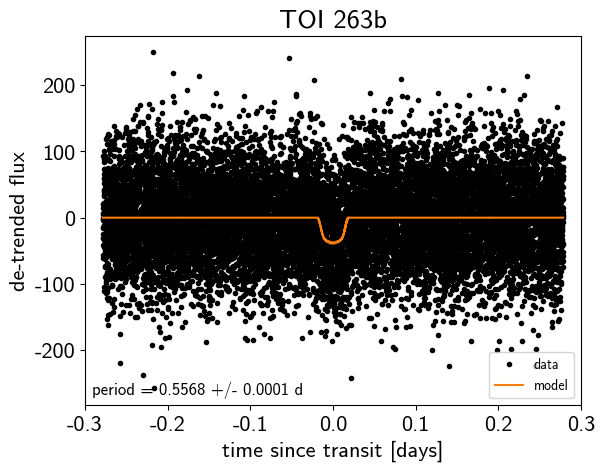

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

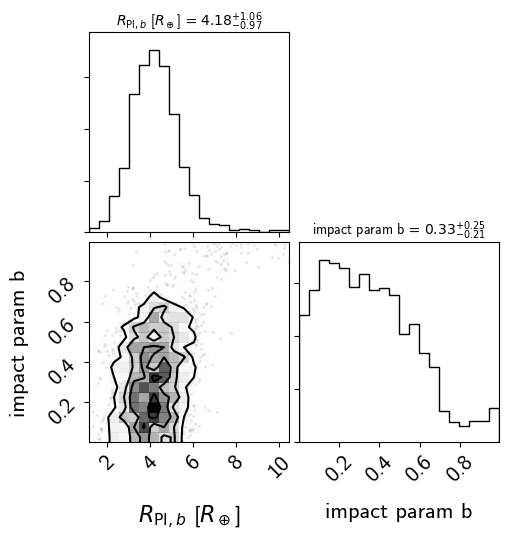

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

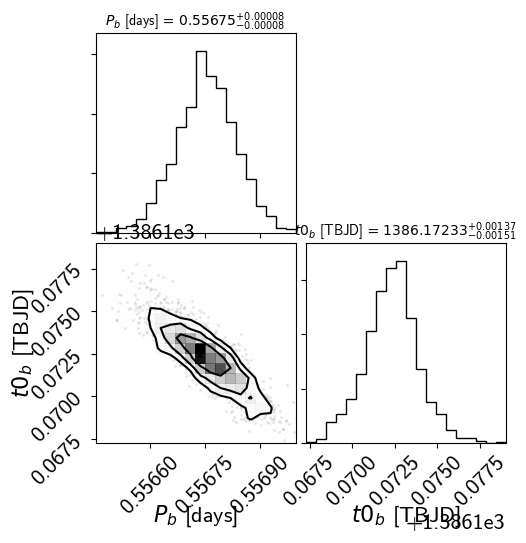

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

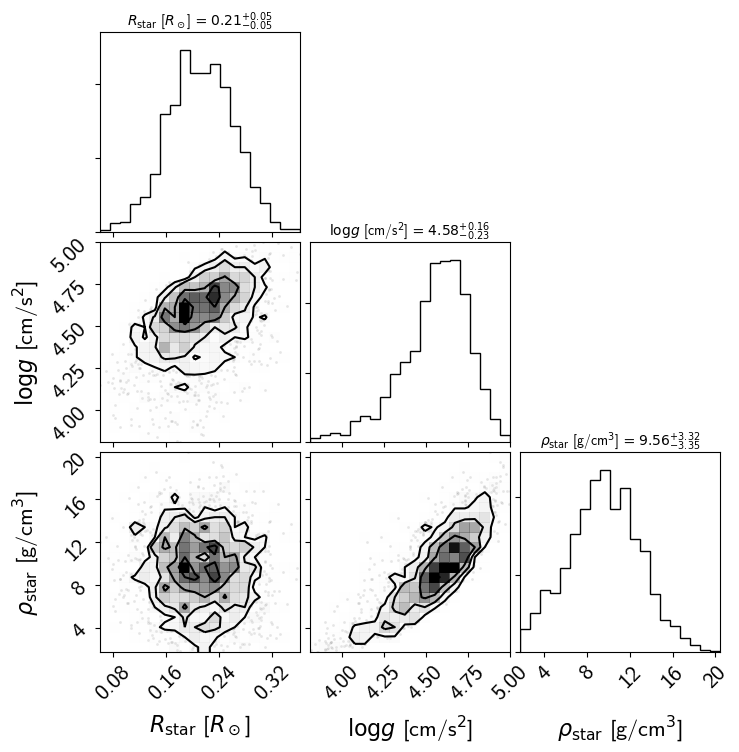

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3